In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Sat Feb 10 00:54:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   33C    P8              19W / 215W |    405MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
os.getcwd()

'/home/linh/projects/test_notebooks'

In [5]:
os.chdir('../IConNet')

In [6]:
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
dataset = 'text_emotion'
input_feature = 'signals_3channels_win5stride1'
output_label = 'labels_13emotions'
data_dir = f'../data/nlp/{dataset}/'

In [9]:
data_path_prefix = f'{data_dir}preprocessed/{dataset}'
x_train = np.load(f'{data_path_prefix}.{input_feature}.train.npy', allow_pickle=True)
x_test = np.load(f'{data_path_prefix}.{input_feature}.test.npy', allow_pickle=True)
labels = np.load(f'{data_path_prefix}.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_path_prefix}.{output_label}.test.npy', allow_pickle=True)
y_test = np.load(f'{data_path_prefix}.{output_label}.test.npy', allow_pickle=True)

In [10]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, labels, sep=' ')

(8000, 3, 1024) (8000, 3, 1024) (8000,) (8000,) ['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry']


In [11]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train, dtype=torch.float)
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test, dtype=torch.float)
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    return train_loader, test_loader

In [12]:
batch_size = 128
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [13]:
from IConNet.nn.model import M11

In [14]:
from omegaconf import OmegaConf as ocf

In [73]:
del model
gc.collect()

0

In [74]:
model_config_path = 'config/model/m10.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M10', 'description': 'gated residual FirConv', 'fe': {'n_block': 2, 'n_channel': [128, 128], 'kernel_size': [511, 127], 'stride': [2, 8], 'window_k': [2, 9], 'residual_connection_type': 'concat', 'pooling': 'None'}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256]}}

In [75]:
labels

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

In [76]:
model = M11(config=model_config,
           n_input=3, n_output=len(labels))
model

M11(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): SeqBlocks(
    (blocks): LSTM(128, 64, num_layers=2, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [77]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data = transform(data)
        data_length = len(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        del data
        gc.collect()
        torch.cuda.empty_cache()
        loss = F.cross_entropy(output.squeeze(), target)
        del target
        gc.collect()
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        train_losses.append(loss.item())

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        # data = transform(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [78]:
n_epoch = 500
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [79]:
log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                        | 0.015873015873015872/500 [00:00<3:29:54, 25.19s/it]

Train Epoch: 1 [0/8000 (0%)]	Loss: 2.642741


  0%|▏                                                                         | 0.9999999999999973/500 [00:24<3:06:57, 22.48s/it]


Test Epoch: 1	Accuracy: 2014/8000 (25%)



  0%|▏                                                                         | 1.0158730158730132/500 [00:25<3:15:36, 23.52s/it]

Train Epoch: 2 [0/8000 (0%)]	Loss: 2.104450


  0%|▎                                                                         | 1.9999999999999938/500 [00:49<3:18:07, 23.87s/it]


Test Epoch: 2	Accuracy: 1988/8000 (25%)



  0%|▎                                                                         | 2.0158730158730096/500 [00:49<3:20:27, 24.15s/it]

Train Epoch: 3 [0/8000 (0%)]	Loss: 2.070640


  1%|▍                                                                         | 2.9999999999999902/500 [01:13<3:05:49, 22.43s/it]


Test Epoch: 3	Accuracy: 1844/8000 (23%)



  1%|▍                                                                          | 3.015873015873006/500 [01:14<3:15:37, 23.62s/it]

Train Epoch: 4 [0/8000 (0%)]	Loss: 2.254588


  1%|▌                                                                         | 3.9999999999999867/500 [01:38<3:05:40, 22.46s/it]


Test Epoch: 4	Accuracy: 2024/8000 (25%)



  1%|▌                                                                         | 4.0158730158730025/500 [01:38<3:14:36, 23.54s/it]

Train Epoch: 5 [0/8000 (0%)]	Loss: 2.127395


  1%|▋                                                                          | 4.999999999999983/500 [02:02<3:04:20, 22.35s/it]


Test Epoch: 5	Accuracy: 1903/8000 (24%)



  1%|▊                                                                          | 5.015873015872999/500 [02:02<3:14:01, 23.52s/it]

Train Epoch: 6 [0/8000 (0%)]	Loss: 2.047437


  1%|▉                                                                           | 5.99999999999998/500 [02:27<3:09:20, 23.00s/it]


Test Epoch: 6	Accuracy: 2013/8000 (25%)



  1%|▉                                                                          | 6.015873015872995/500 [02:27<3:18:16, 24.08s/it]

Train Epoch: 7 [0/8000 (0%)]	Loss: 2.224482


  1%|█                                                                          | 6.999999999999976/500 [02:51<3:05:32, 22.58s/it]


Test Epoch: 7	Accuracy: 1962/8000 (25%)



  1%|█                                                                          | 7.015873015872992/500 [02:52<3:19:40, 24.30s/it]

Train Epoch: 8 [0/8000 (0%)]	Loss: 2.116319


  2%|█▏                                                                        | 7.9999999999999725/500 [03:16<3:04:57, 22.56s/it]


Test Epoch: 8	Accuracy: 2014/8000 (25%)



  2%|█▏                                                                          | 8.01587301587299/500 [03:16<3:14:22, 23.71s/it]

Train Epoch: 9 [0/8000 (0%)]	Loss: 2.114705


  2%|█▎                                                                          | 8.99999999999997/500 [03:40<3:07:28, 22.91s/it]


Test Epoch: 9	Accuracy: 1913/8000 (24%)



  2%|█▎                                                                         | 9.015873015872986/500 [03:41<3:15:56, 23.95s/it]

Train Epoch: 10 [0/8000 (0%)]	Loss: 2.090033


  2%|█▍                                                                         | 9.999999999999966/500 [04:05<3:06:04, 22.78s/it]


Test Epoch: 10	Accuracy: 1995/8000 (25%)



  2%|█▍                                                                        | 10.015873015872982/500 [04:05<3:16:35, 24.07s/it]

Train Epoch: 11 [0/8000 (0%)]	Loss: 2.236131


  2%|█▋                                                                        | 10.999999999999963/500 [04:30<3:04:11, 22.60s/it]


Test Epoch: 11	Accuracy: 1926/8000 (24%)



  2%|█▋                                                                        | 11.015873015872979/500 [04:30<3:13:06, 23.70s/it]

Train Epoch: 12 [0/8000 (0%)]	Loss: 2.130018


  2%|█▊                                                                         | 11.99999999999996/500 [04:54<3:02:30, 22.44s/it]


Test Epoch: 12	Accuracy: 2024/8000 (25%)



  2%|█▊                                                                        | 12.015873015872975/500 [04:54<3:11:28, 23.54s/it]

Train Epoch: 13 [0/8000 (0%)]	Loss: 2.170417


  3%|█▉                                                                        | 12.999999999999956/500 [05:19<3:05:20, 22.83s/it]


Test Epoch: 13	Accuracy: 1920/8000 (24%)



  3%|█▉                                                                        | 13.015873015872971/500 [05:19<3:13:34, 23.85s/it]

Train Epoch: 14 [0/8000 (0%)]	Loss: 2.106130


  3%|██                                                                        | 13.999999999999952/500 [05:43<3:02:24, 22.52s/it]


Test Epoch: 14	Accuracy: 2014/8000 (25%)



  3%|██                                                                        | 14.015873015872968/500 [05:44<3:12:01, 23.71s/it]

Train Epoch: 15 [0/8000 (0%)]	Loss: 2.082010


  3%|██▏                                                                       | 14.999999999999948/500 [06:08<3:04:46, 22.86s/it]


Test Epoch: 15	Accuracy: 1971/8000 (25%)



  3%|██▏                                                                       | 15.015873015872964/500 [06:09<3:14:07, 24.02s/it]

Train Epoch: 16 [0/8000 (0%)]	Loss: 2.069990


  3%|██▎                                                                       | 15.999999999999945/500 [06:33<3:04:02, 22.82s/it]


Test Epoch: 16	Accuracy: 2010/8000 (25%)



  3%|██▎                                                                       | 16.015873015872963/500 [06:33<3:14:19, 24.09s/it]

Train Epoch: 17 [0/8000 (0%)]	Loss: 2.288969


  3%|██▌                                                                       | 17.000000000000163/500 [06:58<3:03:59, 22.86s/it]


Test Epoch: 17	Accuracy: 2012/8000 (25%)



  3%|██▌                                                                       | 17.015873015873183/500 [06:58<3:12:09, 23.87s/it]

Train Epoch: 18 [0/8000 (0%)]	Loss: 2.152573


  4%|██▋                                                                       | 18.000000000000384/500 [07:22<3:03:51, 22.89s/it]


Test Epoch: 18	Accuracy: 1817/8000 (23%)



  4%|██▋                                                                       | 18.015873015873403/500 [07:23<3:12:13, 23.93s/it]

Train Epoch: 19 [0/8000 (0%)]	Loss: 2.218199


  4%|██▊                                                                       | 19.000000000000604/500 [07:47<3:01:55, 22.69s/it]


Test Epoch: 19	Accuracy: 1986/8000 (25%)



  4%|██▊                                                                       | 19.015873015873623/500 [07:47<3:10:29, 23.76s/it]

Train Epoch: 20 [0/8000 (0%)]	Loss: 2.205794


  4%|██▉                                                                       | 20.000000000000824/500 [08:12<3:13:37, 24.20s/it]


Test Epoch: 20	Accuracy: 2001/8000 (25%)



  4%|██▉                                                                       | 20.015873015873844/500 [08:12<3:16:31, 24.57s/it]

Train Epoch: 21 [0/8000 (0%)]	Loss: 2.114512


  4%|███                                                                       | 21.000000000001044/500 [08:36<3:01:00, 22.67s/it]


Test Epoch: 21	Accuracy: 1995/8000 (25%)



  4%|███                                                                       | 21.015873015874064/500 [08:37<3:10:02, 23.81s/it]

Train Epoch: 22 [0/8000 (0%)]	Loss: 2.079544


  4%|███▎                                                                      | 22.000000000001265/500 [09:01<3:00:16, 22.63s/it]


Test Epoch: 22	Accuracy: 1932/8000 (24%)



  4%|███▎                                                                      | 22.015873015874284/500 [09:01<3:08:45, 23.69s/it]

Train Epoch: 23 [0/8000 (0%)]	Loss: 2.254945


  5%|███▍                                                                      | 23.000000000001485/500 [09:25<3:00:31, 22.71s/it]


Test Epoch: 23	Accuracy: 2026/8000 (25%)



  5%|███▍                                                                      | 23.015873015874504/500 [09:26<3:08:54, 23.76s/it]

Train Epoch: 24 [0/8000 (0%)]	Loss: 2.084961


  5%|███▌                                                                      | 24.000000000001705/500 [09:50<2:58:58, 22.56s/it]


Test Epoch: 24	Accuracy: 1978/8000 (25%)



  5%|███▌                                                                      | 24.015873015874725/500 [09:50<3:07:05, 23.58s/it]

Train Epoch: 25 [0/8000 (0%)]	Loss: 2.172369


  5%|███▋                                                                      | 25.000000000001926/500 [10:14<2:58:26, 22.54s/it]


Test Epoch: 25	Accuracy: 2018/8000 (25%)



  5%|███▋                                                                      | 25.015873015874945/500 [10:14<3:07:29, 23.68s/it]

Train Epoch: 26 [0/8000 (0%)]	Loss: 2.185643


  5%|███▊                                                                      | 26.000000000002146/500 [10:38<2:58:22, 22.58s/it]


Test Epoch: 26	Accuracy: 1955/8000 (24%)



  5%|███▊                                                                      | 26.015873015875165/500 [10:39<3:06:44, 23.64s/it]

Train Epoch: 27 [0/8000 (0%)]	Loss: 2.107738


  5%|███▉                                                                      | 27.000000000002366/500 [11:03<2:57:11, 22.48s/it]


Test Epoch: 27	Accuracy: 1986/8000 (25%)



  5%|███▉                                                                      | 27.015873015875385/500 [11:03<3:05:49, 23.57s/it]

Train Epoch: 28 [0/8000 (0%)]	Loss: 2.156064


  6%|████▏                                                                     | 28.000000000002586/500 [11:27<2:56:58, 22.50s/it]


Test Epoch: 28	Accuracy: 1936/8000 (24%)



  6%|████▏                                                                     | 28.015873015875606/500 [11:28<3:07:11, 23.80s/it]

Train Epoch: 29 [0/8000 (0%)]	Loss: 2.105727


  6%|████▎                                                                     | 29.000000000002807/500 [11:52<2:56:20, 22.46s/it]


Test Epoch: 29	Accuracy: 2024/8000 (25%)



  6%|████▎                                                                     | 29.015873015875826/500 [11:52<3:04:59, 23.57s/it]

Train Epoch: 30 [0/8000 (0%)]	Loss: 2.040489


  6%|████▍                                                                     | 30.000000000003027/500 [12:16<2:59:22, 22.90s/it]


Test Epoch: 30	Accuracy: 2042/8000 (26%)



  6%|████▍                                                                     | 30.015873015876046/500 [12:17<3:08:26, 24.06s/it]

Train Epoch: 31 [0/8000 (0%)]	Loss: 2.208846


  6%|████▌                                                                     | 31.000000000003247/500 [12:41<2:57:30, 22.71s/it]


Test Epoch: 31	Accuracy: 2010/8000 (25%)



  6%|████▌                                                                     | 31.015873015876267/500 [12:41<3:05:57, 23.79s/it]

Train Epoch: 32 [0/8000 (0%)]	Loss: 2.132998


  6%|████▊                                                                      | 32.00000000000347/500 [13:06<2:56:36, 22.64s/it]


Test Epoch: 32	Accuracy: 2035/8000 (25%)



  6%|████▊                                                                      | 32.01587301587648/500 [13:06<3:05:48, 23.82s/it]

Train Epoch: 33 [0/8000 (0%)]	Loss: 2.239985


  7%|████▉                                                                      | 33.00000000000324/500 [13:30<2:55:15, 22.52s/it]


Test Epoch: 33	Accuracy: 2027/8000 (25%)



  7%|████▉                                                                      | 33.01587301587625/500 [13:30<3:04:18, 23.68s/it]

Train Epoch: 34 [0/8000 (0%)]	Loss: 2.122265


  7%|█████                                                                      | 34.00000000000301/500 [13:54<2:54:52, 22.52s/it]


Test Epoch: 34	Accuracy: 2016/8000 (25%)



  7%|█████                                                                     | 34.015873015876025/500 [13:55<3:03:08, 23.58s/it]

Train Epoch: 35 [0/8000 (0%)]	Loss: 2.062585


  7%|█████▏                                                                    | 35.000000000002785/500 [14:19<2:55:41, 22.67s/it]


Test Epoch: 35	Accuracy: 2034/8000 (25%)



  7%|█████▎                                                                      | 35.0158730158758/500 [14:19<3:04:01, 23.75s/it]

Train Epoch: 36 [0/8000 (0%)]	Loss: 2.039479


  7%|█████▍                                                                     | 36.00000000000256/500 [14:43<2:53:18, 22.41s/it]


Test Epoch: 36	Accuracy: 1951/8000 (24%)



  7%|█████▍                                                                     | 36.01587301587557/500 [14:44<3:02:12, 23.56s/it]

Train Epoch: 37 [0/8000 (0%)]	Loss: 2.149266


  7%|█████▌                                                                     | 37.00000000000233/500 [15:08<2:53:14, 22.45s/it]


Test Epoch: 37	Accuracy: 1978/8000 (25%)



  7%|█████▌                                                                     | 37.01587301587534/500 [15:08<3:01:56, 23.58s/it]

Train Epoch: 38 [0/8000 (0%)]	Loss: 2.147716


  8%|█████▊                                                                      | 38.0000000000021/500 [15:32<2:52:51, 22.45s/it]


Test Epoch: 38	Accuracy: 1992/8000 (25%)



  8%|█████▋                                                                    | 38.015873015875115/500 [15:33<3:02:22, 23.69s/it]

Train Epoch: 39 [0/8000 (0%)]	Loss: 2.070189


  8%|█████▊                                                                    | 39.000000000001876/500 [15:57<2:53:27, 22.58s/it]


Test Epoch: 39	Accuracy: 2008/8000 (25%)



  8%|█████▊                                                                     | 39.01587301587489/500 [15:57<3:01:08, 23.58s/it]

Train Epoch: 40 [0/8000 (0%)]	Loss: 2.108868


  8%|██████                                                                     | 40.00000000000165/500 [16:21<2:52:35, 22.51s/it]


Test Epoch: 40	Accuracy: 2014/8000 (25%)



  8%|██████                                                                     | 40.01587301587466/500 [16:21<3:01:06, 23.62s/it]

Train Epoch: 41 [0/8000 (0%)]	Loss: 2.162876


  8%|██████▏                                                                    | 41.00000000000142/500 [16:45<2:51:58, 22.48s/it]


Test Epoch: 41	Accuracy: 1982/8000 (25%)



  8%|██████▏                                                                    | 41.01587301587443/500 [16:46<3:00:36, 23.61s/it]

Train Epoch: 42 [0/8000 (0%)]	Loss: 2.043932


  8%|██████▏                                                                   | 42.000000000001194/500 [17:10<2:51:29, 22.47s/it]


Test Epoch: 42	Accuracy: 2019/8000 (25%)



  8%|██████▏                                                                   | 42.015873015874206/500 [17:10<2:59:44, 23.55s/it]

Train Epoch: 43 [0/8000 (0%)]	Loss: 2.128930


  9%|██████▎                                                                   | 43.000000000000966/500 [17:34<2:51:13, 22.48s/it]


Test Epoch: 43	Accuracy: 2035/8000 (25%)



  9%|██████▍                                                                    | 43.01587301587398/500 [17:35<3:00:08, 23.65s/it]

Train Epoch: 44 [0/8000 (0%)]	Loss: 2.073540


  9%|██████▌                                                                    | 44.00000000000074/500 [17:59<2:51:04, 22.51s/it]


Test Epoch: 44	Accuracy: 2048/8000 (26%)



  9%|██████▌                                                                    | 44.01587301587375/500 [17:59<2:59:57, 23.68s/it]

Train Epoch: 45 [0/8000 (0%)]	Loss: 2.098882


  9%|██████▊                                                                    | 45.00000000000051/500 [18:23<2:50:15, 22.45s/it]


Test Epoch: 45	Accuracy: 2050/8000 (26%)



  9%|██████▋                                                                   | 45.015873015873524/500 [18:23<2:58:41, 23.56s/it]

Train Epoch: 46 [0/8000 (0%)]	Loss: 2.209901


  9%|██████▊                                                                   | 46.000000000000284/500 [18:47<2:50:25, 22.52s/it]


Test Epoch: 46	Accuracy: 2050/8000 (26%)



  9%|██████▉                                                                     | 46.0158730158733/500 [18:48<2:58:19, 23.57s/it]

Train Epoch: 47 [0/8000 (0%)]	Loss: 2.081081


  9%|███████                                                                    | 47.00000000000006/500 [19:12<2:49:57, 22.51s/it]


Test Epoch: 47	Accuracy: 2042/8000 (26%)



  9%|███████                                                                    | 47.01587301587307/500 [19:12<2:58:10, 23.60s/it]

Train Epoch: 48 [0/8000 (0%)]	Loss: 2.203106


 10%|███████▏                                                                   | 47.99999999999983/500 [19:36<2:49:48, 22.54s/it]


Test Epoch: 48	Accuracy: 2042/8000 (26%)



 10%|███████▏                                                                   | 48.01587301587284/500 [19:37<2:58:07, 23.65s/it]

Train Epoch: 49 [0/8000 (0%)]	Loss: 2.351749


 10%|███████▍                                                                    | 48.9999999999996/500 [20:01<2:49:28, 22.55s/it]


Test Epoch: 49	Accuracy: 2006/8000 (25%)



 10%|███████▎                                                                  | 49.015873015872614/500 [20:01<2:57:20, 23.59s/it]

Train Epoch: 50 [0/8000 (0%)]	Loss: 2.234937


 10%|███████▍                                                                  | 49.999999999999375/500 [20:25<2:48:27, 22.46s/it]


Test Epoch: 50	Accuracy: 2044/8000 (26%)



 10%|███████▌                                                                   | 50.01587301587239/500 [20:26<2:57:32, 23.67s/it]

Train Epoch: 51 [0/8000 (0%)]	Loss: 2.085483


 10%|███████▋                                                                   | 50.99999999999915/500 [20:50<2:49:39, 22.67s/it]


Test Epoch: 51	Accuracy: 2052/8000 (26%)



 10%|███████▋                                                                   | 51.01587301587216/500 [20:50<2:57:05, 23.67s/it]

Train Epoch: 52 [0/8000 (0%)]	Loss: 2.028936


 10%|███████▊                                                                   | 51.99999999999892/500 [21:14<2:48:20, 22.55s/it]


Test Epoch: 52	Accuracy: 2049/8000 (26%)



 10%|███████▊                                                                   | 52.01587301587193/500 [21:14<2:56:17, 23.61s/it]

Train Epoch: 53 [0/8000 (0%)]	Loss: 2.105149


 11%|███████▉                                                                   | 52.99999999999869/500 [21:38<2:47:48, 22.52s/it]


Test Epoch: 53	Accuracy: 2058/8000 (26%)



 11%|███████▊                                                                  | 53.015873015871705/500 [21:39<2:56:06, 23.64s/it]

Train Epoch: 54 [0/8000 (0%)]	Loss: 2.221531


 11%|███████▉                                                                  | 53.999999999998465/500 [22:03<2:47:18, 22.51s/it]


Test Epoch: 54	Accuracy: 1937/8000 (24%)



 11%|████████                                                                   | 54.01587301587148/500 [22:03<2:54:55, 23.53s/it]

Train Epoch: 55 [0/8000 (0%)]	Loss: 2.167037


 11%|████████▏                                                                  | 54.99999999999824/500 [22:27<2:46:47, 22.49s/it]


Test Epoch: 55	Accuracy: 2070/8000 (26%)



 11%|████████▎                                                                  | 55.01587301587125/500 [22:28<2:54:50, 23.58s/it]

Train Epoch: 56 [0/8000 (0%)]	Loss: 2.132881


 11%|████████▍                                                                  | 55.99999999999801/500 [22:52<2:51:50, 23.22s/it]


Test Epoch: 56	Accuracy: 2035/8000 (25%)



 11%|████████▍                                                                  | 56.01587301587102/500 [22:52<2:57:38, 24.01s/it]

Train Epoch: 57 [0/8000 (0%)]	Loss: 2.180739


 11%|████████▌                                                                  | 56.99999999999778/500 [23:16<2:48:01, 22.76s/it]


Test Epoch: 57	Accuracy: 2062/8000 (26%)



 11%|████████▍                                                                 | 57.015873015870795/500 [23:17<2:56:06, 23.85s/it]

Train Epoch: 58 [0/8000 (0%)]	Loss: 2.150035


 12%|████████▌                                                                 | 57.999999999997556/500 [23:41<2:46:53, 22.65s/it]


Test Epoch: 58	Accuracy: 2081/8000 (26%)



 12%|████████▋                                                                  | 58.01587301587057/500 [23:41<2:56:00, 23.89s/it]

Train Epoch: 59 [0/8000 (0%)]	Loss: 2.157064


 12%|████████▊                                                                  | 58.99999999999733/500 [24:06<2:49:45, 23.10s/it]


Test Epoch: 59	Accuracy: 2049/8000 (26%)



 12%|████████▊                                                                  | 59.01587301587034/500 [24:06<2:59:43, 24.45s/it]

Train Epoch: 60 [0/8000 (0%)]	Loss: 2.206154


 12%|█████████                                                                   | 59.9999999999971/500 [24:31<2:49:08, 23.06s/it]


Test Epoch: 60	Accuracy: 2090/8000 (26%)



 12%|█████████                                                                  | 60.01587301587011/500 [24:31<2:57:27, 24.20s/it]

Train Epoch: 61 [0/8000 (0%)]	Loss: 2.051106


 12%|█████████                                                                 | 60.999999999996874/500 [24:56<2:48:32, 23.04s/it]


Test Epoch: 61	Accuracy: 2053/8000 (26%)



 12%|█████████                                                                 | 61.015873015869886/500 [24:56<2:58:16, 24.37s/it]

Train Epoch: 62 [0/8000 (0%)]	Loss: 2.152336


 12%|█████████▏                                                                | 61.999999999996646/500 [25:21<2:48:23, 23.07s/it]


Test Epoch: 62	Accuracy: 2089/8000 (26%)



 12%|█████████▎                                                                 | 62.01587301586966/500 [25:21<2:56:43, 24.21s/it]

Train Epoch: 63 [0/8000 (0%)]	Loss: 2.285460


 13%|█████████▍                                                                 | 62.99999999999642/500 [25:46<2:47:52, 23.05s/it]


Test Epoch: 63	Accuracy: 2088/8000 (26%)



 13%|█████████▍                                                                 | 63.01587301586943/500 [25:46<2:56:31, 24.24s/it]

Train Epoch: 64 [0/8000 (0%)]	Loss: 2.131807


 13%|█████████▌                                                                 | 63.99999999999619/500 [26:11<2:47:54, 23.11s/it]


Test Epoch: 64	Accuracy: 2082/8000 (26%)



 13%|█████████▋                                                                  | 64.0158730158692/500 [26:11<2:55:49, 24.20s/it]

Train Epoch: 65 [0/8000 (0%)]	Loss: 2.127755


 13%|█████████▋                                                                 | 64.99999999999596/500 [26:36<2:43:36, 22.57s/it]


Test Epoch: 65	Accuracy: 2097/8000 (26%)



 13%|█████████▊                                                                 | 65.01587301586898/500 [26:36<2:51:52, 23.71s/it]

Train Epoch: 66 [0/8000 (0%)]	Loss: 2.172775


 13%|█████████▉                                                                 | 65.99999999999574/500 [27:00<2:43:35, 22.62s/it]


Test Epoch: 66	Accuracy: 2053/8000 (26%)



 13%|█████████▉                                                                 | 66.01587301586875/500 [27:01<2:52:03, 23.79s/it]

Train Epoch: 67 [0/8000 (0%)]	Loss: 2.157547


 13%|██████████                                                                 | 66.99999999999551/500 [27:25<2:43:34, 22.67s/it]


Test Epoch: 67	Accuracy: 2113/8000 (26%)



 13%|██████████                                                                 | 67.01587301586852/500 [27:25<2:51:21, 23.75s/it]

Train Epoch: 68 [0/8000 (0%)]	Loss: 2.039345


 14%|██████████▏                                                                | 67.99999999999528/500 [27:49<2:43:23, 22.69s/it]


Test Epoch: 68	Accuracy: 2111/8000 (26%)



 14%|██████████▎                                                                 | 68.0158730158683/500 [27:50<2:51:20, 23.80s/it]

Train Epoch: 69 [0/8000 (0%)]	Loss: 2.094971


 14%|██████████▎                                                                | 68.99999999999505/500 [28:14<2:42:19, 22.60s/it]


Test Epoch: 69	Accuracy: 2139/8000 (27%)



 14%|██████████▎                                                                | 69.01587301586807/500 [28:14<2:50:38, 23.76s/it]

Train Epoch: 70 [0/8000 (0%)]	Loss: 2.126370


 14%|██████████▍                                                                | 69.99999999999483/500 [28:39<2:42:07, 22.62s/it]


Test Epoch: 70	Accuracy: 2139/8000 (27%)



 14%|██████████▌                                                                | 70.01587301586784/500 [28:39<2:49:50, 23.70s/it]

Train Epoch: 71 [0/8000 (0%)]	Loss: 2.025764


 14%|██████████▊                                                                 | 70.9999999999946/500 [29:03<2:44:37, 23.02s/it]


Test Epoch: 71	Accuracy: 2136/8000 (27%)



 14%|██████████▋                                                                | 71.01587301586761/500 [29:04<2:53:39, 24.29s/it]

Train Epoch: 72 [0/8000 (0%)]	Loss: 2.024948


 14%|██████████▊                                                                | 71.99999999999437/500 [29:28<2:41:41, 22.67s/it]


Test Epoch: 72	Accuracy: 2184/8000 (27%)



 14%|██████████▊                                                                | 72.01587301586738/500 [29:28<2:49:58, 23.83s/it]

Train Epoch: 73 [0/8000 (0%)]	Loss: 2.133883


 15%|██████████▉                                                                | 72.99999999999415/500 [29:53<2:41:43, 22.73s/it]


Test Epoch: 73	Accuracy: 2174/8000 (27%)



 15%|██████████▉                                                                | 73.01587301586716/500 [29:53<2:49:28, 23.81s/it]

Train Epoch: 74 [0/8000 (0%)]	Loss: 1.986245


 15%|███████████                                                                | 73.99999999999392/500 [30:17<2:41:08, 22.70s/it]


Test Epoch: 74	Accuracy: 2192/8000 (27%)



 15%|███████████                                                                | 74.01587301586693/500 [30:18<2:49:25, 23.86s/it]

Train Epoch: 75 [0/8000 (0%)]	Loss: 2.036308


 15%|███████████▏                                                               | 74.99999999999369/500 [30:42<2:41:00, 22.73s/it]


Test Epoch: 75	Accuracy: 2203/8000 (28%)



 15%|███████████▍                                                                | 75.0158730158667/500 [30:42<2:48:17, 23.76s/it]

Train Epoch: 76 [0/8000 (0%)]	Loss: 2.077699


 15%|███████████▍                                                               | 75.99999999999346/500 [31:07<2:41:10, 22.81s/it]


Test Epoch: 76	Accuracy: 2185/8000 (27%)



 15%|███████████▍                                                               | 76.01587301586648/500 [31:07<2:48:38, 23.87s/it]

Train Epoch: 77 [0/8000 (0%)]	Loss: 2.031291


 15%|███████████▌                                                               | 76.99999999999324/500 [31:31<2:40:08, 22.72s/it]


Test Epoch: 77	Accuracy: 2196/8000 (27%)



 15%|███████████▌                                                               | 77.01587301586625/500 [31:32<2:48:09, 23.85s/it]

Train Epoch: 78 [0/8000 (0%)]	Loss: 2.051737


 16%|███████████▋                                                               | 77.99999999999301/500 [31:56<2:40:17, 22.79s/it]


Test Epoch: 78	Accuracy: 2222/8000 (28%)



 16%|███████████▋                                                               | 78.01587301586602/500 [31:56<2:47:47, 23.86s/it]

Train Epoch: 79 [0/8000 (0%)]	Loss: 2.115779


 16%|███████████▊                                                               | 78.99999999999278/500 [32:21<2:41:08, 22.97s/it]


Test Epoch: 79	Accuracy: 2230/8000 (28%)



 16%|████████████                                                                | 79.0158730158658/500 [32:21<2:48:49, 24.06s/it]

Train Epoch: 80 [0/8000 (0%)]	Loss: 2.080319


 16%|███████████▉                                                               | 79.99999999999255/500 [32:46<2:40:45, 22.97s/it]


Test Epoch: 80	Accuracy: 2274/8000 (28%)



 16%|████████████                                                               | 80.01587301586557/500 [32:46<2:48:31, 24.08s/it]

Train Epoch: 81 [0/8000 (0%)]	Loss: 2.024674


 16%|████████████▏                                                              | 80.99999999999233/500 [33:10<2:40:47, 23.02s/it]


Test Epoch: 81	Accuracy: 2269/8000 (28%)



 16%|████████████▏                                                              | 81.01587301586534/500 [33:11<2:48:57, 24.20s/it]

Train Epoch: 82 [0/8000 (0%)]	Loss: 1.986862


 16%|████████████▍                                                               | 81.9999999999921/500 [33:35<2:38:10, 22.70s/it]


Test Epoch: 82	Accuracy: 2328/8000 (29%)



 16%|████████████▎                                                              | 82.01587301586511/500 [33:36<2:46:34, 23.91s/it]

Train Epoch: 83 [0/8000 (0%)]	Loss: 2.037768


 17%|████████████▍                                                              | 82.99999999999187/500 [34:00<2:37:15, 22.63s/it]


Test Epoch: 83	Accuracy: 2334/8000 (29%)



 17%|████████████▍                                                              | 83.01587301586488/500 [34:00<2:45:05, 23.76s/it]

Train Epoch: 84 [0/8000 (0%)]	Loss: 1.968242


 17%|████████████▌                                                              | 83.99999999999164/500 [34:24<2:38:15, 22.83s/it]


Test Epoch: 84	Accuracy: 2349/8000 (29%)



 17%|████████████▌                                                              | 84.01587301586466/500 [34:25<2:45:52, 23.93s/it]

Train Epoch: 85 [0/8000 (0%)]	Loss: 1.962054


 17%|████████████▋                                                              | 84.99999999999142/500 [34:49<2:38:12, 22.87s/it]


Test Epoch: 85	Accuracy: 2368/8000 (30%)



 17%|████████████▊                                                              | 85.01587301586443/500 [34:50<2:46:37, 24.09s/it]

Train Epoch: 86 [0/8000 (0%)]	Loss: 1.977087


 17%|████████████▉                                                              | 85.99999999999119/500 [35:14<2:37:59, 22.90s/it]


Test Epoch: 86	Accuracy: 2365/8000 (30%)



 17%|█████████████                                                               | 86.0158730158642/500 [35:14<2:45:51, 24.04s/it]

Train Epoch: 87 [0/8000 (0%)]	Loss: 1.994160


 17%|█████████████                                                              | 86.99999999999096/500 [35:39<2:37:47, 22.92s/it]


Test Epoch: 87	Accuracy: 2408/8000 (30%)



 17%|█████████████                                                              | 87.01587301586397/500 [35:39<2:46:00, 24.12s/it]

Train Epoch: 88 [0/8000 (0%)]	Loss: 1.947175


 18%|█████████████▏                                                             | 87.99999999999073/500 [36:04<2:37:01, 22.87s/it]


Test Epoch: 88	Accuracy: 2427/8000 (30%)



 18%|█████████████▏                                                             | 88.01587301586375/500 [36:04<2:45:09, 24.05s/it]

Train Epoch: 89 [0/8000 (0%)]	Loss: 2.029399


 18%|█████████████▎                                                             | 88.99999999999051/500 [36:29<2:34:30, 22.56s/it]


Test Epoch: 89	Accuracy: 2431/8000 (30%)



 18%|█████████████▎                                                             | 89.01587301586352/500 [36:29<2:42:09, 23.67s/it]

Train Epoch: 90 [0/8000 (0%)]	Loss: 1.947702


 18%|█████████████▍                                                             | 89.99999999999028/500 [36:53<2:33:49, 22.51s/it]


Test Epoch: 90	Accuracy: 2488/8000 (31%)



 18%|█████████████▌                                                             | 90.01587301586329/500 [36:53<2:41:39, 23.66s/it]

Train Epoch: 91 [0/8000 (0%)]	Loss: 2.086156


 18%|█████████████▋                                                             | 90.99999999999005/500 [37:18<2:33:58, 22.59s/it]


Test Epoch: 91	Accuracy: 2523/8000 (32%)



 18%|█████████████▋                                                             | 91.01587301586306/500 [37:18<2:41:00, 23.62s/it]

Train Epoch: 92 [0/8000 (0%)]	Loss: 1.827603


 18%|█████████████▊                                                             | 91.99999999998983/500 [37:42<2:33:33, 22.58s/it]


Test Epoch: 92	Accuracy: 2546/8000 (32%)



 18%|█████████████▊                                                             | 92.01587301586284/500 [37:42<2:40:38, 23.62s/it]

Train Epoch: 93 [0/8000 (0%)]	Loss: 1.810602


 19%|██████████████▏                                                             | 92.9999999999896/500 [38:07<2:37:04, 23.16s/it]


Test Epoch: 93	Accuracy: 2617/8000 (33%)



 19%|█████████████▉                                                             | 93.01587301586261/500 [38:07<2:44:04, 24.19s/it]

Train Epoch: 94 [0/8000 (0%)]	Loss: 1.844941


 19%|██████████████                                                             | 93.99999999998937/500 [38:32<2:35:06, 22.92s/it]


Test Epoch: 94	Accuracy: 2518/8000 (31%)



 19%|██████████████                                                             | 94.01587301586238/500 [38:32<2:42:24, 24.00s/it]

Train Epoch: 95 [0/8000 (0%)]	Loss: 1.942892


 19%|██████████████▏                                                            | 94.99999999998914/500 [38:56<2:35:14, 23.00s/it]


Test Epoch: 95	Accuracy: 2635/8000 (33%)



 19%|██████████████▎                                                            | 95.01587301586216/500 [38:57<2:42:44, 24.11s/it]

Train Epoch: 96 [0/8000 (0%)]	Loss: 1.922811


 19%|██████████████▍                                                            | 95.99999999998892/500 [39:21<2:34:33, 22.95s/it]


Test Epoch: 96	Accuracy: 2712/8000 (34%)



 19%|██████████████▍                                                            | 96.01587301586193/500 [39:22<2:42:06, 24.08s/it]

Train Epoch: 97 [0/8000 (0%)]	Loss: 1.906346


 19%|██████████████▌                                                            | 96.99999999998869/500 [39:46<2:31:01, 22.49s/it]


Test Epoch: 97	Accuracy: 2613/8000 (33%)



 19%|██████████████▋                                                             | 97.0158730158617/500 [39:46<2:38:43, 23.63s/it]

Train Epoch: 98 [0/8000 (0%)]	Loss: 1.839665


 20%|██████████████▋                                                            | 97.99999999998846/500 [40:10<2:30:04, 22.40s/it]


Test Epoch: 98	Accuracy: 2741/8000 (34%)



 20%|██████████████▋                                                            | 98.01587301586147/500 [40:11<2:38:11, 23.61s/it]

Train Epoch: 99 [0/8000 (0%)]	Loss: 1.879676


 20%|██████████████▊                                                            | 98.99999999998823/500 [40:35<2:30:34, 22.53s/it]


Test Epoch: 99	Accuracy: 2856/8000 (36%)



 20%|██████████████▊                                                            | 99.01587301586125/500 [40:35<2:38:06, 23.66s/it]

Train Epoch: 100 [0/8000 (0%)]	Loss: 1.746431


 20%|███████████████▍                                                             | 99.999999999988/500 [40:59<2:29:40, 22.45s/it]


Test Epoch: 100	Accuracy: 2802/8000 (35%)



 20%|██████████████▊                                                           | 100.01587301586102/500 [41:00<2:37:20, 23.60s/it]

Train Epoch: 101 [0/8000 (0%)]	Loss: 1.689845


 20%|██████████████▉                                                           | 100.99999999998778/500 [41:24<2:29:22, 22.46s/it]


Test Epoch: 101	Accuracy: 2898/8000 (36%)



 20%|██████████████▉                                                           | 101.01587301586079/500 [41:24<2:36:40, 23.56s/it]

Train Epoch: 102 [0/8000 (0%)]	Loss: 1.870875


 20%|███████████████                                                           | 101.99999999998755/500 [41:48<2:29:06, 22.48s/it]


Test Epoch: 102	Accuracy: 2932/8000 (37%)



 20%|███████████████                                                           | 102.01587301586056/500 [41:48<2:36:46, 23.64s/it]

Train Epoch: 103 [0/8000 (0%)]	Loss: 1.870722


 21%|███████████████▏                                                          | 102.99999999998732/500 [42:12<2:28:47, 22.49s/it]


Test Epoch: 103	Accuracy: 2956/8000 (37%)



 21%|███████████████▏                                                          | 103.01587301586034/500 [42:13<2:36:34, 23.67s/it]

Train Epoch: 104 [0/8000 (0%)]	Loss: 1.817688


 21%|███████████████▌                                                           | 103.9999999999871/500 [42:37<2:28:43, 22.54s/it]


Test Epoch: 104	Accuracy: 3091/8000 (39%)



 21%|███████████████▍                                                          | 104.01587301586011/500 [42:37<2:36:35, 23.73s/it]

Train Epoch: 105 [0/8000 (0%)]	Loss: 1.949627


 21%|███████████████▌                                                          | 104.99999999998687/500 [43:02<2:32:40, 23.19s/it]


Test Epoch: 105	Accuracy: 3252/8000 (41%)



 21%|███████████████▌                                                          | 105.01587301585988/500 [43:02<2:39:23, 24.21s/it]

Train Epoch: 106 [0/8000 (0%)]	Loss: 1.708292


 21%|███████████████▋                                                          | 105.99999999998664/500 [43:27<2:31:53, 23.13s/it]


Test Epoch: 106	Accuracy: 3225/8000 (40%)



 21%|███████████████▋                                                          | 106.01587301585965/500 [43:27<2:39:41, 24.32s/it]

Train Epoch: 107 [0/8000 (0%)]	Loss: 1.727821


 21%|███████████████▊                                                          | 106.99999999998641/500 [43:52<2:31:27, 23.12s/it]


Test Epoch: 107	Accuracy: 3329/8000 (42%)



 21%|███████████████▊                                                          | 107.01587301585943/500 [43:52<2:38:30, 24.20s/it]

Train Epoch: 108 [0/8000 (0%)]	Loss: 1.667854


 22%|███████████████▉                                                          | 107.99999999998619/500 [44:17<2:30:57, 23.11s/it]


Test Epoch: 108	Accuracy: 3374/8000 (42%)



 22%|████████████████▏                                                          | 108.0158730158592/500 [44:17<2:38:31, 24.26s/it]

Train Epoch: 109 [0/8000 (0%)]	Loss: 1.457175


 22%|████████████████▏                                                         | 108.99999999998596/500 [44:42<2:27:54, 22.70s/it]


Test Epoch: 109	Accuracy: 3363/8000 (42%)



 22%|████████████████▏                                                         | 109.01587301585897/500 [44:42<2:34:23, 23.69s/it]

Train Epoch: 110 [0/8000 (0%)]	Loss: 1.557406


 22%|████████████████▎                                                         | 109.99999999998573/500 [45:06<2:27:24, 22.68s/it]


Test Epoch: 110	Accuracy: 3539/8000 (44%)



 22%|████████████████▎                                                         | 110.01587301585874/500 [45:07<2:35:11, 23.88s/it]

Train Epoch: 111 [0/8000 (0%)]	Loss: 1.421376


 22%|████████████████▋                                                          | 110.9999999999855/500 [45:31<2:27:00, 22.67s/it]


Test Epoch: 111	Accuracy: 3621/8000 (45%)



 22%|████████████████▍                                                         | 111.01587301585852/500 [45:31<2:34:16, 23.80s/it]

Train Epoch: 112 [0/8000 (0%)]	Loss: 1.520175


 22%|████████████████▌                                                         | 111.99999999998528/500 [45:55<2:28:12, 22.92s/it]


Test Epoch: 112	Accuracy: 3658/8000 (46%)



 22%|████████████████▌                                                         | 112.01587301585829/500 [45:56<2:35:48, 24.10s/it]

Train Epoch: 113 [0/8000 (0%)]	Loss: 1.457350


 23%|████████████████▋                                                         | 112.99999999998505/500 [46:20<2:28:16, 22.99s/it]


Test Epoch: 113	Accuracy: 3751/8000 (47%)



 23%|████████████████▋                                                         | 113.01587301585806/500 [46:21<2:35:19, 24.08s/it]

Train Epoch: 114 [0/8000 (0%)]	Loss: 1.393430


 23%|████████████████▊                                                         | 113.99999999998482/500 [46:45<2:27:44, 22.96s/it]


Test Epoch: 114	Accuracy: 3981/8000 (50%)



 23%|████████████████▊                                                         | 114.01587301585784/500 [46:46<2:34:40, 24.04s/it]

Train Epoch: 115 [0/8000 (0%)]	Loss: 1.567991


 23%|█████████████████▏                                                         | 114.9999999999846/500 [47:10<2:24:37, 22.54s/it]


Test Epoch: 115	Accuracy: 3875/8000 (48%)



 23%|█████████████████                                                         | 115.01587301585761/500 [47:10<2:31:42, 23.64s/it]

Train Epoch: 116 [0/8000 (0%)]	Loss: 1.439642


 23%|█████████████████▏                                                        | 115.99999999998437/500 [47:34<2:23:54, 22.48s/it]


Test Epoch: 116	Accuracy: 4032/8000 (50%)



 23%|█████████████████▏                                                        | 116.01587301585738/500 [47:35<2:31:49, 23.72s/it]

Train Epoch: 117 [0/8000 (0%)]	Loss: 1.417306


 23%|█████████████████▎                                                        | 116.99999999998414/500 [47:59<2:27:46, 23.15s/it]


Test Epoch: 117	Accuracy: 4065/8000 (51%)



 23%|█████████████████▎                                                        | 117.01587301585715/500 [47:59<2:34:21, 24.18s/it]

Train Epoch: 118 [0/8000 (0%)]	Loss: 1.303055


 24%|█████████████████▍                                                        | 117.99999999998391/500 [48:24<2:27:39, 23.19s/it]


Test Epoch: 118	Accuracy: 4355/8000 (54%)



 24%|█████████████████▍                                                        | 118.01587301585693/500 [48:24<2:34:35, 24.28s/it]

Train Epoch: 119 [0/8000 (0%)]	Loss: 1.350096


 24%|█████████████████▌                                                        | 118.99999999998369/500 [48:49<2:26:41, 23.10s/it]


Test Epoch: 119	Accuracy: 4109/8000 (51%)



 24%|█████████████████▊                                                         | 119.0158730158567/500 [48:49<2:33:36, 24.19s/it]

Train Epoch: 120 [0/8000 (0%)]	Loss: 1.246052


 24%|█████████████████▊                                                        | 119.99999999998346/500 [49:14<2:22:58, 22.57s/it]


Test Epoch: 120	Accuracy: 4375/8000 (55%)



 24%|█████████████████▊                                                        | 120.01587301585647/500 [49:14<2:29:48, 23.66s/it]

Train Epoch: 121 [0/8000 (0%)]	Loss: 1.183025


 24%|█████████████████▉                                                        | 120.99999999998323/500 [49:38<2:22:57, 22.63s/it]


Test Epoch: 121	Accuracy: 4468/8000 (56%)



 24%|█████████████████▉                                                        | 121.01587301585624/500 [49:38<2:29:22, 23.65s/it]

Train Epoch: 122 [0/8000 (0%)]	Loss: 1.340449


 24%|██████████████████▌                                                         | 121.999999999983/500 [50:02<2:22:59, 22.70s/it]


Test Epoch: 122	Accuracy: 4572/8000 (57%)



 24%|██████████████████                                                        | 122.01587301585602/500 [50:03<2:29:31, 23.73s/it]

Train Epoch: 123 [0/8000 (0%)]	Loss: 1.191171


 25%|██████████████████▏                                                       | 122.99999999998278/500 [50:27<2:22:40, 22.71s/it]


Test Epoch: 123	Accuracy: 4737/8000 (59%)



 25%|██████████████████▏                                                       | 123.01587301585579/500 [50:27<2:29:58, 23.87s/it]

Train Epoch: 124 [0/8000 (0%)]	Loss: 1.223959


 25%|██████████████████▎                                                       | 123.99999999998255/500 [50:51<2:21:24, 22.56s/it]


Test Epoch: 124	Accuracy: 4634/8000 (58%)



 25%|██████████████████▎                                                       | 124.01587301585556/500 [50:52<2:28:14, 23.66s/it]

Train Epoch: 125 [0/8000 (0%)]	Loss: 1.333777


 25%|██████████████████▍                                                       | 124.99999999998232/500 [51:16<2:21:01, 22.56s/it]


Test Epoch: 125	Accuracy: 4986/8000 (62%)



 25%|██████████████████▌                                                       | 125.01587301585533/500 [51:16<2:27:57, 23.67s/it]

Train Epoch: 126 [0/8000 (0%)]	Loss: 1.086647


 25%|██████████████████▉                                                        | 125.9999999999821/500 [51:40<2:20:11, 22.49s/it]


Test Epoch: 126	Accuracy: 4804/8000 (60%)



 25%|██████████████████▉                                                        | 126.0158730158551/500 [51:41<2:27:22, 23.64s/it]

Train Epoch: 127 [0/8000 (0%)]	Loss: 1.201599


 25%|██████████████████▊                                                       | 126.99999999998187/500 [52:05<2:24:01, 23.17s/it]


Test Epoch: 127	Accuracy: 4896/8000 (61%)



 25%|██████████████████▊                                                       | 127.01587301585488/500 [52:05<2:28:49, 23.94s/it]

Train Epoch: 128 [0/8000 (0%)]	Loss: 1.130243


 26%|██████████████████▉                                                       | 127.99999999998164/500 [52:29<2:19:50, 22.55s/it]


Test Epoch: 128	Accuracy: 5119/8000 (64%)



 26%|██████████████████▉                                                       | 128.01587301585465/500 [52:30<2:27:12, 23.75s/it]

Train Epoch: 129 [0/8000 (0%)]	Loss: 0.937198


 26%|███████████████████▎                                                       | 128.9999999999814/500 [52:54<2:19:58, 22.64s/it]


Test Epoch: 129	Accuracy: 5119/8000 (64%)



 26%|███████████████████                                                       | 129.01587301585442/500 [52:54<2:26:58, 23.77s/it]

Train Epoch: 130 [0/8000 (0%)]	Loss: 0.991579


 26%|███████████████████▏                                                      | 129.99999999998118/500 [53:18<2:20:16, 22.75s/it]


Test Epoch: 130	Accuracy: 5215/8000 (65%)



 26%|███████████████████▌                                                       | 130.0158730158542/500 [53:19<2:27:08, 23.86s/it]

Train Epoch: 131 [0/8000 (0%)]	Loss: 0.921394


 26%|███████████████████▍                                                      | 130.99999999998096/500 [53:43<2:20:12, 22.80s/it]


Test Epoch: 131	Accuracy: 5364/8000 (67%)



 26%|███████████████████▍                                                      | 131.01587301585397/500 [53:43<2:26:53, 23.89s/it]

Train Epoch: 132 [0/8000 (0%)]	Loss: 0.957430


 26%|███████████████████▌                                                      | 131.99999999998073/500 [54:08<2:19:44, 22.78s/it]


Test Epoch: 132	Accuracy: 5437/8000 (68%)



 26%|███████████████████▌                                                      | 132.01587301585374/500 [54:08<2:25:55, 23.79s/it]

Train Epoch: 133 [0/8000 (0%)]	Loss: 0.900119


 27%|███████████████████▉                                                       | 132.9999999999805/500 [54:32<2:18:56, 22.71s/it]


Test Epoch: 133	Accuracy: 5524/8000 (69%)



 27%|███████████████████▋                                                      | 133.01587301585351/500 [54:33<2:26:35, 23.97s/it]

Train Epoch: 134 [0/8000 (0%)]	Loss: 0.868367


 27%|███████████████████▊                                                      | 133.99999999998028/500 [54:57<2:18:59, 22.79s/it]


Test Epoch: 134	Accuracy: 5429/8000 (68%)



 27%|████████████████████                                                       | 134.0158730158533/500 [54:57<2:25:41, 23.88s/it]

Train Epoch: 135 [0/8000 (0%)]	Loss: 0.992457


 27%|███████████████████▉                                                      | 134.99999999998005/500 [55:22<2:18:24, 22.75s/it]


Test Epoch: 135	Accuracy: 5659/8000 (71%)



 27%|███████████████████▉                                                      | 135.01587301585306/500 [55:22<2:25:18, 23.89s/it]

Train Epoch: 136 [0/8000 (0%)]	Loss: 1.078707


 27%|████████████████████▏                                                     | 135.99999999997982/500 [55:46<2:16:57, 22.58s/it]


Test Epoch: 136	Accuracy: 5523/8000 (69%)



 27%|████████████████████▏                                                     | 136.01587301585283/500 [55:46<2:23:43, 23.69s/it]

Train Epoch: 137 [0/8000 (0%)]	Loss: 0.825989


 27%|████████████████████▌                                                      | 136.9999999999796/500 [56:11<2:16:24, 22.55s/it]


Test Epoch: 137	Accuracy: 5479/8000 (68%)



 27%|████████████████████▌                                                      | 137.0158730158526/500 [56:11<2:23:20, 23.70s/it]

Train Epoch: 138 [0/8000 (0%)]	Loss: 0.905497


 28%|████████████████████▍                                                     | 137.99999999997937/500 [56:35<2:15:54, 22.53s/it]


Test Epoch: 138	Accuracy: 5817/8000 (73%)



 28%|████████████████████▍                                                     | 138.01587301585238/500 [56:35<2:22:31, 23.63s/it]

Train Epoch: 139 [0/8000 (0%)]	Loss: 0.759927


 28%|████████████████████▌                                                     | 138.99999999997914/500 [57:00<2:16:00, 22.61s/it]


Test Epoch: 139	Accuracy: 5837/8000 (73%)



 28%|████████████████████▌                                                     | 139.01587301585215/500 [57:00<2:22:30, 23.69s/it]

Train Epoch: 140 [0/8000 (0%)]	Loss: 0.745699


 28%|████████████████████▉                                                      | 139.9999999999789/500 [57:24<2:15:24, 22.57s/it]


Test Epoch: 140	Accuracy: 6027/8000 (75%)



 28%|████████████████████▋                                                     | 140.01587301585192/500 [57:24<2:21:57, 23.66s/it]

Train Epoch: 141 [0/8000 (0%)]	Loss: 0.724739


 28%|████████████████████▊                                                     | 140.99999999997868/500 [57:48<2:15:05, 22.58s/it]


Test Epoch: 141	Accuracy: 6044/8000 (76%)



 28%|█████████████████████▏                                                     | 141.0158730158517/500 [57:49<2:21:49, 23.71s/it]

Train Epoch: 142 [0/8000 (0%)]	Loss: 0.626418


 28%|█████████████████████                                                     | 141.99999999997846/500 [58:13<2:14:13, 22.50s/it]


Test Epoch: 142	Accuracy: 6079/8000 (76%)



 28%|█████████████████████                                                     | 142.01587301585147/500 [58:13<2:21:13, 23.67s/it]

Train Epoch: 143 [0/8000 (0%)]	Loss: 0.729482


 29%|█████████████████████▏                                                    | 142.99999999997823/500 [58:38<2:15:18, 22.74s/it]


Test Epoch: 143	Accuracy: 6200/8000 (78%)



 29%|█████████████████████▏                                                    | 143.01587301585124/500 [58:38<2:22:21, 23.93s/it]

Train Epoch: 144 [0/8000 (0%)]	Loss: 0.620877


 29%|█████████████████████▉                                                      | 143.999999999978/500 [59:02<2:15:01, 22.76s/it]


Test Epoch: 144	Accuracy: 6191/8000 (77%)



 29%|█████████████████████▉                                                      | 144.015873015851/500 [59:03<2:22:05, 23.95s/it]

Train Epoch: 145 [0/8000 (0%)]	Loss: 0.712652


 29%|█████████████████████▍                                                    | 144.99999999997777/500 [59:27<2:14:57, 22.81s/it]


Test Epoch: 145	Accuracy: 6070/8000 (76%)



 29%|█████████████████████▊                                                     | 145.0158730158508/500 [59:27<2:21:00, 23.83s/it]

Train Epoch: 146 [0/8000 (0%)]	Loss: 0.653511


 29%|█████████████████████▌                                                    | 145.99999999997755/500 [59:51<2:14:34, 22.81s/it]


Test Epoch: 146	Accuracy: 6420/8000 (80%)



 29%|█████████████████████▌                                                    | 146.01587301585056/500 [59:52<2:20:58, 23.90s/it]

Train Epoch: 147 [0/8000 (0%)]	Loss: 0.488055


 29%|█████████████████████▏                                                  | 146.99999999997732/500 [1:00:16<2:13:43, 22.73s/it]


Test Epoch: 147	Accuracy: 6504/8000 (81%)



 29%|█████████████████████▏                                                  | 147.01587301585033/500 [1:00:17<2:20:20, 23.86s/it]

Train Epoch: 148 [0/8000 (0%)]	Loss: 0.721686


 30%|█████████████████████▌                                                   | 147.9999999999771/500 [1:00:41<2:13:03, 22.68s/it]


Test Epoch: 148	Accuracy: 6507/8000 (81%)



 30%|█████████████████████▌                                                   | 148.0158730158501/500 [1:00:41<2:19:41, 23.81s/it]

Train Epoch: 149 [0/8000 (0%)]	Loss: 0.579736


 30%|█████████████████████▍                                                  | 148.99999999997686/500 [1:01:05<2:13:03, 22.75s/it]


Test Epoch: 149	Accuracy: 6317/8000 (79%)



 30%|█████████████████████▍                                                  | 149.01587301584988/500 [1:01:06<2:19:35, 23.86s/it]

Train Epoch: 150 [0/8000 (0%)]	Loss: 0.530645


 30%|█████████████████████▌                                                  | 149.99999999997664/500 [1:01:30<2:11:55, 22.62s/it]


Test Epoch: 150	Accuracy: 6369/8000 (80%)



 30%|█████████████████████▌                                                  | 150.01587301584965/500 [1:01:30<2:18:58, 23.83s/it]

Train Epoch: 151 [0/8000 (0%)]	Loss: 0.505954


 30%|██████████████████████                                                   | 150.9999999999764/500 [1:01:55<2:12:35, 22.79s/it]


Test Epoch: 151	Accuracy: 6540/8000 (82%)



 30%|█████████████████████▋                                                  | 151.01587301584942/500 [1:01:55<2:18:50, 23.87s/it]

Train Epoch: 152 [0/8000 (0%)]	Loss: 0.558628


 30%|█████████████████████▉                                                  | 151.99999999997618/500 [1:02:19<2:10:55, 22.57s/it]


Test Epoch: 152	Accuracy: 6658/8000 (83%)



 30%|██████████████████████▏                                                  | 152.0158730158492/500 [1:02:20<2:16:43, 23.57s/it]

Train Epoch: 153 [0/8000 (0%)]	Loss: 0.625899


 31%|██████████████████████                                                  | 152.99999999997596/500 [1:02:44<2:10:55, 22.64s/it]


Test Epoch: 153	Accuracy: 6712/8000 (84%)



 31%|██████████████████████                                                  | 153.01587301584897/500 [1:02:44<2:17:02, 23.70s/it]

Train Epoch: 154 [0/8000 (0%)]	Loss: 0.472139


 31%|██████████████████████▏                                                 | 153.99999999997573/500 [1:03:08<2:10:21, 22.61s/it]


Test Epoch: 154	Accuracy: 6805/8000 (85%)



 31%|██████████████████████▏                                                 | 154.01587301584874/500 [1:03:08<2:16:31, 23.68s/it]

Train Epoch: 155 [0/8000 (0%)]	Loss: 0.409643


 31%|██████████████████████▋                                                  | 154.9999999999755/500 [1:03:33<2:10:08, 22.63s/it]


Test Epoch: 155	Accuracy: 6718/8000 (84%)



 31%|██████████████████████▋                                                  | 155.0158730158485/500 [1:03:33<2:16:32, 23.75s/it]

Train Epoch: 156 [0/8000 (0%)]	Loss: 0.508158


 31%|██████████████████████▍                                                 | 155.99999999997527/500 [1:03:57<2:09:53, 22.65s/it]


Test Epoch: 156	Accuracy: 6718/8000 (84%)



 31%|██████████████████████▍                                                 | 156.01587301584829/500 [1:03:57<2:15:52, 23.70s/it]

Train Epoch: 157 [0/8000 (0%)]	Loss: 0.408017


 31%|██████████████████████▌                                                 | 156.99999999997505/500 [1:04:21<2:08:47, 22.53s/it]


Test Epoch: 157	Accuracy: 6717/8000 (84%)



 31%|██████████████████████▌                                                 | 157.01587301584806/500 [1:04:22<2:15:13, 23.65s/it]

Train Epoch: 158 [0/8000 (0%)]	Loss: 0.477466


 32%|██████████████████████▊                                                 | 157.99999999997482/500 [1:04:46<2:08:29, 22.54s/it]


Test Epoch: 158	Accuracy: 6601/8000 (83%)



 32%|██████████████████████▊                                                 | 158.01587301584783/500 [1:04:46<2:14:35, 23.61s/it]

Train Epoch: 159 [0/8000 (0%)]	Loss: 0.425336


 32%|███████████████████████▏                                                 | 158.9999999999746/500 [1:05:10<2:09:14, 22.74s/it]


Test Epoch: 159	Accuracy: 6824/8000 (85%)



 32%|███████████████████████▏                                                 | 159.0158730158476/500 [1:05:11<2:15:13, 23.79s/it]

Train Epoch: 160 [0/8000 (0%)]	Loss: 0.357620


 32%|███████████████████████                                                 | 159.99999999997436/500 [1:05:35<2:08:36, 22.69s/it]


Test Epoch: 160	Accuracy: 6920/8000 (86%)



 32%|███████████████████████                                                 | 160.01587301584738/500 [1:05:35<2:14:48, 23.79s/it]

Train Epoch: 161 [0/8000 (0%)]	Loss: 0.385823


 32%|███████████████████████▏                                                | 160.99999999997414/500 [1:05:59<2:07:34, 22.58s/it]


Test Epoch: 161	Accuracy: 6917/8000 (86%)



 32%|███████████████████████▏                                                | 161.01587301584715/500 [1:06:00<2:13:41, 23.66s/it]

Train Epoch: 162 [0/8000 (0%)]	Loss: 0.397244


 32%|███████████████████████▋                                                 | 161.9999999999739/500 [1:06:24<2:06:58, 22.54s/it]


Test Epoch: 162	Accuracy: 6856/8000 (86%)



 32%|███████████████████████▎                                                | 162.01587301584692/500 [1:06:24<2:13:21, 23.68s/it]

Train Epoch: 163 [0/8000 (0%)]	Loss: 0.417166


 33%|███████████████████████▍                                                | 162.99999999997368/500 [1:06:48<2:07:09, 22.64s/it]


Test Epoch: 163	Accuracy: 6900/8000 (86%)



 33%|███████████████████████▊                                                 | 163.0158730158467/500 [1:06:49<2:12:52, 23.66s/it]

Train Epoch: 164 [0/8000 (0%)]	Loss: 0.340256


 33%|███████████████████████▌                                                | 163.99999999997345/500 [1:07:13<2:06:13, 22.54s/it]


Test Epoch: 164	Accuracy: 7035/8000 (88%)



 33%|███████████████████████▌                                                | 164.01587301584647/500 [1:07:13<2:12:32, 23.67s/it]

Train Epoch: 165 [0/8000 (0%)]	Loss: 0.466842


 33%|███████████████████████▊                                                | 164.99999999997323/500 [1:07:37<2:10:00, 23.28s/it]


Test Epoch: 165	Accuracy: 7022/8000 (88%)



 33%|███████████████████████▊                                                | 165.01587301584624/500 [1:07:37<2:13:56, 23.99s/it]

Train Epoch: 166 [0/8000 (0%)]	Loss: 0.360972


 33%|████████████████████████▌                                                 | 165.999999999973/500 [1:08:01<2:05:27, 22.54s/it]


Test Epoch: 166	Accuracy: 6914/8000 (86%)



 33%|████████████████████████▌                                                 | 166.015873015846/500 [1:08:02<2:11:40, 23.66s/it]

Train Epoch: 167 [0/8000 (0%)]	Loss: 0.456613


 33%|████████████████████████                                                | 166.99999999997277/500 [1:08:26<2:06:00, 22.71s/it]


Test Epoch: 167	Accuracy: 6789/8000 (85%)



 33%|████████████████████████                                                | 167.01587301584578/500 [1:08:26<2:12:08, 23.81s/it]

Train Epoch: 168 [0/8000 (0%)]	Loss: 0.566291


 34%|████████████████████████▏                                               | 167.99999999997254/500 [1:08:51<2:07:27, 23.04s/it]


Test Epoch: 168	Accuracy: 7103/8000 (89%)



 34%|████████████████████████▏                                               | 168.01587301584556/500 [1:08:51<2:13:36, 24.15s/it]

Train Epoch: 169 [0/8000 (0%)]	Loss: 0.295139


 34%|████████████████████████▎                                               | 168.99999999997232/500 [1:09:15<2:05:14, 22.70s/it]


Test Epoch: 169	Accuracy: 7214/8000 (90%)



 34%|████████████████████████▎                                               | 169.01587301584533/500 [1:09:16<2:11:35, 23.86s/it]

Train Epoch: 170 [0/8000 (0%)]	Loss: 0.249977


 34%|████████████████████████▊                                                | 169.9999999999721/500 [1:09:40<2:04:21, 22.61s/it]


Test Epoch: 170	Accuracy: 7159/8000 (89%)



 34%|████████████████████████▊                                                | 170.0079365079086/500 [1:09:40<2:12:39, 24.12s/it]

Train Epoch: 171 [0/8000 (0%)]	Loss: 0.288155


 34%|████████████████████████▌                                               | 170.99999999997186/500 [1:10:05<2:05:50, 22.95s/it]


Test Epoch: 171	Accuracy: 6992/8000 (87%)



 34%|████████████████████████▋                                               | 171.01587301584487/500 [1:10:05<2:10:57, 23.88s/it]

Train Epoch: 172 [0/8000 (0%)]	Loss: 0.405975


 34%|████████████████████████▊                                               | 171.99999999997164/500 [1:10:29<2:04:09, 22.71s/it]


Test Epoch: 172	Accuracy: 6870/8000 (86%)



 34%|████████████████████████▊                                               | 172.01587301584465/500 [1:10:30<2:10:00, 23.78s/it]

Train Epoch: 173 [0/8000 (0%)]	Loss: 0.398040


 35%|█████████████████████████▎                                               | 172.9999999999714/500 [1:10:54<2:03:42, 22.70s/it]


Test Epoch: 173	Accuracy: 7193/8000 (90%)



 35%|████████████████████████▉                                               | 173.01587301584442/500 [1:10:54<2:09:40, 23.79s/it]

Train Epoch: 174 [0/8000 (0%)]	Loss: 0.292449


 35%|█████████████████████████                                               | 173.99999999997118/500 [1:11:18<2:02:53, 22.62s/it]


Test Epoch: 174	Accuracy: 7228/8000 (90%)



 35%|█████████████████████████▍                                               | 174.0158730158442/500 [1:11:19<2:09:11, 23.78s/it]

Train Epoch: 175 [0/8000 (0%)]	Loss: 0.335361


 35%|█████████████████████████▏                                              | 174.99999999997095/500 [1:11:43<2:02:02, 22.53s/it]


Test Epoch: 175	Accuracy: 7232/8000 (90%)



 35%|█████████████████████████▏                                              | 175.01587301584397/500 [1:11:43<2:07:57, 23.62s/it]

Train Epoch: 176 [0/8000 (0%)]	Loss: 0.228452


 35%|█████████████████████████▎                                              | 175.99999999997073/500 [1:12:07<2:01:45, 22.55s/it]


Test Epoch: 176	Accuracy: 7007/8000 (88%)



 35%|█████████████████████████▎                                              | 176.01587301584374/500 [1:12:08<2:08:27, 23.79s/it]

Train Epoch: 177 [0/8000 (0%)]	Loss: 0.248005


 35%|█████████████████████████▊                                               | 176.9999999999705/500 [1:12:32<2:01:16, 22.53s/it]


Test Epoch: 177	Accuracy: 7272/8000 (91%)



 35%|█████████████████████████▊                                               | 177.0158730158435/500 [1:12:32<2:06:57, 23.59s/it]

Train Epoch: 178 [0/8000 (0%)]	Loss: 0.228834


 36%|█████████████████████████▋                                              | 177.99999999997027/500 [1:12:56<2:00:58, 22.54s/it]


Test Epoch: 178	Accuracy: 7298/8000 (91%)



 36%|█████████████████████████▋                                              | 178.01587301584328/500 [1:12:57<2:07:23, 23.74s/it]

Train Epoch: 179 [0/8000 (0%)]	Loss: 0.310802


 36%|█████████████████████████▊                                              | 178.99999999997004/500 [1:13:21<2:00:41, 22.56s/it]


Test Epoch: 179	Accuracy: 7318/8000 (91%)



 36%|█████████████████████████▊                                              | 179.01587301584306/500 [1:13:21<2:06:34, 23.66s/it]

Train Epoch: 180 [0/8000 (0%)]	Loss: 0.258030


 36%|█████████████████████████▉                                              | 179.99999999996982/500 [1:13:45<2:00:25, 22.58s/it]


Test Epoch: 180	Accuracy: 7242/8000 (91%)



 36%|█████████████████████████▉                                              | 180.01587301584283/500 [1:13:45<2:06:28, 23.71s/it]

Train Epoch: 181 [0/8000 (0%)]	Loss: 0.187308


 36%|██████████████████████████▍                                              | 180.9999999999696/500 [1:14:10<2:00:43, 22.71s/it]


Test Epoch: 181	Accuracy: 7277/8000 (91%)



 36%|██████████████████████████▍                                              | 181.0158730158426/500 [1:14:10<2:05:48, 23.66s/it]

Train Epoch: 182 [0/8000 (0%)]	Loss: 0.257555


 36%|██████████████████████████▏                                             | 181.99999999996936/500 [1:14:34<2:00:08, 22.67s/it]


Test Epoch: 182	Accuracy: 7276/8000 (91%)



 36%|██████████████████████████▏                                             | 182.01587301584237/500 [1:14:35<2:05:55, 23.76s/it]

Train Epoch: 183 [0/8000 (0%)]	Loss: 0.226700


 37%|██████████████████████████▎                                             | 182.99999999996913/500 [1:14:59<2:00:13, 22.76s/it]


Test Epoch: 183	Accuracy: 7270/8000 (91%)



 37%|██████████████████████████▎                                             | 183.01587301584215/500 [1:14:59<2:06:02, 23.86s/it]

Train Epoch: 184 [0/8000 (0%)]	Loss: 0.198630


 37%|██████████████████████████▊                                              | 183.9999999999689/500 [1:15:23<1:59:14, 22.64s/it]


Test Epoch: 184	Accuracy: 7194/8000 (90%)



 37%|██████████████████████████▍                                             | 184.01587301584192/500 [1:15:24<2:05:30, 23.83s/it]

Train Epoch: 185 [0/8000 (0%)]	Loss: 0.331600


 37%|██████████████████████████▋                                             | 184.99999999996868/500 [1:15:48<1:59:07, 22.69s/it]


Test Epoch: 185	Accuracy: 7291/8000 (91%)



 37%|███████████████████████████                                              | 185.0158730158417/500 [1:15:48<2:05:24, 23.89s/it]

Train Epoch: 186 [0/8000 (0%)]	Loss: 0.200871


 37%|██████████████████████████▊                                             | 185.99999999996845/500 [1:16:13<1:58:47, 22.70s/it]


Test Epoch: 186	Accuracy: 7324/8000 (92%)



 37%|██████████████████████████▊                                             | 186.01587301584146/500 [1:16:13<2:04:33, 23.80s/it]

Train Epoch: 187 [0/8000 (0%)]	Loss: 0.300127


 37%|██████████████████████████▉                                             | 186.99999999996822/500 [1:16:37<1:58:11, 22.66s/it]


Test Epoch: 187	Accuracy: 7386/8000 (92%)



 37%|██████████████████████████▉                                             | 187.01587301584124/500 [1:16:38<2:04:24, 23.85s/it]

Train Epoch: 188 [0/8000 (0%)]	Loss: 0.201595


 38%|███████████████████████████▊                                              | 187.999999999968/500 [1:17:02<1:58:04, 22.71s/it]


Test Epoch: 188	Accuracy: 7264/8000 (91%)



 38%|███████████████████████████▊                                              | 188.015873015841/500 [1:17:02<2:03:26, 23.74s/it]

Train Epoch: 189 [0/8000 (0%)]	Loss: 0.278401


 38%|███████████████████████████▏                                            | 188.99999999996777/500 [1:17:26<1:58:04, 22.78s/it]


Test Epoch: 189	Accuracy: 7160/8000 (90%)



 38%|███████████████████████████▏                                            | 189.01587301584078/500 [1:17:27<2:03:53, 23.90s/it]

Train Epoch: 190 [0/8000 (0%)]	Loss: 0.572095


 38%|███████████████████████████▎                                            | 189.99999999996754/500 [1:17:51<1:57:23, 22.72s/it]


Test Epoch: 190	Accuracy: 7440/8000 (93%)



 38%|███████████████████████████▎                                            | 190.01587301584055/500 [1:17:51<2:02:46, 23.76s/it]

Train Epoch: 191 [0/8000 (0%)]	Loss: 0.213997


 38%|███████████████████████████▌                                            | 190.99999999996732/500 [1:18:16<1:57:01, 22.72s/it]


Test Epoch: 191	Accuracy: 7484/8000 (94%)



 38%|███████████████████████████▌                                            | 191.01587301584033/500 [1:18:16<2:02:21, 23.76s/it]

Train Epoch: 192 [0/8000 (0%)]	Loss: 0.160044


 38%|████████████████████████████                                             | 191.9999999999671/500 [1:18:40<1:56:32, 22.70s/it]


Test Epoch: 192	Accuracy: 7425/8000 (93%)



 38%|████████████████████████████                                             | 192.0158730158401/500 [1:18:41<2:02:18, 23.83s/it]

Train Epoch: 193 [0/8000 (0%)]	Loss: 0.190118


 39%|███████████████████████████▊                                            | 192.99999999996686/500 [1:19:05<1:57:08, 22.89s/it]


Test Epoch: 193	Accuracy: 7300/8000 (91%)



 39%|███████████████████████████▊                                            | 193.01587301583987/500 [1:19:05<2:02:18, 23.91s/it]

Train Epoch: 194 [0/8000 (0%)]	Loss: 0.272578


 39%|███████████████████████████▉                                            | 193.99999999996663/500 [1:19:29<1:56:17, 22.80s/it]


Test Epoch: 194	Accuracy: 7427/8000 (93%)



 39%|███████████████████████████▉                                            | 194.01587301583965/500 [1:19:30<2:01:59, 23.92s/it]

Train Epoch: 195 [0/8000 (0%)]	Loss: 0.213381


 39%|████████████████████████████▍                                            | 194.9999999999664/500 [1:19:54<1:55:38, 22.75s/it]


Test Epoch: 195	Accuracy: 7406/8000 (93%)



 39%|████████████████████████████                                            | 195.01587301583942/500 [1:19:55<2:01:07, 23.83s/it]

Train Epoch: 196 [0/8000 (0%)]	Loss: 0.203373


 39%|████████████████████████████▏                                           | 195.99999999996618/500 [1:20:19<1:55:34, 22.81s/it]


Test Epoch: 196	Accuracy: 7292/8000 (91%)



 39%|████████████████████████████▌                                            | 196.0158730158392/500 [1:20:19<2:01:26, 23.97s/it]

Train Epoch: 197 [0/8000 (0%)]	Loss: 0.225644


 39%|████████████████████████████▎                                           | 196.99999999996595/500 [1:20:43<1:54:57, 22.76s/it]


Test Epoch: 197	Accuracy: 7327/8000 (92%)



 39%|████████████████████████████▎                                           | 197.01587301583896/500 [1:20:44<2:00:34, 23.88s/it]

Train Epoch: 198 [0/8000 (0%)]	Loss: 0.226332


 40%|████████████████████████████▌                                           | 197.99999999996572/500 [1:21:08<1:55:00, 22.85s/it]


Test Epoch: 198	Accuracy: 7441/8000 (93%)



 40%|████████████████████████████▌                                           | 198.01587301583874/500 [1:21:09<2:00:24, 23.92s/it]

Train Epoch: 199 [0/8000 (0%)]	Loss: 0.175316


 40%|█████████████████████████████                                            | 198.9999999999655/500 [1:21:33<1:53:52, 22.70s/it]


Test Epoch: 199	Accuracy: 7640/8000 (96%)



 40%|█████████████████████████████                                            | 199.0158730158385/500 [1:21:33<1:59:34, 23.84s/it]

Train Epoch: 200 [0/8000 (0%)]	Loss: 0.191355


 40%|████████████████████████████▊                                           | 199.99999999996527/500 [1:21:57<1:53:54, 22.78s/it]


Test Epoch: 200	Accuracy: 7485/8000 (94%)



 40%|████████████████████████████▊                                           | 200.01587301583828/500 [1:21:58<1:59:16, 23.86s/it]

Train Epoch: 201 [0/8000 (0%)]	Loss: 0.231688


 40%|████████████████████████████▉                                           | 200.99999999996504/500 [1:22:22<1:52:55, 22.66s/it]


Test Epoch: 201	Accuracy: 7396/8000 (92%)



 40%|████████████████████████████▉                                           | 201.01587301583805/500 [1:22:23<1:58:44, 23.83s/it]

Train Epoch: 202 [0/8000 (0%)]	Loss: 0.270468


 40%|█████████████████████████████▍                                           | 201.9999999999648/500 [1:22:47<2:00:28, 24.26s/it]


Test Epoch: 202	Accuracy: 7427/8000 (93%)



 40%|█████████████████████████████                                           | 202.01587301583783/500 [1:22:47<2:02:24, 24.65s/it]

Train Epoch: 203 [0/8000 (0%)]	Loss: 0.229230


 41%|█████████████████████████████▋                                           | 202.9999999999646/500 [1:23:12<1:51:56, 22.61s/it]


Test Epoch: 203	Accuracy: 7500/8000 (94%)



 41%|█████████████████████████████▋                                           | 203.0158730158376/500 [1:23:12<1:57:03, 23.65s/it]

Train Epoch: 204 [0/8000 (0%)]	Loss: 0.199906


 41%|█████████████████████████████▍                                          | 203.99999999996436/500 [1:23:36<1:51:30, 22.60s/it]


Test Epoch: 204	Accuracy: 7425/8000 (93%)



 41%|█████████████████████████████▍                                          | 204.01587301583737/500 [1:23:36<1:57:14, 23.77s/it]

Train Epoch: 205 [0/8000 (0%)]	Loss: 0.117840


 41%|█████████████████████████████▌                                          | 204.99999999996413/500 [1:24:01<1:53:29, 23.08s/it]


Test Epoch: 205	Accuracy: 7447/8000 (93%)



 41%|█████████████████████████████▌                                          | 205.01587301583714/500 [1:24:01<1:58:46, 24.16s/it]

Train Epoch: 206 [0/8000 (0%)]	Loss: 0.303305


 41%|██████████████████████████████                                           | 205.9999999999639/500 [1:24:26<1:52:42, 23.00s/it]


Test Epoch: 206	Accuracy: 7279/8000 (91%)



 41%|█████████████████████████████▋                                          | 206.01587301583692/500 [1:24:26<1:58:08, 24.11s/it]

Train Epoch: 207 [0/8000 (0%)]	Loss: 0.304471


 41%|█████████████████████████████▊                                          | 206.99999999996368/500 [1:24:50<1:52:22, 23.01s/it]


Test Epoch: 207	Accuracy: 7279/8000 (91%)



 41%|██████████████████████████████▏                                          | 207.0158730158367/500 [1:24:51<1:58:02, 24.17s/it]

Train Epoch: 208 [0/8000 (0%)]	Loss: 0.201806


 42%|█████████████████████████████▉                                          | 207.99999999996345/500 [1:25:15<1:50:04, 22.62s/it]


Test Epoch: 208	Accuracy: 7542/8000 (94%)



 42%|█████████████████████████████▉                                          | 208.01587301583646/500 [1:25:15<1:55:21, 23.71s/it]

Train Epoch: 209 [0/8000 (0%)]	Loss: 0.158327


 42%|██████████████████████████████                                          | 208.99999999996322/500 [1:25:40<1:50:08, 22.71s/it]


Test Epoch: 209	Accuracy: 7430/8000 (93%)



 42%|██████████████████████████████                                          | 209.01587301583623/500 [1:25:40<1:55:33, 23.83s/it]

Train Epoch: 210 [0/8000 (0%)]	Loss: 0.149350


 42%|███████████████████████████████                                           | 209.999999999963/500 [1:26:04<1:49:22, 22.63s/it]


Test Epoch: 210	Accuracy: 7469/8000 (93%)



 42%|███████████████████████████████                                           | 210.015873015836/500 [1:26:05<1:55:44, 23.95s/it]

Train Epoch: 211 [0/8000 (0%)]	Loss: 0.178147


 42%|██████████████████████████████▍                                         | 210.99999999996277/500 [1:26:29<1:49:09, 22.66s/it]


Test Epoch: 211	Accuracy: 7344/8000 (92%)



 42%|██████████████████████████████▍                                         | 211.01587301583578/500 [1:26:29<1:54:59, 23.88s/it]

Train Epoch: 212 [0/8000 (0%)]	Loss: 0.220976


 42%|██████████████████████████████▌                                         | 211.99999999996254/500 [1:26:53<1:48:32, 22.61s/it]


Test Epoch: 212	Accuracy: 7368/8000 (92%)



 42%|██████████████████████████████▌                                         | 212.01587301583555/500 [1:26:54<1:53:45, 23.70s/it]

Train Epoch: 213 [0/8000 (0%)]	Loss: 0.253840


 43%|███████████████████████████████                                          | 212.9999999999623/500 [1:27:18<1:48:24, 22.66s/it]


Test Epoch: 213	Accuracy: 7583/8000 (95%)



 43%|██████████████████████████████▋                                         | 213.01587301583533/500 [1:27:18<1:53:40, 23.77s/it]

Train Epoch: 214 [0/8000 (0%)]	Loss: 0.192926


 43%|██████████████████████████████▊                                         | 213.99999999996209/500 [1:27:42<1:48:26, 22.75s/it]


Test Epoch: 214	Accuracy: 7610/8000 (95%)



 43%|███████████████████████████████▏                                         | 214.0158730158351/500 [1:27:43<1:53:41, 23.85s/it]

Train Epoch: 215 [0/8000 (0%)]	Loss: 0.148936


 43%|██████████████████████████████▉                                         | 214.99999999996186/500 [1:28:07<1:48:16, 22.79s/it]


Test Epoch: 215	Accuracy: 7552/8000 (94%)



 43%|██████████████████████████████▉                                         | 215.01587301583487/500 [1:28:08<1:53:09, 23.83s/it]

Train Epoch: 216 [0/8000 (0%)]	Loss: 0.164396


 43%|███████████████████████████████                                         | 215.99999999996163/500 [1:28:32<1:47:42, 22.75s/it]


Test Epoch: 216	Accuracy: 7683/8000 (96%)



 43%|███████████████████████████████                                         | 216.01587301583464/500 [1:28:32<1:53:04, 23.89s/it]

Train Epoch: 217 [0/8000 (0%)]	Loss: 0.078028


 43%|███████████████████████████████▋                                         | 216.9999999999614/500 [1:28:57<1:48:50, 23.08s/it]


Test Epoch: 217	Accuracy: 7505/8000 (94%)



 43%|███████████████████████████████▎                                        | 217.01587301583442/500 [1:28:57<1:53:48, 24.13s/it]

Train Epoch: 218 [0/8000 (0%)]	Loss: 0.206642


 44%|███████████████████████████████▍                                        | 217.99999999996118/500 [1:29:22<1:48:18, 23.04s/it]


Test Epoch: 218	Accuracy: 7624/8000 (95%)



 44%|███████████████████████████████▊                                         | 218.0158730158342/500 [1:29:22<1:53:16, 24.10s/it]

Train Epoch: 219 [0/8000 (0%)]	Loss: 0.176048


 44%|███████████████████████████████▌                                        | 218.99999999996095/500 [1:29:47<1:48:34, 23.18s/it]


Test Epoch: 219	Accuracy: 7556/8000 (94%)



 44%|███████████████████████████████▌                                        | 219.01587301583396/500 [1:29:47<1:54:03, 24.36s/it]

Train Epoch: 220 [0/8000 (0%)]	Loss: 0.252781


 44%|███████████████████████████████▋                                        | 219.99999999996072/500 [1:30:12<1:48:04, 23.16s/it]


Test Epoch: 220	Accuracy: 7580/8000 (95%)



 44%|███████████████████████████████▋                                        | 220.01587301583373/500 [1:30:12<1:53:13, 24.26s/it]

Train Epoch: 221 [0/8000 (0%)]	Loss: 0.170407


 44%|████████████████████████████████▎                                        | 220.9999999999605/500 [1:30:37<1:48:01, 23.23s/it]


Test Epoch: 221	Accuracy: 7563/8000 (95%)



 44%|████████████████████████████████▎                                        | 221.0158730158335/500 [1:30:37<1:53:07, 24.33s/it]

Train Epoch: 222 [0/8000 (0%)]	Loss: 0.215175


 44%|███████████████████████████████▉                                        | 221.99999999996027/500 [1:31:02<1:47:10, 23.13s/it]


Test Epoch: 222	Accuracy: 7081/8000 (89%)



 44%|███████████████████████████████▉                                        | 222.01587301583328/500 [1:31:02<1:52:23, 24.26s/it]

Train Epoch: 223 [0/8000 (0%)]	Loss: 0.440732


 45%|████████████████████████████████                                        | 222.99999999996004/500 [1:31:27<1:47:28, 23.28s/it]


Test Epoch: 223	Accuracy: 7374/8000 (92%)



 45%|████████████████████████████████                                        | 223.01587301583305/500 [1:31:27<1:52:33, 24.38s/it]

Train Epoch: 224 [0/8000 (0%)]	Loss: 0.163153


 45%|████████████████████████████████▋                                        | 223.9999999999598/500 [1:31:51<1:43:56, 22.59s/it]


Test Epoch: 224	Accuracy: 7550/8000 (94%)



 45%|████████████████████████████████▎                                       | 224.00793650789632/500 [1:31:52<1:50:19, 23.98s/it]

Train Epoch: 225 [0/8000 (0%)]	Loss: 0.081719


 45%|████████████████████████████████▍                                       | 224.99999999995958/500 [1:32:16<1:44:14, 22.74s/it]


Test Epoch: 225	Accuracy: 7596/8000 (95%)



 45%|████████████████████████████████▊                                        | 225.0158730158326/500 [1:32:16<1:48:58, 23.78s/it]

Train Epoch: 226 [0/8000 (0%)]	Loss: 0.101831


 45%|████████████████████████████████▌                                       | 225.99999999995936/500 [1:32:41<1:43:13, 22.60s/it]


Test Epoch: 226	Accuracy: 7668/8000 (96%)



 45%|████████████████████████████████▌                                       | 226.01587301583237/500 [1:32:41<1:48:19, 23.72s/it]

Train Epoch: 227 [0/8000 (0%)]	Loss: 0.083080


 45%|████████████████████████████████▋                                       | 226.99999999995913/500 [1:33:05<1:45:38, 23.22s/it]


Test Epoch: 227	Accuracy: 7589/8000 (95%)



 45%|████████████████████████████████▋                                       | 227.01587301583214/500 [1:33:06<1:50:34, 24.31s/it]

Train Epoch: 228 [0/8000 (0%)]	Loss: 0.139336


 46%|█████████████████████████████████▎                                       | 227.9999999999589/500 [1:33:30<1:45:18, 23.23s/it]


Test Epoch: 228	Accuracy: 7623/8000 (95%)



 46%|████████████████████████████████▊                                       | 228.01587301583191/500 [1:33:31<1:50:20, 24.34s/it]

Train Epoch: 229 [0/8000 (0%)]	Loss: 0.097281


 46%|████████████████████████████████▉                                       | 228.99999999995867/500 [1:33:55<1:44:36, 23.16s/it]


Test Epoch: 229	Accuracy: 7593/8000 (95%)



 46%|█████████████████████████████████▍                                       | 229.0158730158317/500 [1:33:56<1:49:30, 24.25s/it]

Train Epoch: 230 [0/8000 (0%)]	Loss: 0.158782


 46%|█████████████████████████████████                                       | 229.99999999995845/500 [1:34:20<1:41:56, 22.66s/it]


Test Epoch: 230	Accuracy: 7483/8000 (94%)



 46%|█████████████████████████████████                                       | 230.01587301583146/500 [1:34:20<1:46:51, 23.75s/it]

Train Epoch: 231 [0/8000 (0%)]	Loss: 0.183770


 46%|█████████████████████████████████▎                                      | 230.99999999995822/500 [1:34:45<1:41:48, 22.71s/it]


Test Epoch: 231	Accuracy: 7493/8000 (94%)



 46%|█████████████████████████████████▎                                      | 231.01587301583123/500 [1:34:45<1:46:38, 23.79s/it]

Train Epoch: 232 [0/8000 (0%)]	Loss: 0.123696


 46%|██████████████████████████████████▎                                       | 231.999999999958/500 [1:35:09<1:44:08, 23.31s/it]


Test Epoch: 232	Accuracy: 7568/8000 (95%)



 46%|██████████████████████████████████▎                                       | 232.015873015831/500 [1:35:10<1:48:44, 24.35s/it]

Train Epoch: 233 [0/8000 (0%)]	Loss: 0.233950


 47%|█████████████████████████████████▌                                      | 232.99999999995777/500 [1:35:34<1:42:52, 23.12s/it]


Test Epoch: 233	Accuracy: 7636/8000 (95%)



 47%|█████████████████████████████████▌                                      | 233.01587301583078/500 [1:35:35<1:48:11, 24.31s/it]

Train Epoch: 234 [0/8000 (0%)]	Loss: 0.136257


 47%|█████████████████████████████████▋                                      | 233.99999999995754/500 [1:35:59<1:43:03, 23.25s/it]


Test Epoch: 234	Accuracy: 7636/8000 (95%)



 47%|█████████████████████████████████▋                                      | 234.01587301583055/500 [1:36:00<1:47:28, 24.24s/it]

Train Epoch: 235 [0/8000 (0%)]	Loss: 0.083504


 47%|██████████████████████████████████▎                                      | 234.9999999999573/500 [1:36:24<1:39:23, 22.50s/it]


Test Epoch: 235	Accuracy: 7645/8000 (96%)



 47%|█████████████████████████████████▊                                      | 235.01587301583032/500 [1:36:24<1:44:31, 23.67s/it]

Train Epoch: 236 [0/8000 (0%)]	Loss: 0.128762


 47%|█████████████████████████████████▉                                      | 235.99999999995708/500 [1:36:48<1:39:29, 22.61s/it]


Test Epoch: 236	Accuracy: 7506/8000 (94%)



 47%|██████████████████████████████████▍                                      | 236.0158730158301/500 [1:36:49<1:44:29, 23.75s/it]

Train Epoch: 237 [0/8000 (0%)]	Loss: 0.116755


 47%|██████████████████████████████████▏                                     | 236.99999999995686/500 [1:37:13<1:38:53, 22.56s/it]


Test Epoch: 237	Accuracy: 7480/8000 (94%)



 47%|██████████████████████████████████▏                                     | 237.01587301582987/500 [1:37:13<1:43:50, 23.69s/it]

Train Epoch: 238 [0/8000 (0%)]	Loss: 0.276045


 48%|██████████████████████████████████▎                                     | 237.99999999995663/500 [1:37:37<1:38:38, 22.59s/it]


Test Epoch: 238	Accuracy: 7510/8000 (94%)



 48%|██████████████████████████████████▎                                     | 238.01587301582964/500 [1:37:38<1:43:30, 23.70s/it]

Train Epoch: 239 [0/8000 (0%)]	Loss: 0.157541


 48%|██████████████████████████████████▉                                      | 238.9999999999564/500 [1:38:02<1:38:20, 22.61s/it]


Test Epoch: 239	Accuracy: 7590/8000 (95%)



 48%|██████████████████████████████████▉                                      | 239.0158730158294/500 [1:38:02<1:43:00, 23.68s/it]

Train Epoch: 240 [0/8000 (0%)]	Loss: 0.189967


 48%|██████████████████████████████████▌                                     | 239.99999999995617/500 [1:38:26<1:38:07, 22.64s/it]


Test Epoch: 240	Accuracy: 7690/8000 (96%)



 48%|███████████████████████████████████                                      | 240.0158730158292/500 [1:38:27<1:42:41, 23.70s/it]

Train Epoch: 241 [0/8000 (0%)]	Loss: 0.112829


 48%|██████████████████████████████████▋                                     | 240.99999999995595/500 [1:38:51<1:38:02, 22.71s/it]


Test Epoch: 241	Accuracy: 7659/8000 (96%)



 48%|██████████████████████████████████▋                                     | 241.01587301582896/500 [1:38:51<1:42:39, 23.78s/it]

Train Epoch: 242 [0/8000 (0%)]	Loss: 0.202437


 48%|██████████████████████████████████▊                                     | 241.99999999995572/500 [1:39:15<1:37:18, 22.63s/it]


Test Epoch: 242	Accuracy: 7700/8000 (96%)



 48%|██████████████████████████████████▊                                     | 242.01587301582873/500 [1:39:16<1:42:10, 23.76s/it]

Train Epoch: 243 [0/8000 (0%)]	Loss: 0.200486


 49%|███████████████████████████████████▍                                     | 242.9999999999555/500 [1:39:40<1:36:57, 22.63s/it]


Test Epoch: 243	Accuracy: 7630/8000 (95%)



 49%|███████████████████████████████████▍                                     | 243.0158730158285/500 [1:39:40<1:41:39, 23.74s/it]

Train Epoch: 244 [0/8000 (0%)]	Loss: 0.086671


 49%|███████████████████████████████████▏                                    | 243.99999999995526/500 [1:40:04<1:37:44, 22.91s/it]


Test Epoch: 244	Accuracy: 7310/8000 (91%)



 49%|███████████████████████████████████▏                                    | 244.01587301582828/500 [1:40:05<1:41:53, 23.88s/it]

Train Epoch: 245 [0/8000 (0%)]	Loss: 0.180502


 49%|███████████████████████████████████▎                                    | 244.99999999995504/500 [1:40:29<1:35:53, 22.56s/it]


Test Epoch: 245	Accuracy: 7549/8000 (94%)



 49%|███████████████████████████████████▎                                    | 245.01587301582805/500 [1:40:29<1:40:52, 23.74s/it]

Train Epoch: 246 [0/8000 (0%)]	Loss: 0.204518


 49%|███████████████████████████████████▉                                     | 245.9999999999548/500 [1:40:53<1:37:45, 23.09s/it]


Test Epoch: 246	Accuracy: 7719/8000 (96%)



 49%|███████████████████████████████████▍                                    | 246.01587301582782/500 [1:40:54<1:41:23, 23.95s/it]

Train Epoch: 247 [0/8000 (0%)]	Loss: 0.065275


 49%|███████████████████████████████████▌                                    | 246.99999999995458/500 [1:41:18<1:35:49, 22.73s/it]


Test Epoch: 247	Accuracy: 7709/8000 (96%)



 49%|████████████████████████████████████                                     | 247.0158730158276/500 [1:41:18<1:40:08, 23.75s/it]

Train Epoch: 248 [0/8000 (0%)]	Loss: 0.094661


 50%|███████████████████████████████████▋                                    | 247.99999999995435/500 [1:41:42<1:34:49, 22.58s/it]


Test Epoch: 248	Accuracy: 7562/8000 (95%)



 50%|███████████████████████████████████▋                                    | 248.01587301582737/500 [1:41:43<1:39:36, 23.72s/it]

Train Epoch: 249 [0/8000 (0%)]	Loss: 0.182512


 50%|███████████████████████████████████▊                                    | 248.99999999995413/500 [1:42:07<1:34:33, 22.61s/it]


Test Epoch: 249	Accuracy: 7472/8000 (93%)



 50%|███████████████████████████████████▊                                    | 249.01587301582714/500 [1:42:07<1:39:01, 23.67s/it]

Train Epoch: 250 [0/8000 (0%)]	Loss: 0.146048


 50%|████████████████████████████████████▍                                    | 249.9999999999539/500 [1:42:31<1:35:08, 22.83s/it]


Test Epoch: 250	Accuracy: 7537/8000 (94%)



 50%|████████████████████████████████████▌                                    | 250.0158730158269/500 [1:42:32<1:39:44, 23.94s/it]

Train Epoch: 251 [0/8000 (0%)]	Loss: 0.131521


 50%|████████████████████████████████████▏                                   | 250.99999999995367/500 [1:42:56<1:40:48, 24.29s/it]


Test Epoch: 251	Accuracy: 7609/8000 (95%)



 50%|████████████████████████████████████▏                                   | 251.01587301582668/500 [1:42:57<1:42:05, 24.60s/it]

Train Epoch: 252 [0/8000 (0%)]	Loss: 0.121513


 50%|████████████████████████████████████▎                                   | 251.99999999995345/500 [1:43:21<1:34:32, 22.87s/it]


Test Epoch: 252	Accuracy: 7432/8000 (93%)



 50%|████████████████████████████████████▎                                   | 252.01587301582646/500 [1:43:21<1:39:01, 23.96s/it]

Train Epoch: 253 [0/8000 (0%)]	Loss: 0.248584


 51%|████████████████████████████████████▍                                   | 252.99999999995322/500 [1:43:45<1:33:10, 22.63s/it]


Test Epoch: 253	Accuracy: 7518/8000 (94%)



 51%|████████████████████████████████████▍                                   | 253.01587301582623/500 [1:43:46<1:37:40, 23.73s/it]

Train Epoch: 254 [0/8000 (0%)]	Loss: 0.166514


 51%|█████████████████████████████████████▌                                    | 253.999999999953/500 [1:44:10<1:33:31, 22.81s/it]


Test Epoch: 254	Accuracy: 7674/8000 (96%)



 51%|█████████████████████████████████████▌                                    | 254.015873015826/500 [1:44:10<1:37:28, 23.77s/it]

Train Epoch: 255 [0/8000 (0%)]	Loss: 0.223550


 51%|████████████████████████████████████▋                                   | 254.99999999995276/500 [1:44:35<1:32:52, 22.75s/it]


Test Epoch: 255	Accuracy: 7674/8000 (96%)



 51%|████████████████████████████████████▋                                   | 255.01587301582578/500 [1:44:35<1:37:27, 23.87s/it]

Train Epoch: 256 [0/8000 (0%)]	Loss: 0.093612


 51%|████████████████████████████████████▊                                   | 255.99999999995254/500 [1:44:59<1:32:54, 22.85s/it]


Test Epoch: 256	Accuracy: 7532/8000 (94%)



 51%|████████████████████████████████████▊                                   | 256.01587301582555/500 [1:45:00<1:37:21, 23.94s/it]

Train Epoch: 257 [0/8000 (0%)]	Loss: 0.224094


 51%|█████████████████████████████████████▌                                   | 256.9999999999523/500 [1:45:24<1:31:16, 22.54s/it]


Test Epoch: 257	Accuracy: 7569/8000 (95%)



 51%|█████████████████████████████████████▌                                   | 257.0158730158253/500 [1:45:24<1:36:00, 23.71s/it]

Train Epoch: 258 [0/8000 (0%)]	Loss: 0.241486


 52%|█████████████████████████████████████▋                                   | 257.9999999999521/500 [1:45:48<1:30:54, 22.54s/it]


Test Epoch: 258	Accuracy: 7622/8000 (95%)



 52%|█████████████████████████████████████▋                                   | 258.0158730158251/500 [1:45:49<1:35:48, 23.76s/it]

Train Epoch: 259 [0/8000 (0%)]	Loss: 0.052516


 52%|█████████████████████████████████████▎                                  | 258.99999999995185/500 [1:46:13<1:30:38, 22.57s/it]


Test Epoch: 259	Accuracy: 7636/8000 (95%)



 52%|█████████████████████████████████████▎                                  | 259.01587301582487/500 [1:46:13<1:34:53, 23.63s/it]

Train Epoch: 260 [0/8000 (0%)]	Loss: 0.232104


 52%|█████████████████████████████████████▉                                   | 259.9999999999516/500 [1:46:37<1:31:20, 22.83s/it]


Test Epoch: 260	Accuracy: 7665/8000 (96%)



 52%|█████████████████████████████████████▍                                  | 260.01587301582464/500 [1:46:38<1:35:24, 23.85s/it]

Train Epoch: 261 [0/8000 (0%)]	Loss: 0.169378


 52%|██████████████████████████████████████                                   | 260.9999999999514/500 [1:47:02<1:30:01, 22.60s/it]


Test Epoch: 261	Accuracy: 7650/8000 (96%)



 52%|██████████████████████████████████████                                   | 261.0158730158244/500 [1:47:02<1:34:27, 23.71s/it]

Train Epoch: 262 [0/8000 (0%)]	Loss: 0.070484


 52%|█████████████████████████████████████▋                                  | 261.99999999995117/500 [1:47:26<1:29:44, 22.62s/it]


Test Epoch: 262	Accuracy: 7607/8000 (95%)



 52%|██████████████████████████████████████▎                                  | 262.0158730158242/500 [1:47:27<1:34:14, 23.76s/it]

Train Epoch: 263 [0/8000 (0%)]	Loss: 0.086787


 53%|█████████████████████████████████████▊                                  | 262.99999999995094/500 [1:47:51<1:29:05, 22.56s/it]


Test Epoch: 263	Accuracy: 7632/8000 (95%)



 53%|█████████████████████████████████████▊                                  | 263.01587301582396/500 [1:47:51<1:33:44, 23.73s/it]

Train Epoch: 264 [0/8000 (0%)]	Loss: 0.210559


 53%|██████████████████████████████████████▌                                  | 263.9999999999507/500 [1:48:15<1:28:53, 22.60s/it]


Test Epoch: 264	Accuracy: 7416/8000 (93%)



 53%|██████████████████████████████████████                                  | 264.01587301582373/500 [1:48:16<1:32:47, 23.59s/it]

Train Epoch: 265 [0/8000 (0%)]	Loss: 0.241251


 53%|██████████████████████████████████████▋                                  | 264.9999999999505/500 [1:48:40<1:28:31, 22.60s/it]


Test Epoch: 265	Accuracy: 7383/8000 (92%)



 53%|██████████████████████████████████████▋                                  | 265.0158730158235/500 [1:48:40<1:33:00, 23.75s/it]

Train Epoch: 266 [0/8000 (0%)]	Loss: 0.194800


 53%|██████████████████████████████████████▎                                 | 265.99999999995026/500 [1:49:05<1:30:48, 23.28s/it]


Test Epoch: 266	Accuracy: 7539/8000 (94%)



 53%|██████████████████████████████████████▊                                  | 266.0158730158233/500 [1:49:05<1:34:33, 24.25s/it]

Train Epoch: 267 [0/8000 (0%)]	Loss: 0.172213


 53%|██████████████████████████████████████▍                                 | 266.99999999995003/500 [1:49:30<1:29:09, 22.96s/it]


Test Epoch: 267	Accuracy: 7719/8000 (96%)



 53%|██████████████████████████████████████▍                                 | 267.01587301582305/500 [1:49:30<1:33:54, 24.18s/it]

Train Epoch: 268 [0/8000 (0%)]	Loss: 0.080336


 54%|███████████████████████████████████████▏                                 | 267.9999999999498/500 [1:49:54<1:27:57, 22.75s/it]


Test Epoch: 268	Accuracy: 7717/8000 (96%)



 54%|███████████████████████████████████████▏                                 | 268.0158730158228/500 [1:49:55<1:32:05, 23.82s/it]

Train Epoch: 269 [0/8000 (0%)]	Loss: 0.116605


 54%|███████████████████████████████████████▎                                 | 268.9999999999496/500 [1:50:19<1:29:22, 23.21s/it]


Test Epoch: 269	Accuracy: 7406/8000 (93%)



 54%|███████████████████████████████████████▎                                 | 269.0158730158226/500 [1:50:20<1:33:42, 24.34s/it]

Train Epoch: 270 [0/8000 (0%)]	Loss: 0.302553


 54%|██████████████████████████████████████▉                                 | 269.99999999994935/500 [1:50:44<1:28:39, 23.13s/it]


Test Epoch: 270	Accuracy: 7497/8000 (94%)



 54%|██████████████████████████████████████▉                                 | 270.01587301582236/500 [1:50:45<1:32:59, 24.26s/it]

Train Epoch: 271 [0/8000 (0%)]	Loss: 0.121592


 54%|███████████████████████████████████████▌                                 | 270.9999999999491/500 [1:51:09<1:34:34, 24.78s/it]


Test Epoch: 271	Accuracy: 7495/8000 (94%)



 54%|███████████████████████████████████████                                 | 271.01587301582214/500 [1:51:10<1:35:52, 25.12s/it]

Train Epoch: 272 [0/8000 (0%)]	Loss: 0.177008


 54%|███████████████████████████████████████▋                                 | 271.9999999999489/500 [1:51:34<1:27:50, 23.12s/it]


Test Epoch: 272	Accuracy: 7495/8000 (94%)



 54%|███████████████████████████████████████▋                                 | 272.0158730158219/500 [1:51:35<1:32:39, 24.39s/it]

Train Epoch: 273 [0/8000 (0%)]	Loss: 0.144103


 55%|███████████████████████████████████████▎                                | 272.99999999994867/500 [1:51:59<1:25:59, 22.73s/it]


Test Epoch: 273	Accuracy: 7718/8000 (96%)



 55%|███████████████████████████████████████▊                                 | 273.0158730158217/500 [1:52:00<1:30:13, 23.85s/it]

Train Epoch: 274 [0/8000 (0%)]	Loss: 0.113197


 55%|███████████████████████████████████████▍                                | 273.99999999994844/500 [1:52:24<1:25:23, 22.67s/it]


Test Epoch: 274	Accuracy: 7687/8000 (96%)



 55%|███████████████████████████████████████▍                                | 274.01587301582146/500 [1:52:24<1:29:30, 23.77s/it]

Train Epoch: 275 [0/8000 (0%)]	Loss: 0.180796


 55%|████████████████████████████████████████▏                                | 274.9999999999482/500 [1:52:48<1:24:57, 22.65s/it]


Test Epoch: 275	Accuracy: 7739/8000 (97%)



 55%|████████████████████████████████████████▏                                | 275.0158730158212/500 [1:52:49<1:28:50, 23.69s/it]

Train Epoch: 276 [0/8000 (0%)]	Loss: 0.111725


 55%|████████████████████████████████████████▊                                 | 275.999999999948/500 [1:53:13<1:24:49, 22.72s/it]


Test Epoch: 276	Accuracy: 7710/8000 (96%)



 55%|████████████████████████████████████████▊                                 | 276.015873015821/500 [1:53:13<1:29:12, 23.89s/it]

Train Epoch: 277 [0/8000 (0%)]	Loss: 0.042797


 55%|███████████████████████████████████████▉                                | 276.99999999994776/500 [1:53:38<1:24:38, 22.77s/it]


Test Epoch: 277	Accuracy: 7607/8000 (95%)



 55%|████████████████████████████████████████▍                                | 277.0158730158208/500 [1:53:38<1:28:32, 23.82s/it]

Train Epoch: 278 [0/8000 (0%)]	Loss: 0.185611


 56%|████████████████████████████████████████                                | 277.99999999994753/500 [1:54:02<1:24:03, 22.72s/it]


Test Epoch: 278	Accuracy: 7689/8000 (96%)



 56%|████████████████████████████████████████                                | 278.01587301582055/500 [1:54:03<1:28:14, 23.85s/it]

Train Epoch: 279 [0/8000 (0%)]	Loss: 0.099015


 56%|████████████████████████████████████████▋                                | 278.9999999999473/500 [1:54:27<1:23:38, 22.71s/it]


Test Epoch: 279	Accuracy: 7579/8000 (95%)



 56%|████████████████████████████████████████▋                                | 279.0158730158203/500 [1:54:27<1:27:27, 23.75s/it]

Train Epoch: 280 [0/8000 (0%)]	Loss: 0.064532


 56%|████████████████████████████████████████▉                                | 279.9999999999471/500 [1:54:52<1:25:24, 23.29s/it]


Test Epoch: 280	Accuracy: 7559/8000 (94%)



 56%|████████████████████████████████████████▉                                | 280.0158730158201/500 [1:54:52<1:28:55, 24.25s/it]

Train Epoch: 281 [0/8000 (0%)]	Loss: 0.121943


 56%|████████████████████████████████████████▍                               | 280.99999999994685/500 [1:55:17<1:24:43, 23.21s/it]


Test Epoch: 281	Accuracy: 7610/8000 (95%)



 56%|████████████████████████████████████████▍                               | 281.01587301581986/500 [1:55:17<1:28:37, 24.28s/it]

Train Epoch: 282 [0/8000 (0%)]	Loss: 0.056782


 56%|█████████████████████████████████████████▏                               | 281.9999999999466/500 [1:55:42<1:23:48, 23.07s/it]


Test Epoch: 282	Accuracy: 7657/8000 (96%)



 56%|████████████████████████████████████████▌                               | 282.01587301581964/500 [1:55:42<1:28:01, 24.23s/it]

Train Epoch: 283 [0/8000 (0%)]	Loss: 0.088700


 57%|█████████████████████████████████████████▎                               | 282.9999999999464/500 [1:56:07<1:23:49, 23.18s/it]


Test Epoch: 283	Accuracy: 7553/8000 (94%)



 57%|█████████████████████████████████████████▎                               | 283.0158730158194/500 [1:56:07<1:27:37, 24.23s/it]

Train Epoch: 284 [0/8000 (0%)]	Loss: 0.104481


 57%|████████████████████████████████████████▉                               | 283.99999999994617/500 [1:56:32<1:23:16, 23.13s/it]


Test Epoch: 284	Accuracy: 7522/8000 (94%)



 57%|█████████████████████████████████████████▍                               | 284.0158730158192/500 [1:56:32<1:27:02, 24.18s/it]

Train Epoch: 285 [0/8000 (0%)]	Loss: 0.221437


 57%|█████████████████████████████████████████                               | 284.99999999994594/500 [1:56:57<1:23:18, 23.25s/it]


Test Epoch: 285	Accuracy: 7736/8000 (97%)



 57%|█████████████████████████████████████████                               | 285.01587301581895/500 [1:56:58<1:27:01, 24.29s/it]

Train Epoch: 286 [0/8000 (0%)]	Loss: 0.133140


 57%|█████████████████████████████████████████▊                               | 285.9999999999457/500 [1:57:22<1:22:46, 23.21s/it]


Test Epoch: 286	Accuracy: 7583/8000 (95%)



 57%|█████████████████████████████████████████▊                               | 286.0158730158187/500 [1:57:23<1:26:42, 24.31s/it]

Train Epoch: 287 [0/8000 (0%)]	Loss: 0.170532


 57%|█████████████████████████████████████████▉                               | 286.9999999999455/500 [1:57:47<1:22:11, 23.15s/it]


Test Epoch: 287	Accuracy: 7700/8000 (96%)



 57%|█████████████████████████████████████████▉                               | 287.0158730158185/500 [1:57:48<1:26:22, 24.33s/it]

Train Epoch: 288 [0/8000 (0%)]	Loss: 0.141007


 58%|█████████████████████████████████████████▍                              | 287.99999999994526/500 [1:58:12<1:21:43, 23.13s/it]


Test Epoch: 288	Accuracy: 7600/8000 (95%)



 58%|██████████████████████████████████████████                               | 288.0158730158183/500 [1:58:13<1:25:53, 24.31s/it]

Train Epoch: 289 [0/8000 (0%)]	Loss: 0.198200


 58%|█████████████████████████████████████████▌                              | 288.99999999994503/500 [1:58:37<1:21:54, 23.29s/it]


Test Epoch: 289	Accuracy: 7333/8000 (92%)



 58%|█████████████████████████████████████████▌                              | 289.01587301581804/500 [1:58:38<1:25:37, 24.35s/it]

Train Epoch: 290 [0/8000 (0%)]	Loss: 0.234930


 58%|██████████████████████████████████████████▎                              | 289.9999999999448/500 [1:59:02<1:19:33, 22.73s/it]


Test Epoch: 290	Accuracy: 7359/8000 (92%)



 58%|██████████████████████████████████████████▎                              | 290.0158730158178/500 [1:59:02<1:23:26, 23.84s/it]

Train Epoch: 291 [0/8000 (0%)]	Loss: 0.192403


 58%|██████████████████████████████████████████▍                              | 290.9999999999446/500 [1:59:27<1:19:20, 22.78s/it]


Test Epoch: 291	Accuracy: 7632/8000 (95%)



 58%|██████████████████████████████████████████▍                              | 291.0158730158176/500 [1:59:27<1:23:07, 23.87s/it]

Train Epoch: 292 [0/8000 (0%)]	Loss: 0.152397


 58%|██████████████████████████████████████████                              | 291.99999999994435/500 [1:59:51<1:19:00, 22.79s/it]


Test Epoch: 292	Accuracy: 7661/8000 (96%)



 58%|██████████████████████████████████████████                              | 292.01587301581736/500 [1:59:52<1:22:41, 23.86s/it]

Train Epoch: 293 [0/8000 (0%)]	Loss: 0.092395


 59%|██████████████████████████████████████████▊                              | 292.9999999999441/500 [2:00:16<1:18:22, 22.72s/it]


Test Epoch: 293	Accuracy: 7705/8000 (96%)



 59%|██████████████████████████████████████████▏                             | 293.01587301581714/500 [2:00:16<1:22:00, 23.77s/it]

Train Epoch: 294 [0/8000 (0%)]	Loss: 0.101152


 59%|██████████████████████████████████████████▉                              | 293.9999999999439/500 [2:00:41<1:18:13, 22.79s/it]


Test Epoch: 294	Accuracy: 7701/8000 (96%)



 59%|██████████████████████████████████████████▉                              | 294.0158730158169/500 [2:00:41<1:21:53, 23.85s/it]

Train Epoch: 295 [0/8000 (0%)]	Loss: 0.087089


 59%|██████████████████████████████████████████▍                             | 294.99999999994367/500 [2:01:05<1:18:21, 22.93s/it]


Test Epoch: 295	Accuracy: 7649/8000 (96%)



 59%|███████████████████████████████████████████                              | 295.0158730158167/500 [2:01:06<1:21:47, 23.94s/it]

Train Epoch: 296 [0/8000 (0%)]	Loss: 0.167600


 59%|██████████████████████████████████████████▌                             | 295.99999999994344/500 [2:01:30<1:16:59, 22.65s/it]


Test Epoch: 296	Accuracy: 7716/8000 (96%)



 59%|██████████████████████████████████████████▋                             | 296.01587301581645/500 [2:01:30<1:21:20, 23.93s/it]

Train Epoch: 297 [0/8000 (0%)]	Loss: 0.129866


 59%|███████████████████████████████████████████▎                             | 296.9999999999432/500 [2:01:54<1:16:40, 22.66s/it]


Test Epoch: 297	Accuracy: 7582/8000 (95%)



 59%|███████████████████████████████████████████▎                             | 297.0158730158162/500 [2:01:55<1:20:23, 23.76s/it]

Train Epoch: 298 [0/8000 (0%)]	Loss: 0.061907


 60%|████████████████████████████████████████████                              | 297.999999999943/500 [2:02:19<1:16:17, 22.66s/it]


Test Epoch: 298	Accuracy: 7598/8000 (95%)



 60%|████████████████████████████████████████████                              | 298.015873015816/500 [2:02:19<1:19:57, 23.75s/it]

Train Epoch: 299 [0/8000 (0%)]	Loss: 0.176577


 60%|███████████████████████████████████████████                             | 298.99999999994276/500 [2:02:43<1:15:37, 22.58s/it]


Test Epoch: 299	Accuracy: 7559/8000 (94%)



 60%|███████████████████████████████████████████                             | 299.01587301581577/500 [2:02:44<1:19:24, 23.71s/it]

Train Epoch: 300 [0/8000 (0%)]	Loss: 0.124162


 60%|███████████████████████████████████████████▏                            | 299.99999999994253/500 [2:03:08<1:17:11, 23.16s/it]


Test Epoch: 300	Accuracy: 5508/8000 (69%)



 60%|███████████████████████████████████████████▏                            | 300.01587301581554/500 [2:03:09<1:20:49, 24.25s/it]

Train Epoch: 301 [0/8000 (0%)]	Loss: 1.327278


 60%|███████████████████████████████████████████▉                             | 300.9999999999423/500 [2:03:34<1:16:58, 23.21s/it]


Test Epoch: 301	Accuracy: 5143/8000 (64%)



 60%|███████████████████████████████████████████▉                             | 301.0158730158153/500 [2:03:34<1:20:39, 24.32s/it]

Train Epoch: 302 [0/8000 (0%)]	Loss: 1.124472


 60%|████████████████████████████████████████████                             | 301.9999999999421/500 [2:03:59<1:16:41, 23.24s/it]


Test Epoch: 302	Accuracy: 6761/8000 (85%)



 60%|████████████████████████████████████████████                             | 302.0158730158151/500 [2:03:59<1:20:14, 24.32s/it]

Train Epoch: 303 [0/8000 (0%)]	Loss: 0.395813


 61%|███████████████████████████████████████████▋                            | 302.99999999994185/500 [2:04:24<1:16:12, 23.21s/it]


Test Epoch: 303	Accuracy: 7079/8000 (88%)



 61%|███████████████████████████████████████████▋                            | 303.01587301581486/500 [2:04:24<1:19:48, 24.31s/it]

Train Epoch: 304 [0/8000 (0%)]	Loss: 0.303704


 61%|████████████████████████████████████████████▍                            | 303.9999999999416/500 [2:04:49<1:15:07, 23.00s/it]


Test Epoch: 304	Accuracy: 7082/8000 (89%)



 61%|███████████████████████████████████████████▊                            | 304.01587301581463/500 [2:04:49<1:18:51, 24.14s/it]

Train Epoch: 305 [0/8000 (0%)]	Loss: 0.439580


 61%|████████████████████████████████████████████▌                            | 304.9999999999414/500 [2:05:14<1:15:29, 23.23s/it]


Test Epoch: 305	Accuracy: 7352/8000 (92%)



 61%|████████████████████████████████████████████▌                            | 305.0158730158144/500 [2:05:14<1:19:22, 24.42s/it]

Train Epoch: 306 [0/8000 (0%)]	Loss: 0.177278


 61%|████████████████████████████████████████████                            | 305.99999999994117/500 [2:05:39<1:14:42, 23.11s/it]


Test Epoch: 306	Accuracy: 7446/8000 (93%)



 61%|████████████████████████████████████████████▋                            | 306.0158730158142/500 [2:05:39<1:18:29, 24.28s/it]

Train Epoch: 307 [0/8000 (0%)]	Loss: 0.279725


 61%|████████████████████████████████████████████▏                           | 306.99999999994094/500 [2:06:04<1:14:27, 23.15s/it]


Test Epoch: 307	Accuracy: 7409/8000 (93%)



 61%|████████████████████████████████████████████▏                           | 307.01587301581395/500 [2:06:04<1:19:20, 24.67s/it]

Train Epoch: 308 [0/8000 (0%)]	Loss: 0.185969


 62%|████████████████████████████████████████████▉                            | 307.9999999999407/500 [2:06:29<1:16:46, 23.99s/it]


Test Epoch: 308	Accuracy: 7456/8000 (93%)



 62%|████████████████████████████████████████████▉                            | 308.0158730158137/500 [2:06:30<1:19:07, 24.73s/it]

Train Epoch: 309 [0/8000 (0%)]	Loss: 0.205550


 62%|█████████████████████████████████████████████                            | 308.9999999999405/500 [2:06:54<1:13:41, 23.15s/it]


Test Epoch: 309	Accuracy: 7516/8000 (94%)



 62%|█████████████████████████████████████████████                            | 309.0158730158135/500 [2:06:55<1:17:30, 24.35s/it]

Train Epoch: 310 [0/8000 (0%)]	Loss: 0.154636


 62%|████████████████████████████████████████████▋                           | 309.99999999994026/500 [2:07:19<1:13:45, 23.29s/it]


Test Epoch: 310	Accuracy: 7343/8000 (92%)



 62%|████████████████████████████████████████████▋                           | 310.01587301581327/500 [2:07:20<1:17:12, 24.39s/it]

Train Epoch: 311 [0/8000 (0%)]	Loss: 0.310562


 62%|████████████████████████████████████████████▊                           | 310.99999999994003/500 [2:07:44<1:13:06, 23.21s/it]


Test Epoch: 311	Accuracy: 7533/8000 (94%)



 62%|████████████████████████████████████████████▊                           | 311.01587301581304/500 [2:07:45<1:16:39, 24.34s/it]

Train Epoch: 312 [0/8000 (0%)]	Loss: 0.108155


 62%|█████████████████████████████████████████████▌                           | 311.9999999999398/500 [2:08:10<1:13:41, 23.52s/it]


Test Epoch: 312	Accuracy: 7463/8000 (93%)



 62%|█████████████████████████████████████████████▌                           | 312.0158730158128/500 [2:08:10<1:16:17, 24.35s/it]

Train Epoch: 313 [0/8000 (0%)]	Loss: 0.205317


 63%|█████████████████████████████████████████████▋                           | 312.9999999999396/500 [2:08:34<1:10:15, 22.54s/it]


Test Epoch: 313	Accuracy: 7572/8000 (95%)



 63%|█████████████████████████████████████████████▋                           | 313.0158730158126/500 [2:08:35<1:14:12, 23.81s/it]

Train Epoch: 314 [0/8000 (0%)]	Loss: 0.214765


 63%|█████████████████████████████████████████████▏                          | 313.99999999993935/500 [2:08:59<1:10:10, 22.64s/it]


Test Epoch: 314	Accuracy: 7677/8000 (96%)



 63%|█████████████████████████████████████████████▏                          | 314.01587301581236/500 [2:08:59<1:13:39, 23.76s/it]

Train Epoch: 315 [0/8000 (0%)]	Loss: 0.107876


 63%|█████████████████████████████████████████████▉                           | 314.9999999999391/500 [2:09:23<1:10:06, 22.74s/it]


Test Epoch: 315	Accuracy: 7532/8000 (94%)



 63%|█████████████████████████████████████████████▎                          | 315.01587301581213/500 [2:09:24<1:13:39, 23.89s/it]

Train Epoch: 316 [0/8000 (0%)]	Loss: 0.200034


 63%|██████████████████████████████████████████████▏                          | 315.9999999999389/500 [2:09:48<1:09:37, 22.70s/it]


Test Epoch: 316	Accuracy: 7558/8000 (94%)



 63%|██████████████████████████████████████████████▏                          | 316.0158730158119/500 [2:09:49<1:13:06, 23.84s/it]

Train Epoch: 317 [0/8000 (0%)]	Loss: 0.080074


 63%|█████████████████████████████████████████████▋                          | 316.99999999993867/500 [2:10:13<1:09:12, 22.69s/it]


Test Epoch: 317	Accuracy: 7602/8000 (95%)



 63%|██████████████████████████████████████████████▎                          | 317.0158730158117/500 [2:10:13<1:12:32, 23.78s/it]

Train Epoch: 318 [0/8000 (0%)]	Loss: 0.117773


 64%|█████████████████████████████████████████████▊                          | 317.99999999993844/500 [2:10:37<1:08:51, 22.70s/it]


Test Epoch: 318	Accuracy: 7652/8000 (96%)



 64%|█████████████████████████████████████████████▊                          | 318.01587301581145/500 [2:10:38<1:12:13, 23.81s/it]

Train Epoch: 319 [0/8000 (0%)]	Loss: 0.091215


 64%|██████████████████████████████████████████████▌                          | 318.9999999999382/500 [2:11:02<1:08:46, 22.80s/it]


Test Epoch: 319	Accuracy: 7683/8000 (96%)



 64%|██████████████████████████████████████████████▌                          | 319.0158730158112/500 [2:11:02<1:11:57, 23.85s/it]

Train Epoch: 320 [0/8000 (0%)]	Loss: 0.114555


 64%|███████████████████████████████████████████████▎                          | 319.999999999938/500 [2:11:27<1:08:20, 22.78s/it]


Test Epoch: 320	Accuracy: 7523/8000 (94%)



 64%|███████████████████████████████████████████████▎                          | 320.015873015811/500 [2:11:27<1:11:38, 23.88s/it]

Train Epoch: 321 [0/8000 (0%)]	Loss: 0.133797


 64%|██████████████████████████████████████████████▏                         | 320.99999999993776/500 [2:11:51<1:09:21, 23.25s/it]


Test Epoch: 321	Accuracy: 7551/8000 (94%)



 64%|██████████████████████████████████████████████▏                         | 321.01587301581077/500 [2:11:52<1:12:20, 24.25s/it]

Train Epoch: 322 [0/8000 (0%)]	Loss: 0.256356


 64%|██████████████████████████████████████████████▎                         | 321.99999999993753/500 [2:12:16<1:09:25, 23.40s/it]


Test Epoch: 322	Accuracy: 7647/8000 (96%)



 64%|██████████████████████████████████████████████▎                         | 322.01587301581054/500 [2:12:17<1:12:16, 24.36s/it]

Train Epoch: 323 [0/8000 (0%)]	Loss: 0.173288


 65%|███████████████████████████████████████████████▏                         | 322.9999999999373/500 [2:12:41<1:08:09, 23.11s/it]


Test Epoch: 323	Accuracy: 7646/8000 (96%)



 65%|███████████████████████████████████████████████▏                         | 323.0158730158103/500 [2:12:42<1:11:37, 24.28s/it]

Train Epoch: 324 [0/8000 (0%)]	Loss: 0.109046


 65%|███████████████████████████████████████████████▎                         | 323.9999999999371/500 [2:13:06<1:07:45, 23.10s/it]


Test Epoch: 324	Accuracy: 7643/8000 (96%)



 65%|███████████████████████████████████████████████▎                         | 324.0158730158101/500 [2:13:07<1:10:52, 24.16s/it]

Train Epoch: 325 [0/8000 (0%)]	Loss: 0.167180


 65%|██████████████████████████████████████████████▊                         | 324.99999999993685/500 [2:13:31<1:05:59, 22.63s/it]


Test Epoch: 325	Accuracy: 7599/8000 (95%)



 65%|██████████████████████████████████████████████▊                         | 325.01587301580986/500 [2:13:32<1:09:24, 23.80s/it]

Train Epoch: 326 [0/8000 (0%)]	Loss: 0.257384


 65%|███████████████████████████████████████████████▌                         | 325.9999999999366/500 [2:13:56<1:05:24, 22.56s/it]


Test Epoch: 326	Accuracy: 7558/8000 (94%)



 65%|██████████████████████████████████████████████▉                         | 326.01587301580963/500 [2:13:56<1:08:50, 23.74s/it]

Train Epoch: 327 [0/8000 (0%)]	Loss: 0.121371


 65%|███████████████████████████████████████████████▋                         | 326.9999999999364/500 [2:14:20<1:05:11, 22.61s/it]


Test Epoch: 327	Accuracy: 7522/8000 (94%)



 65%|███████████████████████████████████████████████▋                         | 327.0158730158094/500 [2:14:21<1:08:20, 23.70s/it]

Train Epoch: 328 [0/8000 (0%)]	Loss: 0.232848


 66%|███████████████████████████████████████████████▏                        | 327.99999999993616/500 [2:14:45<1:05:05, 22.71s/it]


Test Epoch: 328	Accuracy: 7600/8000 (95%)



 66%|███████████████████████████████████████████████▉                         | 328.0158730158092/500 [2:14:45<1:08:11, 23.79s/it]

Train Epoch: 329 [0/8000 (0%)]	Loss: 0.204743


 66%|███████████████████████████████████████████████▍                        | 328.99999999993594/500 [2:15:09<1:04:16, 22.55s/it]


Test Epoch: 329	Accuracy: 7661/8000 (96%)



 66%|███████████████████████████████████████████████▍                        | 329.01587301580895/500 [2:15:10<1:07:45, 23.78s/it]

Train Epoch: 330 [0/8000 (0%)]	Loss: 0.131669


 66%|████████████████████████████████████████████████▏                        | 329.9999999999357/500 [2:15:34<1:03:56, 22.57s/it]


Test Epoch: 330	Accuracy: 7699/8000 (96%)



 66%|████████████████████████████████████████████████▏                        | 330.0158730158087/500 [2:15:34<1:07:13, 23.73s/it]

Train Epoch: 331 [0/8000 (0%)]	Loss: 0.095728


 66%|████████████████████████████████████████████████▎                        | 330.9999999999355/500 [2:15:58<1:03:39, 22.60s/it]


Test Epoch: 331	Accuracy: 7653/8000 (96%)



 66%|████████████████████████████████████████████████▎                        | 331.0158730158085/500 [2:15:59<1:06:52, 23.75s/it]

Train Epoch: 332 [0/8000 (0%)]	Loss: 0.100023


 66%|███████████████████████████████████████████████▊                        | 331.99999999993526/500 [2:16:23<1:03:17, 22.60s/it]


Test Epoch: 332	Accuracy: 7345/8000 (92%)



 66%|███████████████████████████████████████████████▊                        | 332.01587301580827/500 [2:16:23<1:06:23, 23.71s/it]

Train Epoch: 333 [0/8000 (0%)]	Loss: 0.191284


 67%|█████████████████████████████████████████████████▎                        | 332.999999999935/500 [2:16:47<1:03:03, 22.66s/it]


Test Epoch: 333	Accuracy: 7456/8000 (93%)



 67%|███████████████████████████████████████████████▉                        | 333.01587301580804/500 [2:16:48<1:06:15, 23.81s/it]

Train Epoch: 334 [0/8000 (0%)]	Loss: 0.143398


 67%|████████████████████████████████████████████████▊                        | 333.9999999999348/500 [2:17:12<1:02:41, 22.66s/it]


Test Epoch: 334	Accuracy: 7560/8000 (94%)



 67%|████████████████████████████████████████████████▊                        | 334.0158730158078/500 [2:17:12<1:05:48, 23.79s/it]

Train Epoch: 335 [0/8000 (0%)]	Loss: 0.244792


 67%|████████████████████████████████████████████████▉                        | 334.9999999999346/500 [2:17:36<1:02:16, 22.65s/it]


Test Epoch: 335	Accuracy: 7661/8000 (96%)



 67%|████████████████████████████████████████████████▉                        | 335.0158730158076/500 [2:17:37<1:05:27, 23.80s/it]

Train Epoch: 336 [0/8000 (0%)]	Loss: 0.118636


 67%|████████████████████████████████████████████████▍                       | 335.99999999993435/500 [2:18:01<1:01:41, 22.57s/it]


Test Epoch: 336	Accuracy: 7738/8000 (97%)



 67%|████████████████████████████████████████████████▍                       | 336.01587301580736/500 [2:18:01<1:04:57, 23.77s/it]

Train Epoch: 337 [0/8000 (0%)]	Loss: 0.099740


 67%|█████████████████████████████████████████████████▏                       | 336.9999999999341/500 [2:18:25<1:01:26, 22.62s/it]


Test Epoch: 337	Accuracy: 7784/8000 (97%)



 67%|████████████████████████████████████████████████▌                       | 337.01587301580713/500 [2:18:26<1:04:30, 23.75s/it]

Train Epoch: 338 [0/8000 (0%)]	Loss: 0.134134


 68%|█████████████████████████████████████████████████▎                       | 337.9999999999339/500 [2:18:50<1:01:05, 22.62s/it]


Test Epoch: 338	Accuracy: 7773/8000 (97%)



 68%|█████████████████████████████████████████████████▎                       | 338.0158730158069/500 [2:18:50<1:04:09, 23.76s/it]

Train Epoch: 339 [0/8000 (0%)]	Loss: 0.057339


 68%|████████████████████████████████████████████████▊                       | 338.99999999993366/500 [2:19:14<1:00:45, 22.65s/it]


Test Epoch: 339	Accuracy: 7776/8000 (97%)



 68%|█████████████████████████████████████████████████▍                       | 339.0158730158067/500 [2:19:15<1:03:42, 23.74s/it]

Train Epoch: 340 [0/8000 (0%)]	Loss: 0.070056


 68%|████████████████████████████████████████████████▉                       | 339.99999999993344/500 [2:19:39<1:00:20, 22.63s/it]


Test Epoch: 340	Accuracy: 7728/8000 (97%)



 68%|████████████████████████████████████████████████▉                       | 340.01587301580645/500 [2:19:39<1:03:33, 23.84s/it]

Train Epoch: 341 [0/8000 (0%)]	Loss: 0.065046


 68%|█████████████████████████████████████████████████▊                       | 340.9999999999332/500 [2:20:03<1:00:27, 22.81s/it]


Test Epoch: 341	Accuracy: 7539/8000 (94%)



 68%|█████████████████████████████████████████████████▊                       | 341.0158730158062/500 [2:20:04<1:03:19, 23.90s/it]

Train Epoch: 342 [0/8000 (0%)]	Loss: 0.171656


 68%|███████████████████████████████████████████████████▉                        | 341.999999999933/500 [2:20:28<59:46, 22.70s/it]


Test Epoch: 342	Accuracy: 7479/8000 (93%)



 68%|██████████████████████████████████████████████████▌                       | 342.015873015806/500 [2:20:29<1:03:13, 24.01s/it]

Train Epoch: 343 [0/8000 (0%)]	Loss: 0.303168


 69%|█████████████████████████████████████████████████▍                      | 342.99999999993275/500 [2:20:53<1:00:37, 23.17s/it]


Test Epoch: 343	Accuracy: 7153/8000 (89%)



 69%|█████████████████████████████████████████████████▍                      | 343.01587301580577/500 [2:20:54<1:03:38, 24.32s/it]

Train Epoch: 344 [0/8000 (0%)]	Loss: 0.259621


 69%|███████████████████████████████████████████████████▌                       | 343.9999999999325/500 [2:21:18<59:01, 22.70s/it]


Test Epoch: 344	Accuracy: 7450/8000 (93%)



 69%|█████████████████████████████████████████████████▌                      | 344.01587301580554/500 [2:21:18<1:01:53, 23.81s/it]

Train Epoch: 345 [0/8000 (0%)]	Loss: 0.255089


 69%|███████████████████████████████████████████████████▋                       | 344.9999999999323/500 [2:21:43<58:41, 22.72s/it]


Test Epoch: 345	Accuracy: 7637/8000 (95%)



 69%|██████████████████████████████████████████████████▎                      | 345.0158730158053/500 [2:21:43<1:01:30, 23.81s/it]

Train Epoch: 346 [0/8000 (0%)]	Loss: 0.178153


 69%|███████████████████████████████████████████████████▉                       | 345.9999999999321/500 [2:22:07<58:05, 22.63s/it]


Test Epoch: 346	Accuracy: 7733/8000 (97%)



 69%|██████████████████████████████████████████████████▌                      | 346.0158730158051/500 [2:22:08<1:01:08, 23.82s/it]

Train Epoch: 347 [0/8000 (0%)]	Loss: 0.115496


 69%|███████████████████████████████████████████████████▎                      | 346.99999999993184/500 [2:22:32<57:45, 22.65s/it]


Test Epoch: 347	Accuracy: 7646/8000 (96%)



 69%|█████████████████████████████████████████████████▉                      | 347.01587301580486/500 [2:22:32<1:00:33, 23.75s/it]

Train Epoch: 348 [0/8000 (0%)]	Loss: 0.064908


 70%|████████████████████████████████████████████████████▏                      | 347.9999999999316/500 [2:22:56<57:16, 22.61s/it]


Test Epoch: 348	Accuracy: 7649/8000 (96%)



 70%|██████████████████████████████████████████████████                      | 348.01587301580463/500 [2:22:57<1:00:12, 23.77s/it]

Train Epoch: 349 [0/8000 (0%)]	Loss: 0.142649


 70%|████████████████████████████████████████████████████▎                      | 348.9999999999314/500 [2:23:21<57:06, 22.69s/it]


Test Epoch: 349	Accuracy: 7711/8000 (96%)



 70%|██████████████████████████████████████████████████▉                      | 349.0158730158044/500 [2:23:21<1:00:08, 23.90s/it]

Train Epoch: 350 [0/8000 (0%)]	Loss: 0.055563


 70%|███████████████████████████████████████████████████▊                      | 349.99999999993116/500 [2:23:45<56:34, 22.63s/it]


Test Epoch: 350	Accuracy: 7497/8000 (94%)



 70%|████████████████████████████████████████████████████▌                      | 350.0158730158042/500 [2:23:46<59:28, 23.79s/it]

Train Epoch: 351 [0/8000 (0%)]	Loss: 0.150044


 70%|███████████████████████████████████████████████████▉                      | 350.99999999993094/500 [2:24:10<57:15, 23.06s/it]


Test Epoch: 351	Accuracy: 7420/8000 (93%)



 70%|██████████████████████████████████████████████████▌                     | 351.01587301580395/500 [2:24:11<1:00:23, 24.32s/it]

Train Epoch: 352 [0/8000 (0%)]	Loss: 0.177334


 70%|████████████████████████████████████████████████████▊                      | 351.9999999999307/500 [2:24:35<55:59, 22.70s/it]


Test Epoch: 352	Accuracy: 7608/8000 (95%)



 70%|████████████████████████████████████████████████████▊                      | 352.0158730158037/500 [2:24:35<58:40, 23.79s/it]

Train Epoch: 353 [0/8000 (0%)]	Loss: 0.127326


 71%|████████████████████████████████████████████████████▉                      | 352.9999999999305/500 [2:24:59<55:19, 22.58s/it]


Test Epoch: 353	Accuracy: 7569/8000 (95%)



 71%|████████████████████████████████████████████████████▉                      | 353.0158730158035/500 [2:25:00<58:09, 23.74s/it]

Train Epoch: 354 [0/8000 (0%)]	Loss: 0.208806


 71%|████████████████████████████████████████████████████▍                     | 353.99999999993025/500 [2:25:24<54:59, 22.60s/it]


Test Epoch: 354	Accuracy: 7630/8000 (95%)



 71%|████████████████████████████████████████████████████▍                     | 354.01587301580327/500 [2:25:24<57:56, 23.81s/it]

Train Epoch: 355 [0/8000 (0%)]	Loss: 0.177761


 71%|██████████████████████████████████████████████████████▋                      | 354.99999999993/500 [2:25:48<54:39, 22.62s/it]


Test Epoch: 355	Accuracy: 7715/8000 (96%)



 71%|████████████████████████████████████████████████████▌                     | 355.01587301580304/500 [2:25:49<57:29, 23.79s/it]

Train Epoch: 356 [0/8000 (0%)]	Loss: 0.310958


 71%|█████████████████████████████████████████████████████▍                     | 355.9999999999298/500 [2:26:13<54:07, 22.55s/it]


Test Epoch: 356	Accuracy: 7687/8000 (96%)



 71%|█████████████████████████████████████████████████████▍                     | 356.0158730158028/500 [2:26:13<56:46, 23.66s/it]

Train Epoch: 357 [0/8000 (0%)]	Loss: 0.137348


 71%|████████████████████████████████████████████████████▊                     | 356.99999999992957/500 [2:26:37<53:48, 22.58s/it]


Test Epoch: 357	Accuracy: 7752/8000 (97%)



 71%|█████████████████████████████████████████████████████▌                     | 357.0158730158026/500 [2:26:38<56:33, 23.74s/it]

Train Epoch: 358 [0/8000 (0%)]	Loss: 0.063726


 72%|████████████████████████████████████████████████████▉                     | 357.99999999992934/500 [2:27:02<53:37, 22.66s/it]


Test Epoch: 358	Accuracy: 7768/8000 (97%)



 72%|████████████████████████████████████████████████████▉                     | 358.01587301580236/500 [2:27:02<56:14, 23.76s/it]

Train Epoch: 359 [0/8000 (0%)]	Loss: 0.093841


 72%|█████████████████████████████████████████████████████▊                     | 358.9999999999291/500 [2:27:26<53:09, 22.62s/it]


Test Epoch: 359	Accuracy: 7729/8000 (97%)



 72%|█████████████████████████████████████████████████████▏                    | 359.01587301580213/500 [2:27:27<55:51, 23.77s/it]

Train Epoch: 360 [0/8000 (0%)]	Loss: 0.105880


 72%|█████████████████████████████████████████████████████▉                     | 359.9999999999289/500 [2:27:51<52:44, 22.61s/it]


Test Epoch: 360	Accuracy: 7644/8000 (96%)



 72%|██████████████████████████████████████████████████████                     | 360.0158730158019/500 [2:27:51<55:31, 23.80s/it]

Train Epoch: 361 [0/8000 (0%)]	Loss: 0.144374


 72%|█████████████████████████████████████████████████████▍                    | 360.99999999992866/500 [2:28:15<52:45, 22.78s/it]


Test Epoch: 361	Accuracy: 7638/8000 (95%)



 72%|██████████████████████████████████████████████████████▏                    | 361.0158730158017/500 [2:28:16<55:11, 23.83s/it]

Train Epoch: 362 [0/8000 (0%)]	Loss: 0.196508


 72%|█████████████████████████████████████████████████████▌                    | 361.99999999992843/500 [2:28:40<51:58, 22.60s/it]


Test Epoch: 362	Accuracy: 7656/8000 (96%)



 72%|█████████████████████████████████████████████████████▌                    | 362.01587301580145/500 [2:28:40<54:47, 23.82s/it]

Train Epoch: 363 [0/8000 (0%)]	Loss: 0.068275


 73%|██████████████████████████████████████████████████████▍                    | 362.9999999999282/500 [2:29:05<52:28, 22.98s/it]


Test Epoch: 363	Accuracy: 7665/8000 (96%)



 73%|██████████████████████████████████████████████████████▍                    | 363.0158730158012/500 [2:29:05<54:58, 24.08s/it]

Train Epoch: 364 [0/8000 (0%)]	Loss: 0.130601


 73%|███████████████████████████████████████████████████████▎                    | 363.999999999928/500 [2:29:29<51:13, 22.60s/it]


Test Epoch: 364	Accuracy: 7605/8000 (95%)



 73%|███████████████████████████████████████████████████████▎                    | 364.015873015801/500 [2:29:30<53:56, 23.80s/it]

Train Epoch: 365 [0/8000 (0%)]	Loss: 0.119914


 73%|██████████████████████████████████████████████████████                    | 364.99999999992775/500 [2:29:54<51:02, 22.68s/it]


Test Epoch: 365	Accuracy: 7480/8000 (94%)



 73%|██████████████████████████████████████████████████████                    | 365.01587301580076/500 [2:29:54<53:33, 23.80s/it]

Train Epoch: 366 [0/8000 (0%)]	Loss: 0.110334


 73%|██████████████████████████████████████████████████████▉                    | 365.9999999999275/500 [2:30:18<50:47, 22.74s/it]


Test Epoch: 366	Accuracy: 7645/8000 (96%)



 73%|██████████████████████████████████████████████████████▏                   | 366.01587301580054/500 [2:30:19<53:16, 23.86s/it]

Train Epoch: 367 [0/8000 (0%)]	Loss: 0.085209


 73%|███████████████████████████████████████████████████████                    | 366.9999999999273/500 [2:30:43<50:29, 22.78s/it]


Test Epoch: 367	Accuracy: 7766/8000 (97%)



 73%|███████████████████████████████████████████████████████                    | 367.0158730158003/500 [2:30:43<53:02, 23.93s/it]

Train Epoch: 368 [0/8000 (0%)]	Loss: 0.061654


 74%|██████████████████████████████████████████████████████▍                   | 367.99999999992707/500 [2:31:08<50:08, 22.79s/it]


Test Epoch: 368	Accuracy: 7749/8000 (97%)



 74%|███████████████████████████████████████████████████████▏                   | 368.0158730158001/500 [2:31:08<52:37, 23.92s/it]

Train Epoch: 369 [0/8000 (0%)]	Loss: 0.071798


 74%|██████████████████████████████████████████████████████▌                   | 368.99999999992684/500 [2:31:32<49:44, 22.78s/it]


Test Epoch: 369	Accuracy: 7730/8000 (97%)



 74%|██████████████████████████████████████████████████████▌                   | 369.01587301579985/500 [2:31:33<52:06, 23.87s/it]

Train Epoch: 370 [0/8000 (0%)]	Loss: 0.151919


 74%|███████████████████████████████████████████████████████▍                   | 369.9999999999266/500 [2:31:57<51:38, 23.83s/it]


Test Epoch: 370	Accuracy: 7727/8000 (97%)



 74%|███████████████████████████████████████████████████████▌                   | 370.0158730157996/500 [2:31:57<52:50, 24.39s/it]

Train Epoch: 371 [0/8000 (0%)]	Loss: 0.057985


 74%|███████████████████████████████████████████████████████▋                   | 370.9999999999264/500 [2:32:22<49:04, 22.83s/it]


Test Epoch: 371	Accuracy: 7474/8000 (93%)



 74%|███████████████████████████████████████████████████████▋                   | 371.0158730157994/500 [2:32:22<51:20, 23.88s/it]

Train Epoch: 372 [0/8000 (0%)]	Loss: 0.098687


 74%|███████████████████████████████████████████████████████                   | 371.99999999992616/500 [2:32:46<48:36, 22.79s/it]


Test Epoch: 372	Accuracy: 7709/8000 (96%)



 74%|███████████████████████████████████████████████████████▊                   | 372.0158730157992/500 [2:32:47<50:59, 23.90s/it]

Train Epoch: 373 [0/8000 (0%)]	Loss: 0.078454


 75%|███████████████████████████████████████████████████████▏                  | 372.99999999992593/500 [2:33:11<48:08, 22.74s/it]


Test Epoch: 373	Accuracy: 7759/8000 (97%)



 75%|███████████████████████████████████████████████████████▏                  | 373.01587301579895/500 [2:33:11<50:31, 23.87s/it]

Train Epoch: 374 [0/8000 (0%)]	Loss: 0.088405


 75%|████████████████████████████████████████████████████████                   | 373.9999999999257/500 [2:33:36<48:00, 22.86s/it]


Test Epoch: 374	Accuracy: 7739/8000 (97%)



 75%|████████████████████████████████████████████████████████                   | 374.0158730157987/500 [2:33:36<50:16, 23.94s/it]

Train Epoch: 375 [0/8000 (0%)]	Loss: 0.108248


 75%|████████████████████████████████████████████████████████▏                  | 374.9999999999255/500 [2:34:00<47:23, 22.75s/it]


Test Epoch: 375	Accuracy: 7665/8000 (96%)



 75%|████████████████████████████████████████████████████████▎                  | 375.0158730157985/500 [2:34:01<49:39, 23.84s/it]

Train Epoch: 376 [0/8000 (0%)]	Loss: 0.106399


 75%|███████████████████████████████████████████████████████▋                  | 375.99999999992525/500 [2:34:25<47:09, 22.82s/it]


Test Epoch: 376	Accuracy: 7687/8000 (96%)



 75%|███████████████████████████████████████████████████████▋                  | 376.01587301579826/500 [2:34:25<49:26, 23.93s/it]

Train Epoch: 377 [0/8000 (0%)]	Loss: 0.081600


 75%|█████████████████████████████████████████████████████████▎                  | 376.999999999925/500 [2:34:50<46:42, 22.78s/it]


Test Epoch: 377	Accuracy: 7597/8000 (95%)



 75%|███████████████████████████████████████████████████████▊                  | 377.01587301579804/500 [2:34:50<49:01, 23.91s/it]

Train Epoch: 378 [0/8000 (0%)]	Loss: 0.113431


 76%|████████████████████████████████████████████████████████▋                  | 377.9999999999248/500 [2:35:14<46:19, 22.78s/it]


Test Epoch: 378	Accuracy: 7584/8000 (95%)



 76%|████████████████████████████████████████████████████████▋                  | 378.0158730157978/500 [2:35:15<48:30, 23.86s/it]

Train Epoch: 379 [0/8000 (0%)]	Loss: 0.137535


 76%|████████████████████████████████████████████████████████                  | 378.99999999992457/500 [2:35:39<45:48, 22.72s/it]


Test Epoch: 379	Accuracy: 7704/8000 (96%)



 76%|████████████████████████████████████████████████████████▊                  | 379.0158730157976/500 [2:35:39<47:54, 23.76s/it]

Train Epoch: 380 [0/8000 (0%)]	Loss: 0.111895


 76%|████████████████████████████████████████████████████████▏                 | 379.99999999992434/500 [2:36:03<45:19, 22.66s/it]


Test Epoch: 380	Accuracy: 7725/8000 (97%)



 76%|████████████████████████████████████████████████████████▏                 | 380.01587301579735/500 [2:36:04<47:34, 23.79s/it]

Train Epoch: 381 [0/8000 (0%)]	Loss: 0.187673


 76%|█████████████████████████████████████████████████████████▏                 | 380.9999999999241/500 [2:36:28<44:52, 22.62s/it]


Test Epoch: 381	Accuracy: 7647/8000 (96%)



 76%|█████████████████████████████████████████████████████████▏                 | 381.0158730157971/500 [2:36:28<47:15, 23.83s/it]

Train Epoch: 382 [0/8000 (0%)]	Loss: 0.139668


 76%|█████████████████████████████████████████████████████████▎                 | 381.9999999999239/500 [2:36:53<44:36, 22.68s/it]


Test Epoch: 382	Accuracy: 7662/8000 (96%)



 76%|█████████████████████████████████████████████████████████▎                 | 382.0158730157969/500 [2:36:53<46:50, 23.82s/it]

Train Epoch: 383 [0/8000 (0%)]	Loss: 0.088145


 77%|████████████████████████████████████████████████████████▋                 | 382.99999999992366/500 [2:37:17<46:19, 23.75s/it]


Test Epoch: 383	Accuracy: 7704/8000 (96%)



 77%|████████████████████████████████████████████████████████▋                 | 383.01587301579667/500 [2:37:18<47:23, 24.31s/it]

Train Epoch: 384 [0/8000 (0%)]	Loss: 0.079028


 77%|████████████████████████████████████████████████████████▊                 | 383.99999999992343/500 [2:37:42<44:03, 22.79s/it]


Test Epoch: 384	Accuracy: 7690/8000 (96%)



 77%|████████████████████████████████████████████████████████▊                 | 384.01587301579644/500 [2:37:42<46:09, 23.88s/it]

Train Epoch: 385 [0/8000 (0%)]	Loss: 0.111624


 77%|█████████████████████████████████████████████████████████▋                 | 384.9999999999232/500 [2:38:06<43:29, 22.69s/it]


Test Epoch: 385	Accuracy: 7527/8000 (94%)



 77%|█████████████████████████████████████████████████████████▊                 | 385.0158730157962/500 [2:38:07<45:55, 23.97s/it]

Train Epoch: 386 [0/8000 (0%)]	Loss: 0.191320


 77%|██████████████████████████████████████████████████████████▋                 | 385.999999999923/500 [2:38:32<44:08, 23.23s/it]


Test Epoch: 386	Accuracy: 7576/8000 (95%)



 77%|██████████████████████████████████████████████████████████▋                 | 386.015873015796/500 [2:38:32<46:15, 24.35s/it]

Train Epoch: 387 [0/8000 (0%)]	Loss: 0.206761


 77%|█████████████████████████████████████████████████████████▎                | 386.99999999992275/500 [2:38:57<43:53, 23.31s/it]


Test Epoch: 387	Accuracy: 7578/8000 (95%)



 77%|█████████████████████████████████████████████████████████▎                | 387.01587301579576/500 [2:38:57<45:51, 24.36s/it]

Train Epoch: 388 [0/8000 (0%)]	Loss: 0.083097


 78%|██████████████████████████████████████████████████████████▏                | 387.9999999999225/500 [2:39:22<43:26, 23.27s/it]


Test Epoch: 388	Accuracy: 7520/8000 (94%)



 78%|█████████████████████████████████████████████████████████▍                | 388.01587301579553/500 [2:39:22<45:24, 24.33s/it]

Train Epoch: 389 [0/8000 (0%)]	Loss: 0.183884


 78%|██████████████████████████████████████████████████████████▎                | 388.9999999999223/500 [2:39:47<42:57, 23.22s/it]


Test Epoch: 389	Accuracy: 7520/8000 (94%)



 78%|██████████████████████████████████████████████████████████▎                | 389.0158730157953/500 [2:39:47<45:05, 24.37s/it]

Train Epoch: 390 [0/8000 (0%)]	Loss: 0.155856


 78%|█████████████████████████████████████████████████████████▋                | 389.99999999992207/500 [2:40:12<42:48, 23.35s/it]


Test Epoch: 390	Accuracy: 7573/8000 (95%)



 78%|██████████████████████████████████████████████████████████▌                | 390.0158730157951/500 [2:40:12<44:35, 24.33s/it]

Train Epoch: 391 [0/8000 (0%)]	Loss: 0.115968


 78%|█████████████████████████████████████████████████████████▊                | 390.99999999992184/500 [2:40:37<41:09, 22.65s/it]


Test Epoch: 391	Accuracy: 7669/8000 (96%)



 78%|█████████████████████████████████████████████████████████▊                | 391.01587301579485/500 [2:40:37<43:07, 23.74s/it]

Train Epoch: 392 [0/8000 (0%)]	Loss: 0.194160


 78%|██████████████████████████████████████████████████████████▊                | 391.9999999999216/500 [2:41:02<40:49, 22.68s/it]


Test Epoch: 392	Accuracy: 7635/8000 (95%)



 78%|██████████████████████████████████████████████████████████▊                | 392.0158730157946/500 [2:41:02<42:54, 23.84s/it]

Train Epoch: 393 [0/8000 (0%)]	Loss: 0.087098


 79%|██████████████████████████████████████████████████████████▉                | 392.9999999999214/500 [2:41:26<40:31, 22.72s/it]


Test Epoch: 393	Accuracy: 7630/8000 (95%)



 79%|██████████████████████████████████████████████████████████▉                | 393.0158730157944/500 [2:41:27<42:29, 23.83s/it]

Train Epoch: 394 [0/8000 (0%)]	Loss: 0.129966


 79%|██████████████████████████████████████████████████████████▎               | 393.99999999992116/500 [2:41:51<39:59, 22.64s/it]


Test Epoch: 394	Accuracy: 7518/8000 (94%)



 79%|██████████████████████████████████████████████████████████▎               | 394.01587301579417/500 [2:41:51<42:02, 23.80s/it]

Train Epoch: 395 [0/8000 (0%)]	Loss: 0.196406


 79%|██████████████████████████████████████████████████████████▍               | 394.99999999992093/500 [2:42:15<39:33, 22.61s/it]


Test Epoch: 395	Accuracy: 7618/8000 (95%)



 79%|██████████████████████████████████████████████████████████▍               | 395.01587301579394/500 [2:42:16<41:39, 23.81s/it]

Train Epoch: 396 [0/8000 (0%)]	Loss: 0.172002


 79%|███████████████████████████████████████████████████████████▍               | 395.9999999999207/500 [2:42:40<39:17, 22.67s/it]


Test Epoch: 396	Accuracy: 7665/8000 (96%)



 79%|███████████████████████████████████████████████████████████▍               | 396.0158730157937/500 [2:42:40<41:18, 23.83s/it]

Train Epoch: 397 [0/8000 (0%)]	Loss: 0.111573


 79%|███████████████████████████████████████████████████████████▌               | 396.9999999999205/500 [2:43:04<39:02, 22.74s/it]


Test Epoch: 397	Accuracy: 7637/8000 (95%)



 79%|███████████████████████████████████████████████████████████▌               | 397.0158730157935/500 [2:43:05<41:21, 24.10s/it]

Train Epoch: 398 [0/8000 (0%)]	Loss: 0.159574


 80%|██████████████████████████████████████████████████████████▉               | 397.99999999992025/500 [2:43:29<38:37, 22.73s/it]


Test Epoch: 398	Accuracy: 7766/8000 (97%)



 80%|██████████████████████████████████████████████████████████▉               | 398.01587301579326/500 [2:43:29<40:33, 23.86s/it]

Train Epoch: 399 [0/8000 (0%)]	Loss: 0.056043


 80%|█████████████████████████████████████████████████████████████▍               | 398.99999999992/500 [2:43:53<38:13, 22.70s/it]


Test Epoch: 399	Accuracy: 7793/8000 (97%)



 80%|███████████████████████████████████████████████████████████               | 399.01587301579303/500 [2:43:54<39:59, 23.76s/it]

Train Epoch: 400 [0/8000 (0%)]	Loss: 0.029684


 80%|███████████████████████████████████████████████████████████▉               | 399.9999999999198/500 [2:44:18<37:52, 22.73s/it]


Test Epoch: 400	Accuracy: 7676/8000 (96%)



 80%|████████████████████████████████████████████████████████████               | 400.0158730157928/500 [2:44:18<39:48, 23.89s/it]

Train Epoch: 401 [0/8000 (0%)]	Loss: 0.129115


 80%|███████████████████████████████████████████████████████████▎              | 400.99999999991957/500 [2:44:43<37:36, 22.79s/it]


Test Epoch: 401	Accuracy: 7677/8000 (96%)



 80%|████████████████████████████████████████████████████████████▏              | 401.0158730157926/500 [2:44:43<39:17, 23.82s/it]

Train Epoch: 402 [0/8000 (0%)]	Loss: 0.080766


 80%|███████████████████████████████████████████████████████████▍              | 401.99999999991934/500 [2:45:07<36:56, 22.62s/it]


Test Epoch: 402	Accuracy: 7652/8000 (96%)



 80%|███████████████████████████████████████████████████████████▍              | 402.01587301579235/500 [2:45:08<38:57, 23.86s/it]

Train Epoch: 403 [0/8000 (0%)]	Loss: 0.131107


 81%|████████████████████████████████████████████████████████████▍              | 402.9999999999191/500 [2:45:32<36:42, 22.71s/it]


Test Epoch: 403	Accuracy: 7649/8000 (96%)



 81%|████████████████████████████████████████████████████████████▍              | 403.0158730157921/500 [2:45:32<38:32, 23.84s/it]

Train Epoch: 404 [0/8000 (0%)]	Loss: 0.204725


 81%|████████████████████████████████████████████████████████████▌              | 403.9999999999189/500 [2:45:56<36:14, 22.65s/it]


Test Epoch: 404	Accuracy: 7737/8000 (97%)



 81%|████████████████████████████████████████████████████████████▌              | 404.0158730157919/500 [2:45:57<38:05, 23.81s/it]

Train Epoch: 405 [0/8000 (0%)]	Loss: 0.062479


 81%|███████████████████████████████████████████████████████████▉              | 404.99999999991866/500 [2:46:21<35:58, 22.72s/it]


Test Epoch: 405	Accuracy: 7751/8000 (97%)



 81%|███████████████████████████████████████████████████████████▉              | 405.01587301579167/500 [2:46:21<37:47, 23.87s/it]

Train Epoch: 406 [0/8000 (0%)]	Loss: 0.172480


 81%|████████████████████████████████████████████████████████████              | 405.99999999991843/500 [2:46:46<35:44, 22.81s/it]


Test Epoch: 406	Accuracy: 7711/8000 (96%)



 81%|████████████████████████████████████████████████████████████              | 406.01587301579144/500 [2:46:46<37:28, 23.92s/it]

Train Epoch: 407 [0/8000 (0%)]	Loss: 0.060779


 81%|█████████████████████████████████████████████████████████████              | 406.9999999999182/500 [2:47:10<35:16, 22.76s/it]


Test Epoch: 407	Accuracy: 7756/8000 (97%)



 81%|█████████████████████████████████████████████████████████████              | 407.0158730157912/500 [2:47:11<37:01, 23.89s/it]

Train Epoch: 408 [0/8000 (0%)]	Loss: 0.166604


 82%|██████████████████████████████████████████████████████████████              | 407.999999999918/500 [2:47:35<34:58, 22.81s/it]


Test Epoch: 408	Accuracy: 7690/8000 (96%)



 82%|██████████████████████████████████████████████████████████████              | 408.015873015791/500 [2:47:35<36:39, 23.91s/it]

Train Epoch: 409 [0/8000 (0%)]	Loss: 0.105158


 82%|████████████████████████████████████████████████████████████▌             | 408.99999999991775/500 [2:48:00<34:36, 22.82s/it]


Test Epoch: 409	Accuracy: 7562/8000 (95%)



 82%|████████████████████████████████████████████████████████████▌             | 409.01587301579076/500 [2:48:00<36:21, 23.98s/it]

Train Epoch: 410 [0/8000 (0%)]	Loss: 0.149604


 82%|█████████████████████████████████████████████████████████████▍             | 409.9999999999175/500 [2:48:24<34:14, 22.83s/it]


Test Epoch: 410	Accuracy: 7607/8000 (95%)



 82%|████████████████████████████████████████████████████████████▋             | 410.01587301579053/500 [2:48:25<35:56, 23.97s/it]

Train Epoch: 411 [0/8000 (0%)]	Loss: 0.125800


 82%|█████████████████████████████████████████████████████████████▋             | 410.9999999999173/500 [2:48:49<33:47, 22.78s/it]


Test Epoch: 411	Accuracy: 7671/8000 (96%)



 82%|█████████████████████████████████████████████████████████████▋             | 411.0158730157903/500 [2:48:49<35:25, 23.89s/it]

Train Epoch: 412 [0/8000 (0%)]	Loss: 0.093754


 82%|████████████████████████████████████████████████████████████▉             | 411.99999999991707/500 [2:49:14<33:50, 23.08s/it]


Test Epoch: 412	Accuracy: 7717/8000 (96%)



 82%|█████████████████████████████████████████████████████████████▊             | 412.0158730157901/500 [2:49:14<35:33, 24.25s/it]

Train Epoch: 413 [0/8000 (0%)]	Loss: 0.086336


 83%|█████████████████████████████████████████████████████████████             | 412.99999999991684/500 [2:49:39<33:29, 23.10s/it]


Test Epoch: 413	Accuracy: 7670/8000 (96%)



 83%|█████████████████████████████████████████████████████████████▏            | 413.01587301578985/500 [2:49:39<35:03, 24.19s/it]

Train Epoch: 414 [0/8000 (0%)]	Loss: 0.177274


 83%|██████████████████████████████████████████████████████████████             | 413.9999999999166/500 [2:50:04<35:18, 24.64s/it]


Test Epoch: 414	Accuracy: 7669/8000 (96%)



 83%|██████████████████████████████████████████████████████████████             | 414.0158730157896/500 [2:50:04<35:45, 24.96s/it]

Train Epoch: 415 [0/8000 (0%)]	Loss: 0.165657


 83%|██████████████████████████████████████████████████████████████▏            | 414.9999999999164/500 [2:50:29<32:45, 23.12s/it]


Test Epoch: 415	Accuracy: 7758/8000 (97%)



 83%|██████████████████████████████████████████████████████████████▎            | 415.0158730157894/500 [2:50:29<34:19, 24.23s/it]

Train Epoch: 416 [0/8000 (0%)]	Loss: 0.148766


 83%|█████████████████████████████████████████████████████████████▌            | 415.99999999991616/500 [2:50:54<32:18, 23.07s/it]


Test Epoch: 416	Accuracy: 7820/8000 (98%)



 83%|█████████████████████████████████████████████████████████████▌            | 416.01587301578917/500 [2:50:54<33:53, 24.21s/it]

Train Epoch: 417 [0/8000 (0%)]	Loss: 0.062512


 83%|█████████████████████████████████████████████████████████████▋            | 416.99999999991593/500 [2:51:19<32:07, 23.22s/it]


Test Epoch: 417	Accuracy: 7699/8000 (96%)



 83%|█████████████████████████████████████████████████████████████▋            | 417.01587301578894/500 [2:51:19<33:40, 24.34s/it]

Train Epoch: 418 [0/8000 (0%)]	Loss: 0.080871


 84%|██████████████████████████████████████████████████████████████▋            | 417.9999999999157/500 [2:51:44<31:45, 23.24s/it]


Test Epoch: 418	Accuracy: 7531/8000 (94%)



 84%|██████████████████████████████████████████████████████████████▋            | 418.0158730157887/500 [2:51:44<33:12, 24.30s/it]

Train Epoch: 419 [0/8000 (0%)]	Loss: 0.185412


 84%|██████████████████████████████████████████████████████████████▊            | 418.9999999999155/500 [2:52:09<31:24, 23.26s/it]


Test Epoch: 419	Accuracy: 7559/8000 (94%)



 84%|██████████████████████████████████████████████████████████████▊            | 419.0158730157885/500 [2:52:10<32:47, 24.29s/it]

Train Epoch: 420 [0/8000 (0%)]	Loss: 0.116041


 84%|██████████████████████████████████████████████████████████████▏           | 419.99999999991525/500 [2:52:34<30:55, 23.19s/it]


Test Epoch: 420	Accuracy: 7678/8000 (96%)



 84%|██████████████████████████████████████████████████████████████▏           | 420.01587301578826/500 [2:52:35<32:27, 24.35s/it]

Train Epoch: 421 [0/8000 (0%)]	Loss: 0.066617


 84%|███████████████████████████████████████████████████████████████▉            | 420.999999999915/500 [2:52:59<30:38, 23.27s/it]


Test Epoch: 421	Accuracy: 7742/8000 (97%)



 84%|██████████████████████████████████████████████████████████████▎           | 421.01587301578803/500 [2:53:00<32:04, 24.36s/it]

Train Epoch: 422 [0/8000 (0%)]	Loss: 0.051534


 84%|███████████████████████████████████████████████████████████████▎           | 421.9999999999148/500 [2:53:24<29:36, 22.78s/it]


Test Epoch: 422	Accuracy: 7644/8000 (96%)



 84%|███████████████████████████████████████████████████████████████▎           | 422.0158730157878/500 [2:53:25<31:03, 23.90s/it]

Train Epoch: 423 [0/8000 (0%)]	Loss: 0.156688


 85%|██████████████████████████████████████████████████████████████▌           | 422.99999999991456/500 [2:53:49<29:18, 22.84s/it]


Test Epoch: 423	Accuracy: 7477/8000 (93%)



 85%|███████████████████████████████████████████████████████████████▍           | 423.0158730157876/500 [2:53:49<30:46, 23.99s/it]

Train Epoch: 424 [0/8000 (0%)]	Loss: 0.160743


 85%|██████████████████████████████████████████████████████████████▊           | 423.99999999991434/500 [2:54:14<28:58, 22.87s/it]


Test Epoch: 424	Accuracy: 7668/8000 (96%)



 85%|██████████████████████████████████████████████████████████████▊           | 424.01587301578735/500 [2:54:14<30:20, 23.96s/it]

Train Epoch: 425 [0/8000 (0%)]	Loss: 0.082820


 85%|███████████████████████████████████████████████████████████████▋           | 424.9999999999141/500 [2:54:38<29:57, 23.97s/it]


Test Epoch: 425	Accuracy: 7673/8000 (96%)



 85%|███████████████████████████████████████████████████████████████▊           | 425.0158730157871/500 [2:54:39<30:37, 24.51s/it]

Train Epoch: 426 [0/8000 (0%)]	Loss: 0.141315


 85%|███████████████████████████████████████████████████████████████▉           | 425.9999999999139/500 [2:55:03<28:14, 22.90s/it]


Test Epoch: 426	Accuracy: 7609/8000 (95%)



 85%|███████████████████████████████████████████████████████████████▉           | 426.0158730157869/500 [2:55:03<29:38, 24.04s/it]

Train Epoch: 427 [0/8000 (0%)]	Loss: 0.131446


 85%|███████████████████████████████████████████████████████████████▏          | 426.99999999991365/500 [2:55:28<27:51, 22.90s/it]


Test Epoch: 427	Accuracy: 7328/8000 (92%)



 85%|███████████████████████████████████████████████████████████████▏          | 427.01587301578667/500 [2:55:28<29:09, 23.97s/it]

Train Epoch: 428 [0/8000 (0%)]	Loss: 0.312372


 86%|████████████████████████████████████████████████████████████████▏          | 427.9999999999134/500 [2:55:53<27:51, 23.22s/it]


Test Epoch: 428	Accuracy: 7608/8000 (95%)



 86%|███████████████████████████████████████████████████████████████▎          | 428.01587301578644/500 [2:55:53<29:08, 24.29s/it]

Train Epoch: 429 [0/8000 (0%)]	Loss: 0.146121


 86%|████████████████████████████████████████████████████████████████▎          | 428.9999999999132/500 [2:56:18<27:20, 23.11s/it]


Test Epoch: 429	Accuracy: 7759/8000 (97%)



 86%|████████████████████████████████████████████████████████████████▎          | 429.0158730157862/500 [2:56:18<28:37, 24.19s/it]

Train Epoch: 430 [0/8000 (0%)]	Loss: 0.173316


 86%|█████████████████████████████████████████████████████████████████▎          | 429.999999999913/500 [2:56:43<27:00, 23.16s/it]


Test Epoch: 430	Accuracy: 7688/8000 (96%)



 86%|█████████████████████████████████████████████████████████████████▎          | 430.015873015786/500 [2:56:43<28:18, 24.27s/it]

Train Epoch: 431 [0/8000 (0%)]	Loss: 0.094986


 86%|███████████████████████████████████████████████████████████████▊          | 430.99999999991275/500 [2:57:08<26:32, 23.08s/it]


Test Epoch: 431	Accuracy: 7662/8000 (96%)



 86%|███████████████████████████████████████████████████████████████▊          | 431.01587301578576/500 [2:57:08<27:50, 24.21s/it]

Train Epoch: 432 [0/8000 (0%)]	Loss: 0.137006


 86%|████████████████████████████████████████████████████████████████▊          | 431.9999999999125/500 [2:57:33<26:15, 23.16s/it]


Test Epoch: 432	Accuracy: 7691/8000 (96%)



 86%|███████████████████████████████████████████████████████████████▉          | 432.01587301578553/500 [2:57:33<27:25, 24.21s/it]

Train Epoch: 433 [0/8000 (0%)]	Loss: 0.069839


 87%|████████████████████████████████████████████████████████████████▉          | 432.9999999999123/500 [2:57:58<25:46, 23.09s/it]


Test Epoch: 433	Accuracy: 7658/8000 (96%)



 87%|████████████████████████████████████████████████████████████████▉          | 433.0158730157853/500 [2:57:58<26:59, 24.18s/it]

Train Epoch: 434 [0/8000 (0%)]	Loss: 0.118297


 87%|████████████████████████████████████████████████████████████████▏         | 433.99999999991206/500 [2:58:23<25:25, 23.11s/it]


Test Epoch: 434	Accuracy: 7684/8000 (96%)



 87%|█████████████████████████████████████████████████████████████████          | 434.0158730157851/500 [2:58:23<26:42, 24.29s/it]

Train Epoch: 435 [0/8000 (0%)]	Loss: 0.092866


 87%|████████████████████████████████████████████████████████████████▍         | 434.99999999991184/500 [2:58:48<25:09, 23.22s/it]


Test Epoch: 435	Accuracy: 7770/8000 (97%)



 87%|████████████████████████████████████████████████████████████████▍         | 435.01587301578485/500 [2:58:48<26:14, 24.23s/it]

Train Epoch: 436 [0/8000 (0%)]	Loss: 0.092327


 87%|█████████████████████████████████████████████████████████████████▍         | 435.9999999999116/500 [2:59:12<24:26, 22.91s/it]


Test Epoch: 436	Accuracy: 7716/8000 (96%)



 87%|█████████████████████████████████████████████████████████████████▍         | 436.0158730157846/500 [2:59:13<25:42, 24.11s/it]

Train Epoch: 437 [0/8000 (0%)]	Loss: 0.225825


 87%|█████████████████████████████████████████████████████████████████▌         | 436.9999999999114/500 [2:59:37<23:52, 22.74s/it]


Test Epoch: 437	Accuracy: 7558/8000 (94%)



 87%|█████████████████████████████████████████████████████████████████▌         | 437.0158730157844/500 [2:59:37<25:02, 23.86s/it]

Train Epoch: 438 [0/8000 (0%)]	Loss: 0.145058


 88%|████████████████████████████████████████████████████████████████▊         | 437.99999999991115/500 [3:00:02<23:28, 22.71s/it]


Test Epoch: 438	Accuracy: 7666/8000 (96%)



 88%|████████████████████████████████████████████████████████████████▊         | 438.01587301578417/500 [3:00:02<24:39, 23.86s/it]

Train Epoch: 439 [0/8000 (0%)]	Loss: 0.133115


 88%|█████████████████████████████████████████████████████████████████▊         | 438.9999999999109/500 [3:00:27<23:06, 22.73s/it]


Test Epoch: 439	Accuracy: 7632/8000 (95%)



 88%|████████████████████████████████████████████████████████████████▉         | 439.01587301578394/500 [3:00:27<24:14, 23.85s/it]

Train Epoch: 440 [0/8000 (0%)]	Loss: 0.122092


 88%|█████████████████████████████████████████████████████████████████▉         | 439.9999999999107/500 [3:00:51<22:37, 22.63s/it]


Test Epoch: 440	Accuracy: 7657/8000 (96%)



 88%|██████████████████████████████████████████████████████████████████         | 440.0158730157837/500 [3:00:52<23:50, 23.84s/it]

Train Epoch: 441 [0/8000 (0%)]	Loss: 0.177964


 88%|██████████████████████████████████████████████████████████████████▏        | 440.9999999999105/500 [3:01:16<22:21, 22.73s/it]


Test Epoch: 441	Accuracy: 7646/8000 (96%)



 88%|██████████████████████████████████████████████████████████████████▏        | 441.0158730157835/500 [3:01:16<23:26, 23.84s/it]

Train Epoch: 442 [0/8000 (0%)]	Loss: 0.182675


 88%|█████████████████████████████████████████████████████████████████▍        | 441.99999999991024/500 [3:01:40<21:55, 22.69s/it]


Test Epoch: 442	Accuracy: 7690/8000 (96%)



 88%|█████████████████████████████████████████████████████████████████▍        | 442.01587301578326/500 [3:01:41<23:02, 23.83s/it]

Train Epoch: 443 [0/8000 (0%)]	Loss: 0.084614


 89%|████████████████████████████████████████████████████████████████████▏        | 442.99999999991/500 [3:02:05<22:56, 24.15s/it]


Test Epoch: 443	Accuracy: 7724/8000 (97%)



 89%|█████████████████████████████████████████████████████████████████▌        | 443.01587301578303/500 [3:02:05<23:18, 24.55s/it]

Train Epoch: 444 [0/8000 (0%)]	Loss: 0.096711


 89%|██████████████████████████████████████████████████████████████████▌        | 443.9999999999098/500 [3:02:30<21:20, 22.87s/it]


Test Epoch: 444	Accuracy: 7699/8000 (96%)



 89%|██████████████████████████████████████████████████████████████████▌        | 444.0158730157828/500 [3:02:30<22:19, 23.93s/it]

Train Epoch: 445 [0/8000 (0%)]	Loss: 0.139826


 89%|█████████████████████████████████████████████████████████████████▊        | 444.99999999990956/500 [3:02:54<20:59, 22.90s/it]


Test Epoch: 445	Accuracy: 7704/8000 (96%)



 89%|██████████████████████████████████████████████████████████████████▊        | 445.0158730157826/500 [3:02:55<21:57, 23.96s/it]

Train Epoch: 446 [0/8000 (0%)]	Loss: 0.164480


 89%|██████████████████████████████████████████████████████████████████        | 445.99999999990933/500 [3:03:19<20:36, 22.90s/it]


Test Epoch: 446	Accuracy: 7737/8000 (97%)



 89%|██████████████████████████████████████████████████████████████████        | 446.01587301578235/500 [3:03:20<21:38, 24.05s/it]

Train Epoch: 447 [0/8000 (0%)]	Loss: 0.075817


 89%|███████████████████████████████████████████████████████████████████        | 446.9999999999091/500 [3:03:44<20:11, 22.87s/it]


Test Epoch: 447	Accuracy: 7648/8000 (96%)



 89%|███████████████████████████████████████████████████████████████████        | 447.0158730157821/500 [3:03:44<21:08, 23.95s/it]

Train Epoch: 448 [0/8000 (0%)]	Loss: 0.303386


 90%|███████████████████████████████████████████████████████████████████▏       | 447.9999999999089/500 [3:04:09<19:49, 22.87s/it]


Test Epoch: 448	Accuracy: 7535/8000 (94%)



 90%|███████████████████████████████████████████████████████████████████▏       | 448.0158730157819/500 [3:04:09<20:52, 24.09s/it]

Train Epoch: 449 [0/8000 (0%)]	Loss: 0.141901


 90%|██████████████████████████████████████████████████████████████████▍       | 448.99999999990865/500 [3:04:34<19:52, 23.38s/it]


Test Epoch: 449	Accuracy: 7590/8000 (95%)



 90%|██████████████████████████████████████████████████████████████████▍       | 449.01587301578166/500 [3:04:34<20:40, 24.34s/it]

Train Epoch: 450 [0/8000 (0%)]	Loss: 0.164690


 90%|███████████████████████████████████████████████████████████████████▍       | 449.9999999999084/500 [3:04:59<19:21, 23.22s/it]


Test Epoch: 450	Accuracy: 7555/8000 (94%)



 90%|██████████████████████████████████████████████████████████████████▌       | 450.01587301578144/500 [3:04:59<20:07, 24.16s/it]

Train Epoch: 451 [0/8000 (0%)]	Loss: 0.123461


 90%|███████████████████████████████████████████████████████████████████▋       | 450.9999999999082/500 [3:05:24<18:51, 23.09s/it]


Test Epoch: 451	Accuracy: 7673/8000 (96%)



 90%|███████████████████████████████████████████████████████████████████▋       | 451.0158730157812/500 [3:05:24<19:45, 24.20s/it]

Train Epoch: 452 [0/8000 (0%)]	Loss: 0.117046


 90%|██████████████████████████████████████████████████████████████████▉       | 451.99999999990797/500 [3:05:49<18:31, 23.16s/it]


Test Epoch: 452	Accuracy: 7722/8000 (97%)



 90%|████████████████████████████████████████████████████████████████████▋       | 452.015873015781/500 [3:05:49<19:22, 24.22s/it]

Train Epoch: 453 [0/8000 (0%)]	Loss: 0.090343


 91%|███████████████████████████████████████████████████████████████████       | 452.99999999990774/500 [3:06:14<18:16, 23.33s/it]


Test Epoch: 453	Accuracy: 7740/8000 (97%)



 91%|███████████████████████████████████████████████████████████████████       | 453.01587301578076/500 [3:06:14<18:59, 24.24s/it]

Train Epoch: 454 [0/8000 (0%)]	Loss: 0.046681


 91%|████████████████████████████████████████████████████████████████████       | 453.9999999999075/500 [3:06:39<17:42, 23.10s/it]


Test Epoch: 454	Accuracy: 7606/8000 (95%)



 91%|████████████████████████████████████████████████████████████████████       | 454.0158730157805/500 [3:06:39<18:33, 24.22s/it]

Train Epoch: 455 [0/8000 (0%)]	Loss: 0.175324


 91%|████████████████████████████████████████████████████████████████████▏      | 454.9999999999073/500 [3:07:04<17:23, 23.20s/it]


Test Epoch: 455	Accuracy: 7597/8000 (95%)



 91%|████████████████████████████████████████████████████████████████████▎      | 455.0158730157803/500 [3:07:04<18:09, 24.23s/it]

Train Epoch: 456 [0/8000 (0%)]	Loss: 0.071675


 91%|███████████████████████████████████████████████████████████████████▍      | 455.99999999990706/500 [3:07:29<16:57, 23.13s/it]


Test Epoch: 456	Accuracy: 7630/8000 (95%)



 91%|████████████████████████████████████████████████████████████████████▍      | 456.0158730157801/500 [3:07:29<17:45, 24.23s/it]

Train Epoch: 457 [0/8000 (0%)]	Loss: 0.105392


 91%|███████████████████████████████████████████████████████████████████▋      | 456.99999999990683/500 [3:07:54<16:33, 23.10s/it]


Test Epoch: 457	Accuracy: 7660/8000 (96%)



 91%|███████████████████████████████████████████████████████████████████▋      | 457.01587301577985/500 [3:07:54<17:23, 24.29s/it]

Train Epoch: 458 [0/8000 (0%)]	Loss: 0.100664


 92%|████████████████████████████████████████████████████████████████████▋      | 457.9999999999066/500 [3:08:19<16:00, 22.87s/it]


Test Epoch: 458	Accuracy: 7575/8000 (95%)



 92%|████████████████████████████████████████████████████████████████████▋      | 458.0158730157796/500 [3:08:19<16:47, 23.99s/it]

Train Epoch: 459 [0/8000 (0%)]	Loss: 0.189960


 92%|████████████████████████████████████████████████████████████████████▊      | 458.9999999999064/500 [3:08:44<15:40, 22.94s/it]


Test Epoch: 459	Accuracy: 7639/8000 (95%)



 92%|████████████████████████████████████████████████████████████████████▊      | 459.0158730157794/500 [3:08:44<16:24, 24.02s/it]

Train Epoch: 460 [0/8000 (0%)]	Loss: 0.121287


 92%|████████████████████████████████████████████████████████████████████      | 459.99999999990615/500 [3:09:08<15:15, 22.89s/it]


Test Epoch: 460	Accuracy: 7619/8000 (95%)



 92%|████████████████████████████████████████████████████████████████████      | 460.01587301577916/500 [3:09:09<16:01, 24.06s/it]

Train Epoch: 461 [0/8000 (0%)]	Loss: 0.104371


 92%|█████████████████████████████████████████████████████████████████████▏     | 460.9999999999059/500 [3:09:33<14:52, 22.88s/it]


Test Epoch: 461	Accuracy: 7622/8000 (95%)



 92%|████████████████████████████████████████████████████████████████████▏     | 461.00793650784243/500 [3:09:33<15:46, 24.26s/it]

Train Epoch: 462 [0/8000 (0%)]	Loss: 0.193293


 92%|█████████████████████████████████████████████████████████████████████▎     | 461.9999999999057/500 [3:09:58<14:21, 22.68s/it]


Test Epoch: 462	Accuracy: 7495/8000 (94%)



 92%|█████████████████████████████████████████████████████████████████████▎     | 462.0158730157787/500 [3:09:58<15:07, 23.89s/it]

Train Epoch: 463 [0/8000 (0%)]	Loss: 0.131219


 93%|████████████████████████████████████████████████████████████████████▌     | 462.99999999990547/500 [3:10:22<14:02, 22.78s/it]


Test Epoch: 463	Accuracy: 7578/8000 (95%)



 93%|█████████████████████████████████████████████████████████████████████▍     | 463.0158730157785/500 [3:10:23<14:42, 23.86s/it]

Train Epoch: 464 [0/8000 (0%)]	Loss: 0.219859


 93%|████████████████████████████████████████████████████████████████████▋     | 463.99999999990524/500 [3:10:47<13:37, 22.72s/it]


Test Epoch: 464	Accuracy: 7352/8000 (92%)



 93%|████████████████████████████████████████████████████████████████████▋     | 464.01587301577825/500 [3:10:47<14:19, 23.89s/it]

Train Epoch: 465 [0/8000 (0%)]	Loss: 0.206858


 93%|██████████████████████████████████████████████████████████████████████▋     | 464.999999999905/500 [3:11:11<13:33, 23.25s/it]


Test Epoch: 465	Accuracy: 7661/8000 (96%)



 93%|██████████████████████████████████████████████████████████████████████▋     | 465.015873015778/500 [3:11:12<14:05, 24.16s/it]

Train Epoch: 466 [0/8000 (0%)]	Loss: 0.112110


 93%|█████████████████████████████████████████████████████████████████████▉     | 465.9999999999048/500 [3:11:36<12:51, 22.68s/it]


Test Epoch: 466	Accuracy: 7723/8000 (97%)



 93%|█████████████████████████████████████████████████████████████████████▉     | 466.0158730157778/500 [3:11:36<13:30, 23.85s/it]

Train Epoch: 467 [0/8000 (0%)]	Loss: 0.167970


 93%|█████████████████████████████████████████████████████████████████████     | 466.99999999990456/500 [3:12:01<12:28, 22.68s/it]


Test Epoch: 467	Accuracy: 7705/8000 (96%)



 93%|██████████████████████████████████████████████████████████████████████     | 467.0158730157776/500 [3:12:01<13:05, 23.83s/it]

Train Epoch: 468 [0/8000 (0%)]	Loss: 0.125286


 94%|█████████████████████████████████████████████████████████████████████▎    | 467.99999999990433/500 [3:12:25<12:06, 22.72s/it]


Test Epoch: 468	Accuracy: 7746/8000 (97%)



 94%|█████████████████████████████████████████████████████████████████████▎    | 468.01587301577734/500 [3:12:26<12:42, 23.85s/it]

Train Epoch: 469 [0/8000 (0%)]	Loss: 0.070138


 94%|██████████████████████████████████████████████████████████████████████▎    | 468.9999999999041/500 [3:12:50<11:56, 23.12s/it]


Test Epoch: 469	Accuracy: 7744/8000 (97%)



 94%|██████████████████████████████████████████████████████████████████████▎    | 469.0158730157771/500 [3:12:50<12:33, 24.31s/it]

Train Epoch: 470 [0/8000 (0%)]	Loss: 0.121158


 94%|██████████████████████████████████████████████████████████████████████▍    | 469.9999999999039/500 [3:13:15<11:20, 22.68s/it]


Test Epoch: 470	Accuracy: 7668/8000 (96%)



 94%|██████████████████████████████████████████████████████████████████████▌    | 470.0158730157769/500 [3:13:15<11:53, 23.79s/it]

Train Epoch: 471 [0/8000 (0%)]	Loss: 0.090221


 94%|█████████████████████████████████████████████████████████████████████▋    | 470.99999999990365/500 [3:13:39<10:57, 22.68s/it]


Test Epoch: 471	Accuracy: 7725/8000 (97%)



 94%|█████████████████████████████████████████████████████████████████████▋    | 471.01587301577666/500 [3:13:40<11:31, 23.85s/it]

Train Epoch: 472 [0/8000 (0%)]	Loss: 0.195679


 94%|██████████████████████████████████████████████████████████████████████▊    | 471.9999999999034/500 [3:14:04<10:36, 22.75s/it]


Test Epoch: 472	Accuracy: 7487/8000 (94%)



 94%|█████████████████████████████████████████████████████████████████████▊    | 472.01587301577644/500 [3:14:04<11:06, 23.82s/it]

Train Epoch: 473 [0/8000 (0%)]	Loss: 0.096406


 95%|██████████████████████████████████████████████████████████████████████▉    | 472.9999999999032/500 [3:14:28<10:14, 22.75s/it]


Test Epoch: 473	Accuracy: 7674/8000 (96%)



 95%|██████████████████████████████████████████████████████████████████████▉    | 473.0158730157762/500 [3:14:29<10:44, 23.89s/it]

Train Epoch: 474 [0/8000 (0%)]	Loss: 0.093708


 95%|██████████████████████████████████████████████████████████████████████▏   | 473.99999999990297/500 [3:14:53<09:53, 22.82s/it]


Test Epoch: 474	Accuracy: 7561/8000 (95%)



 95%|████████████████████████████████████████████████████████████████████████    | 474.015873015776/500 [3:14:54<10:25, 24.09s/it]

Train Epoch: 475 [0/8000 (0%)]	Loss: 0.088645


 95%|██████████████████████████████████████████████████████████████████████▎   | 474.99999999990274/500 [3:15:18<09:29, 22.77s/it]


Test Epoch: 475	Accuracy: 7676/8000 (96%)



 95%|██████████████████████████████████████████████████████████████████████▎   | 475.01587301577575/500 [3:15:18<09:58, 23.94s/it]

Train Epoch: 476 [0/8000 (0%)]	Loss: 0.057437


 95%|███████████████████████████████████████████████████████████████████████▍   | 475.9999999999025/500 [3:15:42<09:03, 22.63s/it]


Test Epoch: 476	Accuracy: 7629/8000 (95%)



 95%|███████████████████████████████████████████████████████████████████████▍   | 476.0158730157755/500 [3:15:43<09:30, 23.79s/it]

Train Epoch: 477 [0/8000 (0%)]	Loss: 0.077365


 95%|███████████████████████████████████████████████████████████████████████▌   | 476.9999999999023/500 [3:16:07<08:41, 22.68s/it]


Test Epoch: 477	Accuracy: 7664/8000 (96%)



 95%|███████████████████████████████████████████████████████████████████████▌   | 477.0158730157753/500 [3:16:07<09:08, 23.88s/it]

Train Epoch: 478 [0/8000 (0%)]	Loss: 0.114564


 96%|██████████████████████████████████████████████████████████████████████▋   | 477.99999999990206/500 [3:16:32<08:28, 23.12s/it]


Test Epoch: 478	Accuracy: 7521/8000 (94%)



 96%|██████████████████████████████████████████████████████████████████████▋   | 478.01587301577507/500 [3:16:32<08:49, 24.08s/it]

Train Epoch: 479 [0/8000 (0%)]	Loss: 0.124148


 96%|██████████████████████████████████████████████████████████████████████▉   | 478.99999999990183/500 [3:16:56<07:57, 22.73s/it]


Test Epoch: 479	Accuracy: 7568/8000 (95%)



 96%|██████████████████████████████████████████████████████████████████████▉   | 479.01587301577484/500 [3:16:57<08:22, 23.96s/it]

Train Epoch: 480 [0/8000 (0%)]	Loss: 0.292654


 96%|███████████████████████████████████████████████████████████████████████▉   | 479.9999999999016/500 [3:17:21<07:34, 22.75s/it]


Test Epoch: 480	Accuracy: 7649/8000 (96%)



 96%|████████████████████████████████████████████████████████████████████████   | 480.0158730157746/500 [3:17:21<07:57, 23.91s/it]

Train Epoch: 481 [0/8000 (0%)]	Loss: 0.130082


 96%|████████████████████████████████████████████████████████████████████████▏  | 480.9999999999014/500 [3:17:46<07:18, 23.07s/it]


Test Epoch: 481	Accuracy: 7648/8000 (96%)



 96%|████████████████████████████████████████████████████████████████████████▏  | 481.0158730157744/500 [3:17:46<07:39, 24.20s/it]

Train Epoch: 482 [0/8000 (0%)]	Loss: 0.077381


 96%|███████████████████████████████████████████████████████████████████████▎  | 481.99999999990115/500 [3:18:11<06:58, 23.27s/it]


Test Epoch: 482	Accuracy: 7756/8000 (97%)



 96%|███████████████████████████████████████████████████████████████████████▎  | 482.01587301577416/500 [3:18:11<07:18, 24.38s/it]

Train Epoch: 483 [0/8000 (0%)]	Loss: 0.079046


 97%|████████████████████████████████████████████████████████████████████████▍  | 482.9999999999009/500 [3:18:36<06:35, 23.26s/it]


Test Epoch: 483	Accuracy: 7722/8000 (97%)



 97%|███████████████████████████████████████████████████████████████████████▍  | 483.01587301577393/500 [3:18:36<06:53, 24.37s/it]

Train Epoch: 484 [0/8000 (0%)]	Loss: 0.093975


 97%|████████████████████████████████████████████████████████████████████████▌  | 483.9999999999007/500 [3:19:01<06:12, 23.31s/it]


Test Epoch: 484	Accuracy: 7801/8000 (98%)



 97%|████████████████████████████████████████████████████████████████████████▌  | 484.0158730157737/500 [3:19:01<06:27, 24.23s/it]

Train Epoch: 485 [0/8000 (0%)]	Loss: 0.024541


 97%|███████████████████████████████████████████████████████████████████████▊  | 484.99999999990047/500 [3:19:26<05:40, 22.71s/it]


Test Epoch: 485	Accuracy: 7785/8000 (97%)



 97%|████████████████████████████████████████████████████████████████████████▊  | 485.0158730157735/500 [3:19:26<05:56, 23.82s/it]

Train Epoch: 486 [0/8000 (0%)]	Loss: 0.118104


 97%|███████████████████████████████████████████████████████████████████████▉  | 485.99999999990024/500 [3:19:50<05:18, 22.74s/it]


Test Epoch: 486	Accuracy: 7727/8000 (97%)



 97%|███████████████████████████████████████████████████████████████████████▉  | 486.01587301577325/500 [3:19:51<05:33, 23.86s/it]

Train Epoch: 487 [0/8000 (0%)]	Loss: 0.042493


 97%|███████████████████████████████████████████████████████████████████████████▉  | 486.9999999999/500 [3:20:15<04:57, 22.86s/it]


Test Epoch: 487	Accuracy: 7685/8000 (96%)



 97%|██████████████████████████████████████████████████████████████████████████  | 487.015873015773/500 [3:20:15<05:08, 23.75s/it]

Train Epoch: 488 [0/8000 (0%)]	Loss: 0.042189


 98%|█████████████████████████████████████████████████████████████████████████▏ | 487.9999999998998/500 [3:20:39<04:32, 22.72s/it]


Test Epoch: 488	Accuracy: 7468/8000 (93%)



 98%|█████████████████████████████████████████████████████████████████████████▏ | 488.0158730157728/500 [3:20:40<04:45, 23.83s/it]

Train Epoch: 489 [0/8000 (0%)]	Loss: 0.139161


 98%|████████████████████████████████████████████████████████████████████████▎ | 488.99999999989956/500 [3:21:04<04:11, 22.89s/it]


Test Epoch: 489	Accuracy: 7474/8000 (93%)



 98%|████████████████████████████████████████████████████████████████████████▎ | 489.01587301577257/500 [3:21:04<04:22, 23.94s/it]

Train Epoch: 490 [0/8000 (0%)]	Loss: 0.232047


 98%|████████████████████████████████████████████████████████████████████████▌ | 489.99999999989933/500 [3:21:29<03:46, 22.68s/it]


Test Epoch: 490	Accuracy: 7605/8000 (95%)



 98%|████████████████████████████████████████████████████████████████████████▌ | 490.01587301577234/500 [3:21:29<03:58, 23.88s/it]

Train Epoch: 491 [0/8000 (0%)]	Loss: 0.099996


 98%|█████████████████████████████████████████████████████████████████████████▋ | 490.9999999998991/500 [3:21:53<03:27, 23.11s/it]


Test Epoch: 491	Accuracy: 7741/8000 (97%)



 98%|█████████████████████████████████████████████████████████████████████████▋ | 491.0158730157721/500 [3:21:54<03:38, 24.27s/it]

Train Epoch: 492 [0/8000 (0%)]	Loss: 0.033772


 98%|█████████████████████████████████████████████████████████████████████████▊ | 491.9999999998989/500 [3:22:18<03:05, 23.13s/it]


Test Epoch: 492	Accuracy: 7763/8000 (97%)



 98%|█████████████████████████████████████████████████████████████████████████▊ | 492.0158730157719/500 [3:22:19<03:13, 24.29s/it]

Train Epoch: 493 [0/8000 (0%)]	Loss: 0.068040


 99%|████████████████████████████████████████████████████████████████████████▉ | 492.99999999989865/500 [3:22:43<02:41, 23.11s/it]


Test Epoch: 493	Accuracy: 7643/8000 (96%)



 99%|████████████████████████████████████████████████████████████████████████▉ | 493.01587301577166/500 [3:22:44<02:50, 24.35s/it]

Train Epoch: 494 [0/8000 (0%)]	Loss: 0.124938


 99%|██████████████████████████████████████████████████████████████████████████ | 493.9999999998984/500 [3:23:08<02:20, 23.34s/it]


Test Epoch: 494	Accuracy: 7546/8000 (94%)



 99%|█████████████████████████████████████████████████████████████████████████ | 494.01587301577143/500 [3:23:09<02:26, 24.56s/it]

Train Epoch: 495 [0/8000 (0%)]	Loss: 0.170692


 99%|██████████████████████████████████████████████████████████████████████████▏| 494.9999999998982/500 [3:23:33<01:56, 23.26s/it]


Test Epoch: 495	Accuracy: 7523/8000 (94%)



 99%|██████████████████████████████████████████████████████████████████████████▎| 495.0158730157712/500 [3:23:34<02:02, 24.48s/it]

Train Epoch: 496 [0/8000 (0%)]	Loss: 0.212359


 99%|█████████████████████████████████████████████████████████████████████████▍| 495.99999999989797/500 [3:23:59<01:34, 23.55s/it]


Test Epoch: 496	Accuracy: 7588/8000 (95%)



 99%|███████████████████████████████████████████████████████████████████████████▍| 496.015873015771/500 [3:23:59<01:37, 24.52s/it]

Train Epoch: 497 [0/8000 (0%)]	Loss: 0.261291


 99%|█████████████████████████████████████████████████████████████████████████▌| 496.99999999989774/500 [3:24:24<01:10, 23.43s/it]


Test Epoch: 497	Accuracy: 7653/8000 (96%)



 99%|█████████████████████████████████████████████████████████████████████████▌| 497.01587301577075/500 [3:24:24<01:12, 24.42s/it]

Train Epoch: 498 [0/8000 (0%)]	Loss: 0.100326


100%|██████████████████████████████████████████████████████████████████████████▋| 497.9999999998975/500 [3:24:49<00:46, 23.29s/it]


Test Epoch: 498	Accuracy: 7761/8000 (97%)



100%|██████████████████████████████████████████████████████████████████████████▋| 498.0158730157705/500 [3:24:49<00:48, 24.50s/it]

Train Epoch: 499 [0/8000 (0%)]	Loss: 0.101013


100%|██████████████████████████████████████████████████████████████████████████▊| 498.9999999998973/500 [3:25:14<00:23, 23.43s/it]


Test Epoch: 499	Accuracy: 7651/8000 (96%)



100%|██████████████████████████████████████████████████████████████████████████▊| 499.0158730157703/500 [3:25:15<00:24, 24.48s/it]

Train Epoch: 500 [0/8000 (0%)]	Loss: 0.060415


100%|█████████████████████████████████████████████████████████████████████████▉| 499.99999999989706/500 [3:25:39<00:00, 24.68s/it]


Test Epoch: 500	Accuracy: 7654/8000 (96%)



In [80]:
from matplotlib import pyplot as plt

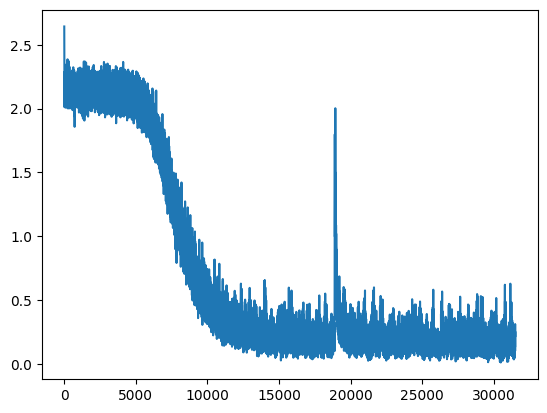

In [81]:
plt.plot(train_losses)

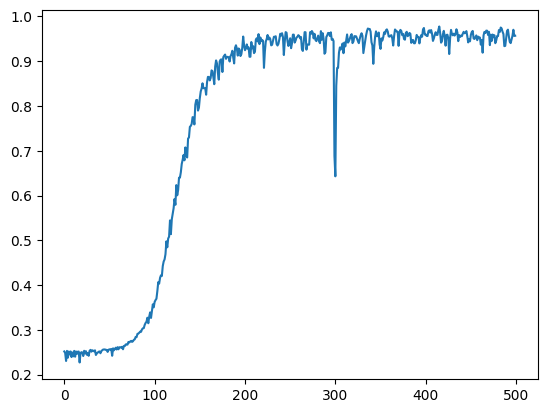

In [82]:
plt.plot(test_accuracy)

In [83]:
from torchmetrics import ConfusionMatrix

In [84]:
metric_cm = ConfusionMatrix(task='multiclass', num_classes=len(labels)).to(device)

In [86]:
model.eval()
correct = 0
for data, target in test_loader:
    # if data.shape != torch.Size([64,1,20000]):
    #         continue
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 7654/8000 (0.9567)
tensor([[  40,    0,    0,    0,    0,    0,    0,    0,    2,    0,    2,    0,
            0],
        [   0,   70,    0,    0,    0,    2,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,  294,    0,    0,    8,    0,    4,   20,    2,    0,    0,
            2],
        [   0,    2,    2,  284,    4,    0,    2,    2,    8,    0,    0,    0,
            0],
        [   0,    0,    0,    2,  686,    2,    2,    0,   10,    0,    4,    4,
            0],
        [   0,    0,    0,    0,    0, 2034,    4,   14,   18,    4,    2,    0,
            8],
        [   0,    0,    0,    4,    4,    8,  510,    0,    0,    2,    0,    0,
            2],
        [   0,    2,   16,   14,    6,   36,    0, 1390,   44,    8,    0,    4,
           16],
        [   0,    2,    4,    0,    6,   16,    0,   12, 3388,    8,   16,    0,
            4],
        [   0,    0,    0,    0,    0,    6,    0,    6,   22,  560,    2,    0,
           14],
  

In [88]:
layer = model.fe_blocks.blocks[0].layer
from IConNet.visualizer import visualize_model
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.5715e-03, 3.5888e-03, 3.5573e-03],
        [7.5535e-03, 7.4577e-03, 7.4339e-03],
        [1.1850e-02, 1.1633e-02, 1.1662e-02],
        [1.6184e-02, 1.6199e-02, 1.6196e-02],
        [2.1111e-02, 2.1108e-02, 2.1123e-02],
        [2.6425e-02, 2.6425e-02, 2.6425e-02],
        [3.2174e-02, 3.2175e-02, 3.2173e-02],
        [3.8363e-02, 3.8396e-02, 3.8701e-02],
        [4.5127e-02, 4.5126e-02, 4.5127e-02],
        [5.2406e-02, 5.2408e-02, 5.2402e-02],
        [6.0274e-02, 6.0273e-02, 6.0324e-02],
        [6.8802e-02, 6.8805e-02, 6.7981e-02],
        [7.8028e-02, 7.8039e-02, 7.8077e-02],
        [8.7996e-02, 8.8018e-02, 8.8005e-02],
        [9.8807e-02, 9.8807e-02, 9.8806e-02],
        [1.1050e-01, 1.1048e-01, 1.1049e-01],
        [1.2313e-01, 1.2313e-01, 1.2313e-01],
        [1.3610e-01, 2.9271e-01, 1.3708e-01],
        [1.5159e-01, 1.5159e-01, 1.5159e-01],
        [1.6759e-01, 1.6759e-01, 1.6759e-

In [89]:
visualize_model.count_parameters(model)

351117

In [90]:
visualize_model.count_parameters(model.fe_blocks)

181760

In [92]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = 20
)

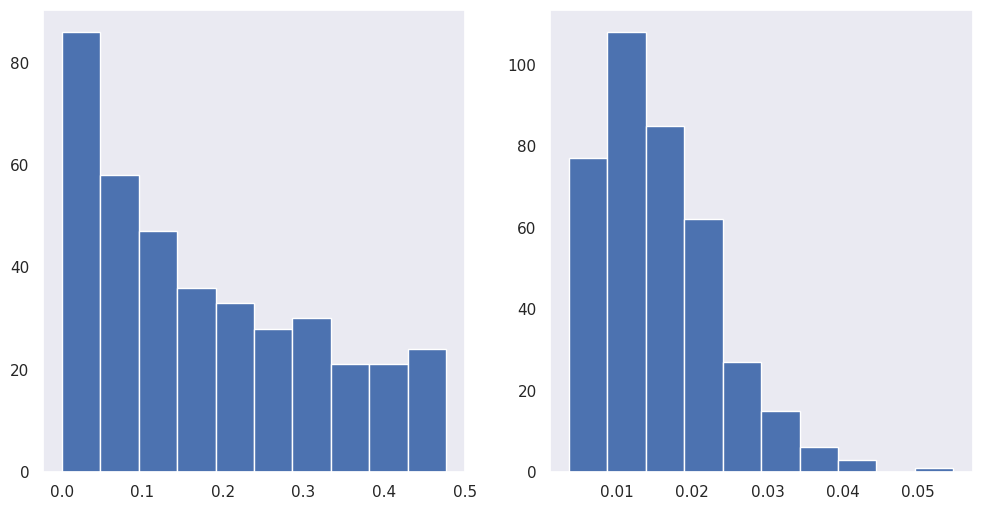

In [93]:
filtviz.visualize_bands()

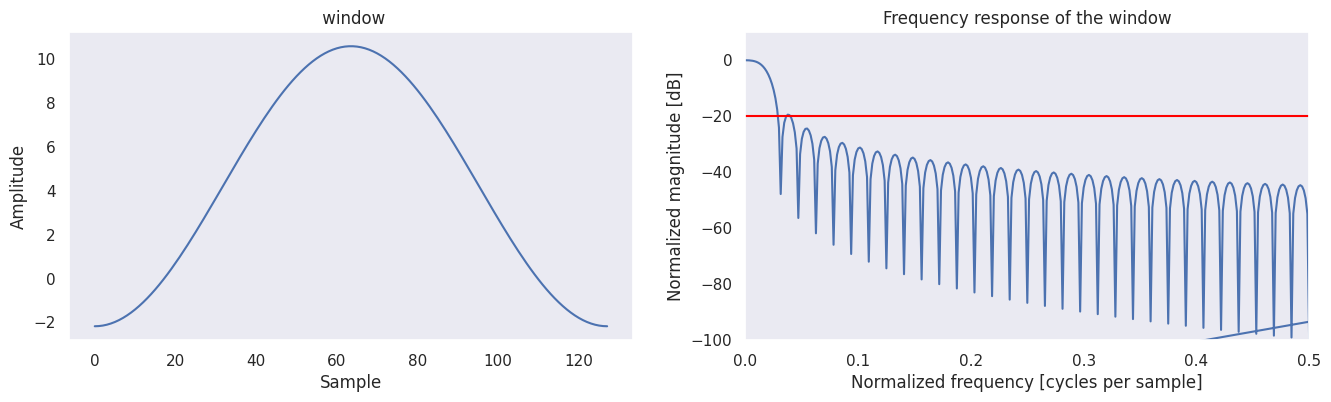

In [95]:
filtviz.visualize_one_window()

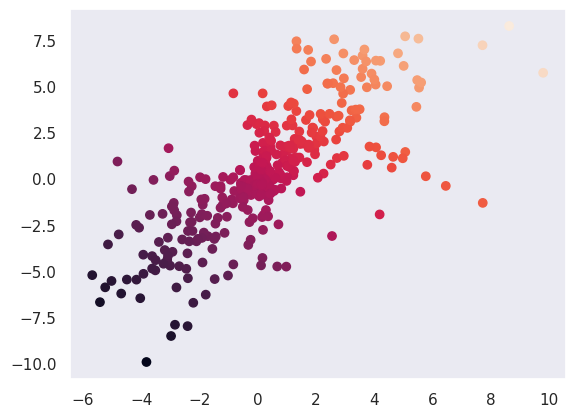

In [96]:
filtviz.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


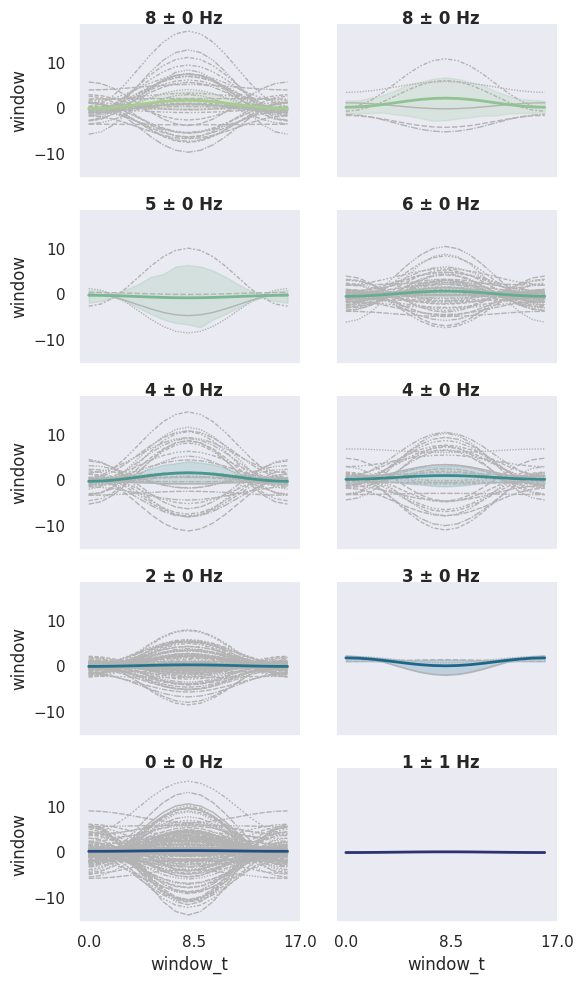

In [97]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


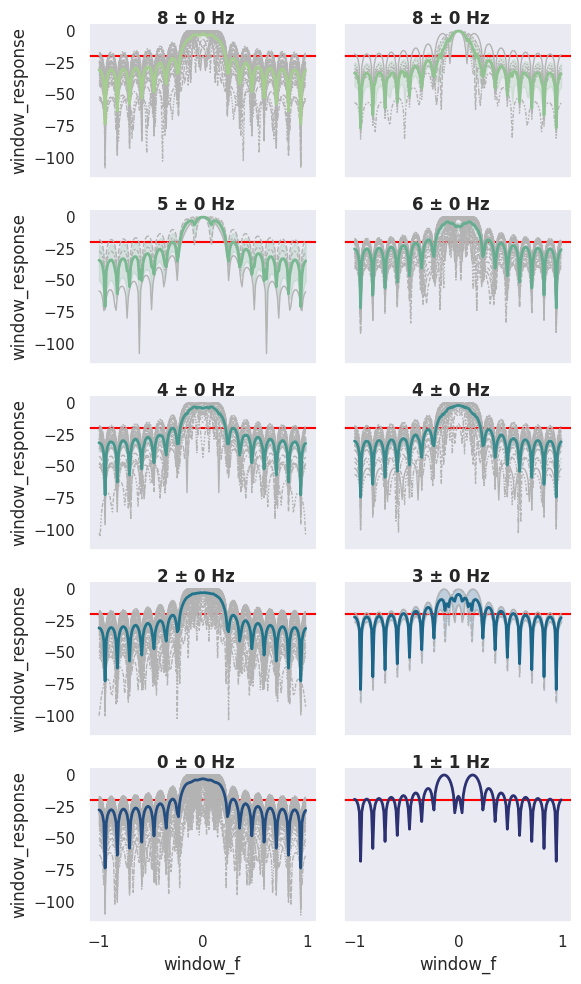

In [98]:
filtviz.visualize_filters(filter_domain='freq')

In [99]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.8963e-14, -1.4850e-14, -1.5346e-14],
        [ 5.8213e-14, -3.3060e-13,  2.3751e-13],
        [-3.4333e-15,  1.4883e-14, -7.1572e-14],
        [ 1.2739e-14, -1.4000e-15, -9.0370e-15],
        [ 7.1145e-14, -3.2932e-15,  6.8414e-14],
        [ 5.9500e-16, -2.1325e-16,  8.0032e-17],
        [-2.9995e-14,  5.5593e-16, -2.2791e-14],
        [ 3.6036e-14,  7.9077e-15,  1.1339e-15],
        [-2.7826e-17,  1.8365e-15, -4.2198e-16],
        [-1.6931e-14,  9.3829e-15, -1.7389e-14],
        [ 4.1587e-14, -5.3062e-14, -1.5368e-13],
        [ 4.9906e-14,  1.0821e-14, -1.8040e-15],
        [ 1.1036e-14, -3.2508e-14, -2.5517e-13],
        [ 3.1743e-14,  1.1651e-14, -5.9989e-14],
        [-1.4502e-16, -3.6653e-17,  7.3321e-18],
        [-3.0621e-13,  7.2087e-14, -2.9993e-13],
        [ 1.0452e-14, -3.7953e-14,  3.7470e-14],
        [-9.1024e-16,  2.9621e-14,  3.2201e-14],
        [-6.9706e-15,  1.9376e-15,  5.4614e-15],
        [ 1.3792e-14

[None, None, None]

In [100]:
os.getcwd()

'/home/linh/projects/IConNet'

In [101]:
model_path = '../iconnet_text_m11.pt'

In [102]:
torch.save(model.state_dict(), model_path)

In [103]:
model.to('cpu')

M11(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): SeqBlocks(
    (blocks): LSTM(128, 64, num_layers=2, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [106]:
model2 = M11(config=model_config,
           n_input=3, n_output=len(labels))
model2.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

In [107]:
model2

M11(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): SeqBlocks(
    (blocks): LSTM(128, 64, num_layers=2, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [109]:
import torchmetrics

In [111]:
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)

model.to(device)

M11(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): SeqBlocks(
    (blocks): LSTM(128, 64, num_layers=2, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [113]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')

Correct: 7654/8000 (0.9567)
F1: 0.9567499756813049
UAP: 0.9495806694030762
WAP: 0.9567499756813049
UAR: 0.9436935782432556
WAR: 0.9567499756813049
